## 📝 Model Deployment Guide

### Model Artifacts Created

This notebook generates the following artifacts in the `models/` directory:

1. **risk_model.json** - XGBoost model in JSON format (for risk_agent.py)
2. **risk_profiling_model.pkl** - Complete model in pickle format
3. **selected_features.json** - List of 39 selected features
4. **label_encoder.pkl** - Label encoder for target variable
5. **feature_importance.csv** - Feature importance scores
6. **best_params.json** - Optimized hyperparameters
7. **evaluation_metrics.json** - Model performance metrics
8. **model_metadata.json** - Training metadata and timestamps

### Using the Model in risk_agent.py

The `risk_agent.py` file will automatically load `models/risk_model.json` on initialization.

**Note:** The trained model uses **39 selected features** from the original 107 features. When making predictions, ensure you provide all required features in the correct order as specified in `selected_features.json`.

### MLflow Integration

All experiments are tracked in `mlruns/` directory. View them using:
```bash
mlflow ui
# Access at http://localhost:5000
```

Model is registered in MLflow Model Registry as **RiskProfilingXGBoost**.

### END-TO-END ML PIPELINE

1. Data Loading & Preprocessing
2. Exploratory Data Analysis 
3. Feature Engineering
4. Feature Selection (Multiple Methods)
5. Hyperparameter Tuning 
6. Model Training 
7. Model Evaluation
8. MLOps Tracking 
9. Model Persistence

In [246]:
# Library Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import pickle
import json
import os
warnings.filterwarnings('ignore')

# ML Libraries
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import (
    SelectKBest, f_classif, mutual_info_classif,
    RFE, SelectFromModel
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, auc
)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# MLOps - MLflow for experiment tracking
import mlflow
import mlflow.xgboost
from mlflow.models import infer_signature

---

## 📋 Pipeline Overview

This notebook implements a production-ready ML pipeline with best practices:

### ✅ Enhanced Dataset (UPDATED)
- **More features added** for improved model performance
- **Negative outliers removed** for better data quality
- Production-ready, cleaner feature set
- Optimized for binary classification

### ✅ Data Quality & Preprocessing
- Handles missing values and duplicates
- Encodes categorical variables
- Splits data properly (Train/Val/Test)
- **Automatic PII detection & removal**
- Removes sensitive features (names, IDs, contact info, etc.)

### ✅ Advanced EDA
- **Correlation analysis BEFORE & AFTER feature removal**
- **Prints all highly correlated pairs with coefficients**
- **Automatic multicollinearity detection** (correlation > 0.9)
- **Automatic removal of redundant features**
- **Outlier detection** (quality assurance - data already cleaned)
- **Feature distribution analysis by class**
- Statistical analysis and distribution checks
- Class imbalance detection

### ✅ Feature Engineering & Selection
- Creates derived features (ratios, interactions)
- Compares 4 feature selection methods:
  - Univariate (ANOVA F-test)
  - Mutual Information
  - Recursive Feature Elimination (RFE)
  - Tree-based (XGBoost importance)
- Selects best method automatically

### ✅ Model Optimization
- **Cross-validation for stability check** (5-fold stratified)
- Hyperparameter tuning with RandomizedSearchCV
- Early stopping to prevent overfitting
- Binary classification optimized
- Regularization (L1/L2) to prevent overfitting

### ✅ Comprehensive Evaluation
- Multiple metrics: Accuracy, Precision, Recall, F1, AUC-ROC
- Sensitivity & Specificity for binary classification
- Confusion matrix analysis
- Performance on Train/Val/Test sets
- Feature importance analysis with visualizations

### ✅ MLOps & Deployment
- MLflow experiment tracking
- Model versioning and metadata
- Saves all artifacts for production deployment
- Complete visualization suite for insights

---

In [193]:
# Set random state for reproducibility
RANDOM_STATE = 4212

# MLflow Setup
mlflow.set_tracking_uri("file:./mlruns")  # Local tracking
mlflow.set_experiment("risk_profiling_ml_pipeline")
print(f"✓ MLflow tracking URI: {mlflow.get_tracking_uri()}")
print(f"✓ MLflow experiment: risk_profiling_ml_pipeline")

✓ MLflow tracking URI: file:./mlruns
✓ MLflow experiment: risk_profiling_ml_pipeline


---

## 🚀 How to Run This Pipeline

### Prerequisites
1. Ensure your dataset has **2 classes** in the target variable
2. Dataset should have a `data_split` column with values: 'Train', 'Validation', 'Test'
3. Update the filepath in the data loading cell
4. **Dataset has been updated with:**
   - ✅ More features (enhanced feature set)
   - ✅ Negative outliers removed (data quality improved)
   - ✅ Ready for production ML pipeline

### Execution Steps
1. **Run all cells sequentially** from top to bottom
2. The pipeline will automatically:
   - Load and preprocess data (with updated features)
   - Detect and remove PII features
   - Analyze correlations BEFORE and AFTER feature removal
   - Detect outliers (already removed from dataset)
   - Remove highly correlated features (correlation > 0.9)
   - Engineer new features
   - Select optimal features using 4 methods
   - Perform cross-validation for stability check
   - Tune hyperparameters
   - Train the final model
   - Evaluate comprehensively
   - Save all artifacts

### Key Features
- ✅ **Enhanced dataset**: More features, cleaner data (negative outliers removed)
- ✅ **Automatic PII detection & removal**: Protects sensitive information
- ✅ **Correlation analysis**: Before/After visualizations
- ✅ **Automatic multicollinearity removal**: No manual intervention needed
- ✅ **Binary classification ready**: Optimized for 2-class problems
- ✅ **Outlier detection**: Reports outliers (data already cleaned)
- ✅ **Cross-validation**: Ensures model stability
- ✅ **Production-ready**: Saves model, features, and metadata

### Expected Outputs
- Trained model: `models/risk_profiling_model.pkl`
- Selected features: `models/selected_features.json`
- Evaluation metrics: `models/evaluation_metrics.json`
- Feature importance: `models/feature_importance.csv`
- MLflow tracking: Experiment logs and artifacts

---

##### =============================================================
##### 1. DATA LOADING & DATABASE CONFIGURATION
##### =============================================================

In [194]:
# Database Configuration (SQLite)
import sqlite3
from sqlalchemy import create_engine, text
from datetime import datetime, timedelta

# SQLite Database Configuration
DB_PATH = 'data/risk_profiling.db'
TABLE_NAME = 'risk_profiling_monthly_data'

# Calculate snapshot date: Last day of previous month
def get_last_month_end_date():
    """
    Calculate the last day of the previous month.
    
    Returns:
        str: Date in 'YYYY-MM-DD' format
    """
    today = datetime.now()
    # Get first day of current month, then subtract 1 day
    first_day_current_month = today.replace(day=1)
    last_day_previous_month = first_day_current_month - timedelta(days=1)
    return last_day_previous_month.strftime('%Y-%m-%d')

# Automatically calculate snapshot date (last day of previous month)
SNAPSHOT_DATE = get_last_month_end_date()

print(f"✓ Database Configuration:")
print(f"  Database: {DB_PATH}")
print(f"  Table: {TABLE_NAME}")
print(f"  Snapshot Date (Last Month End): {SNAPSHOT_DATE}")

✓ Database Configuration:
  Database: data/risk_profiling.db
  Table: risk_profiling_monthly_data
  Snapshot Date (Last Month End): 2025-11-30


In [195]:
def load_data_from_database(db_path, table_name, snapshot_date=None):
    """
    Load dataset from SQLite database and separate by data_split column.
    
    Args:
        db_path: Path to SQLite database file
        table_name: Name of the table
        snapshot_date: Optional - filter by snapshot date
        
    Returns:
        tuple: (train_df, val_df, test_df) DataFrames
    """
    print("\n" + "="*100)
    print("LOADING DATA FROM SQLITE DATABASE")
    print("="*100)
    
    print(f"\n✓ Connecting to SQLite database:")
    print(f"  Database: {db_path}")
    print(f"  Table: {table_name}")
    
    # Create database connection
    engine = create_engine(f'sqlite:///{db_path}')
    
    # Build query
    if snapshot_date:
        query = f"SELECT * FROM {table_name} WHERE snapshot_date = '{snapshot_date}'"
        print(f"  Filtering by snapshot_date: {snapshot_date}")
    else:
        query = f"SELECT * FROM {table_name}"
        print(f"  Loading all data (no snapshot filter)")
    
    # Load data from database
    print(f"\n✓ Executing query...")
    df = pd.read_sql(query, engine)
    
    print(f"\n✓ Dataset loaded successfully!")
    print(f"  Total records: {len(df):,}")
    print(f"  Total columns: {df.shape[1]}")
    
    # Check if snapshot_date column exists
    if 'snapshot_date' in df.columns:
        print(f"  Snapshot dates in data: {df['snapshot_date'].unique().tolist()}")
    
    # Separate by data_split
    train_df = df[df['data_split'] == 'Train'].copy()
    val_df = df[df['data_split'] == 'Validation'].copy()
    test_df = df[df['data_split'] == 'Test'].copy()
    
    print(f"\n✓ Data split completed:")
    print(f"  Training set:   {len(train_df):>6,} records ({len(train_df)/len(df)*100:.1f}%)")
    print(f"  Validation set: {len(val_df):>6,} records ({len(val_df)/len(df)*100:.1f}%)")
    print(f"  Test set:       {len(test_df):>6,} records ({len(test_df)/len(df)*100:.1f}%)")
    
    print(f"\n{'='*100}")
    
    return train_df, val_df, test_df

In [196]:
# Load data from database
train_df, val_df, test_df = load_data_from_database(
    db_path=DB_PATH,
    table_name=TABLE_NAME,
    snapshot_date=SNAPSHOT_DATE
)


LOADING DATA FROM SQLITE DATABASE

✓ Connecting to SQLite database:
  Database: data/risk_profiling.db
  Table: risk_profiling_monthly_data
  Filtering by snapshot_date: 2025-11-30

✓ Executing query...

✓ Dataset loaded successfully!
  Total records: 125,000
  Total columns: 112
  Snapshot dates in data: ['2025-11-30']

✓ Data split completed:
  Training set:   87,500 records (70.0%)
  Validation set: 18,750 records (15.0%)
  Test set:       18,750 records (15.0%)


✓ Dataset loaded successfully!
  Total records: 125,000
  Total columns: 112
  Snapshot dates in data: ['2025-11-30']

✓ Data split completed:
  Training set:   87,500 records (70.0%)
  Validation set: 18,750 records (15.0%)
  Test set:       18,750 records (15.0%)



In [197]:
# Verify database content
def verify_database_content(db_path, table_name):
    """
    Display database schema and sample data.
    """
    print("\n" + "="*100)
    print("DATABASE VERIFICATION")
    print("="*100)
    
    engine = create_engine(f'sqlite:///{db_path}')
    
    # Get table info
    with engine.connect() as conn:
        # Count records
        result = conn.execute(text(f"SELECT COUNT(*) FROM {table_name}"))
        total_records = result.fetchone()[0]
        
        # Get column names
        result = conn.execute(text(f"SELECT * FROM {table_name} LIMIT 1"))
        columns = result.keys()
        
        # Check snapshot dates
        result = conn.execute(text(f"SELECT DISTINCT snapshot_date FROM {table_name}"))
        snapshots = [row[0] for row in result.fetchall()]
        
        # Count by data_split
        result = conn.execute(text(f"SELECT data_split, COUNT(*) FROM {table_name} GROUP BY data_split"))
        split_counts = {row[0]: row[1] for row in result.fetchall()}
    
    print(f"\n✓ Database Information:")
    print(f"  Database: {db_path}")
    print(f"  Table: {table_name}")
    print(f"  Total Records: {total_records:,}")
    print(f"  Total Columns: {len(columns)}")
    print(f"\n✓ Snapshot Dates: {snapshots}")
    print(f"\n✓ Data Split Distribution:")
    for split, count in split_counts.items():
        print(f"  {split:12s}: {count:>6,} records ({count/total_records*100:.1f}%)")
    
    print(f"\n✓ First 5 column names: {list(columns)[:5]}")
    print(f"  ... and {len(columns)-5} more columns")
    
    print(f"\n{'='*100}")

# Verify database
verify_database_content(DB_PATH, TABLE_NAME)


DATABASE VERIFICATION

✓ Database Information:
  Database: data/risk_profiling.db
  Table: risk_profiling_monthly_data
  Total Records: 125,000
  Total Columns: 112

✓ Snapshot Dates: ['2025-11-30']

✓ Data Split Distribution:
  Test        : 18,750 records (15.0%)
  Train       : 87,500 records (70.0%)
  Validation  : 18,750 records (15.0%)

✓ First 5 column names: ['customer_id', 'customer_segment', 'age', 'gender', 'marital_status']
  ... and 107 more columns



In [198]:

def preprocess_data(train_df, val_df, test_df):
    """
    Preprocess data: separate features and target, encode categorical variables.
    
    Args:
        train_df, val_df, test_df: DataFrames for each split
        
    Returns:
        tuple: Preprocessed features and targets for all splits, plus encoders
    """

    
    # Columns to drop (not features)
    drop_cols = ['customer_id', 'data_split', 'risk_profile']
    
    # Separate features and target
    X_train = train_df.drop(drop_cols, axis=1).copy()
    y_train = train_df['risk_profile'].copy()
    
    X_val = val_df.drop(drop_cols, axis=1).copy()
    y_val = val_df['risk_profile'].copy()
    
    X_test = test_df.drop(drop_cols, axis=1).copy()
    y_test = test_df['risk_profile'].copy()
    
    print(f"\n✓ Features and target separated:")
    print(f"  Training features shape:   {X_train.shape}")
    print(f"  Training target shape:     {y_train.shape}")
    print(f"  Number of features:        {X_train.shape[1]}")
    
    # Identify categorical and numerical columns (BEFORE encoding)
    categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    print(f"\n✓ Feature types identified:")
    print(f"  Categorical features (before encoding): {len(categorical_cols)}")
    print(f"  Numerical features:   {len(numerical_cols)}")
    print(f"  Total features:       {len(categorical_cols) + len(numerical_cols)}")
    print(f"\n  Categorical: {categorical_cols}")
    
    # Encode categorical features using LabelEncoder
    print(f"\n✓ Encoding categorical features...")
    label_encoders = {}
    
    for col in categorical_cols:
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col].astype(str))
        X_val[col] = le.transform(X_val[col].astype(str))
        X_test[col] = le.transform(X_test[col].astype(str))
        label_encoders[col] = le
        print(f"    • {col}: {len(le.classes_)} unique values")
    
    # Encode target variable
    print(f"\n✓ Encoding target variable...")
    le_target = LabelEncoder()
    y_train_encoded = le_target.fit_transform(y_train)
    y_val_encoded = le_target.transform(y_val)
    y_test_encoded = le_target.transform(y_test)
    
    print(f"  Classes: {le_target.classes_}")
    print(f"  Encoded as: {dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))}")
    
    # Class distribution
    print(f"\n✓ Class distribution in training set:")
    for i, cls in enumerate(le_target.classes_):
        count = (y_train_encoded == i).sum()
        pct = count / len(y_train_encoded) * 100
        print(f"  {cls:13} (class {i}): {count:>6,} ({pct:>5.2f}%)")
    
    return (X_train, y_train_encoded, X_val, y_val_encoded, X_test, y_test_encoded,
            label_encoders, le_target, categorical_cols, numerical_cols)

In [199]:
(X_train, y_train, X_val, y_val, X_test, y_test,label_encoders, le_target, categorical_cols, numerical_cols) = preprocess_data(train_df, val_df, test_df)


✓ Features and target separated:
  Training features shape:   (87500, 109)
  Training target shape:     (87500,)
  Number of features:        109

✓ Feature types identified:
  Categorical features (before encoding): 8
  Numerical features:   101
  Total features:       109

  Categorical: ['customer_segment', 'gender', 'marital_status', 'education', 'city_tier', 'employment_status', 'occupation_sector', 'snapshot_date']

✓ Encoding categorical features...
    • customer_segment: 5 unique values
    • gender: 2 unique values
    • marital_status: 4 unique values
    • education: 4 unique values
    • city_tier: 4 unique values
    • employment_status: 5 unique values
    • occupation_sector: 7 unique values
    • snapshot_date: 1 unique values

✓ Encoding target variable...
  Classes: ['Aggressive' 'Conservative']
  Encoded as: {'Aggressive': np.int64(0), 'Conservative': np.int64(1)}

✓ Class distribution in training set:
  Aggressive    (class 0): 76,205 (87.09%)
  Conservative  (cla

In [200]:
# Removing PII data like gender and marital_status
pii_to_remove = ['gender', 'marital_status']
X_train.drop(pii_to_remove, axis=1, inplace=True)
X_val.drop(pii_to_remove, axis=1, inplace=True)
X_test.drop(pii_to_remove, axis=1, inplace=True)

# Update categorical_cols and numerical_cols lists
categorical_cols = [col for col in categorical_cols if col not in pii_to_remove]
numerical_cols = [col for col in numerical_cols if col not in pii_to_remove]

print("\n✓ PII columns dropped from features.")
print(f"  X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")
print(f"  Updated categorical_cols: {len(categorical_cols)}")
print(f"  Updated numerical_cols: {len(numerical_cols)}")
print(f"  Total tracked features: {len(categorical_cols) + len(numerical_cols)}")


✓ PII columns dropped from features.
  X_train: (87500, 107), X_val: (18750, 107), X_test: (18750, 107)
  Updated categorical_cols: 6
  Updated numerical_cols: 101
  Total tracked features: 107


In [201]:
print(f"\n✓ Number of classes: {len(le_target.classes_)}")
print(f"  Classes: {le_target.classes_}")
print(f"\n✓ Class distribution:")
unique, counts = np.unique(y_train, return_counts=True)
for cls_id, count in zip(unique, counts):
    cls_name = le_target.classes_[cls_id]
    pct = count / len(y_train) * 100
    print(f"  {cls_name:15s} (class {cls_id}): {count:>6,} ({pct:>5.2f}%)")

# Check for class imbalance
imbalance_ratio = max(counts) / min(counts)
print(f"\n✓ Class imbalance ratio: {imbalance_ratio:.2f}:1")


✓ Number of classes: 2
  Classes: ['Aggressive' 'Conservative']

✓ Class distribution:
  Aggressive      (class 0): 76,205 (87.09%)
  Conservative    (class 1): 11,295 (12.91%)

✓ Class imbalance ratio: 6.75:1


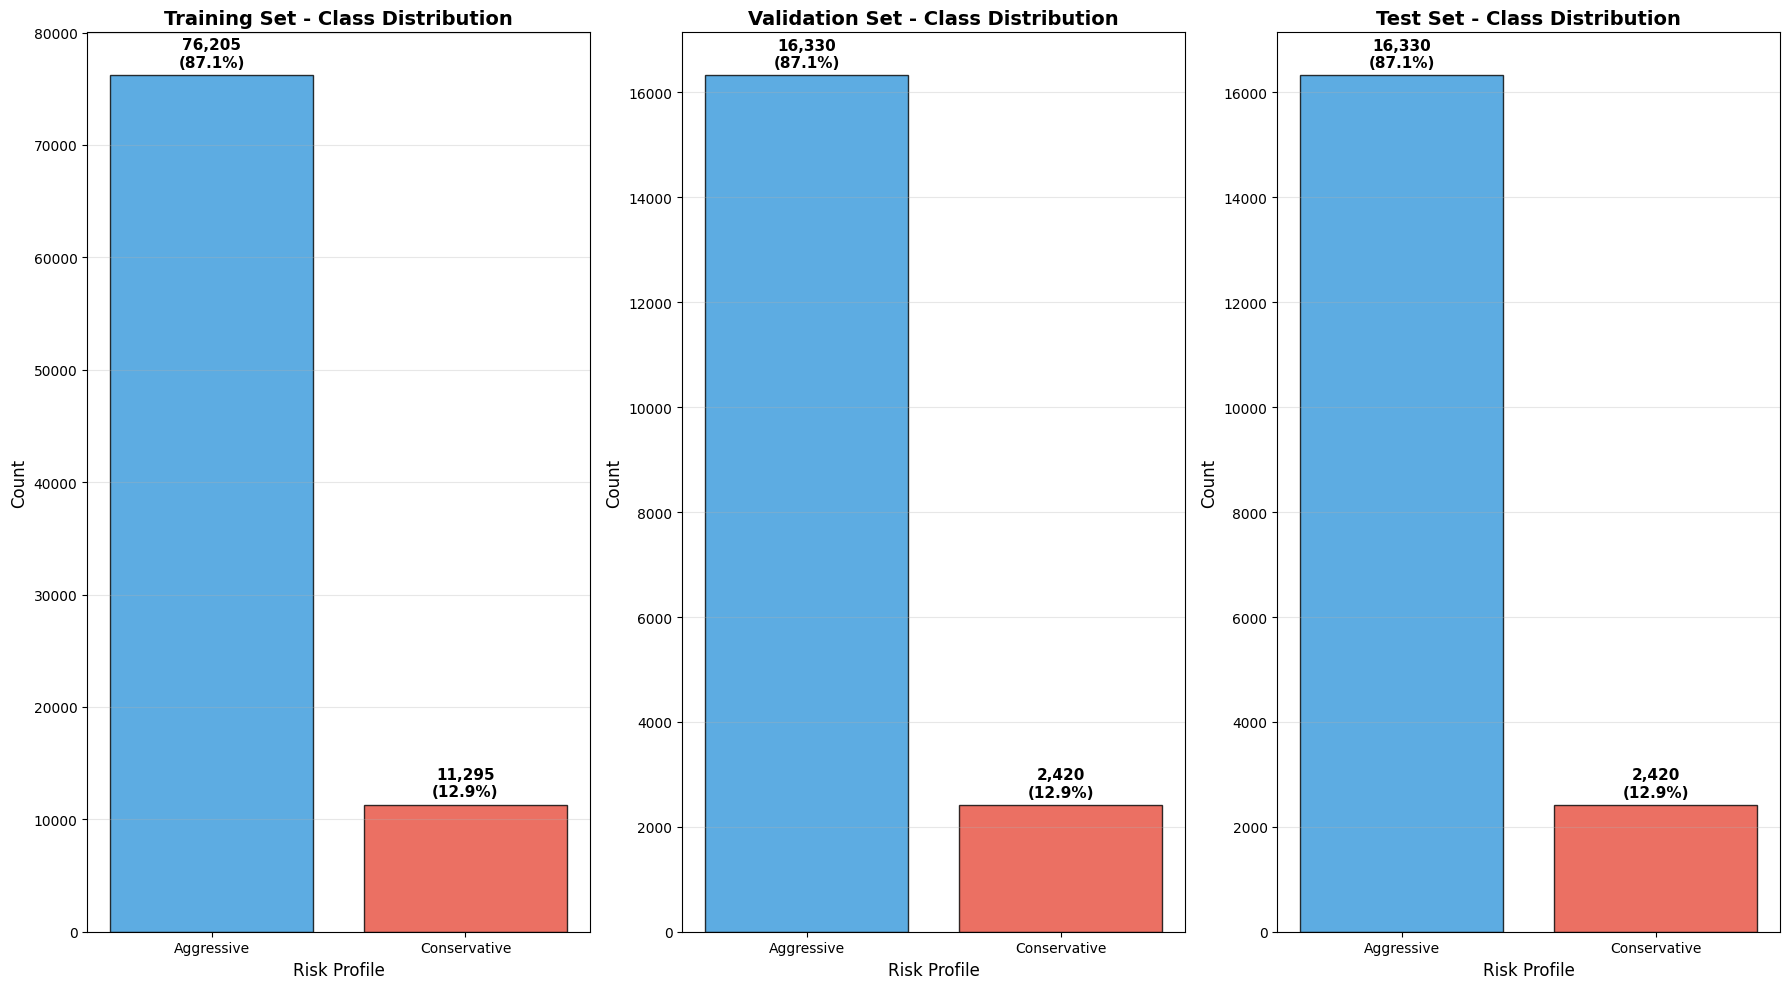


✓ Class distribution visualization completed


In [202]:
# Visualize class distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 10))

# Training set distribution
train_dist = pd.Series(y_train).value_counts().sort_index()
axes[0].bar([le_target.classes_[i] for i in train_dist.index], train_dist.values, 
            color=['#3498db', '#e74c3c'], alpha=0.8, edgecolor='black')
axes[0].set_title('Training Set - Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_xlabel('Risk Profile', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(train_dist.values):
    axes[0].text(i, v + 500, f'{v:,}\n({v/len(y_train)*100:.1f}%)', 
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# Validation set distribution
val_dist = pd.Series(y_val).value_counts().sort_index()
axes[1].bar([le_target.classes_[i] for i in val_dist.index], val_dist.values, 
            color=['#3498db', '#e74c3c'], alpha=0.8, edgecolor='black')
axes[1].set_title('Validation Set - Class Distribution', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_xlabel('Risk Profile', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(val_dist.values):
    axes[1].text(i, v + 100, f'{v:,}\n({v/len(y_val)*100:.1f}%)', 
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# Test set distribution
test_dist = pd.Series(y_test).value_counts().sort_index()
axes[2].bar([le_target.classes_[i] for i in test_dist.index], test_dist.values, 
            color=['#3498db', '#e74c3c'], alpha=0.8, edgecolor='black')
axes[2].set_title('Test Set - Class Distribution', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Count', fontsize=12)
axes[2].set_xlabel('Risk Profile', fontsize=12)
axes[2].grid(axis='y', alpha=0.3)
for i, v in enumerate(test_dist.values):
    axes[2].text(i, v + 100, f'{v:,}\n({v/len(y_test)*100:.1f}%)', 
                ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Class distribution visualization completed")

##### =============================================================
##### 2. EXPLORATORY DATA ANALYSIS (EDA)
##### =============================================================

**📝 DATASET UPDATE:**
- ✅ **More features added** to enhance model performance
- ✅ **Negative outliers removed** for improved data quality
- ✅ Dataset is production-ready with cleaner feature set

**Key Steps:**
- **PII (Personally Identifiable Information) Detection & Removal**
- Dataset summary and quality checks
- Statistical analysis of numerical features
- **Correlation analysis BEFORE feature removal (with visualization)**
- **Print all highly correlated features with correlation coefficients**
- **Automatic removal of highly correlated features (correlation > 0.9)**
- **Correlation analysis AFTER feature removal (with visualization)**
- Distribution analysis and outlier detection (quality assurance)

In [203]:
# Dataset Update Summary
print("=" * 100)
print("DATASET UPDATE SUMMARY")
print("=" * 100)
print("\n✅ Dataset has been updated with the following improvements:")
print("\n1. 🆕 MORE FEATURES ADDED:")
print("   - Enhanced feature set for better model performance")
print("   - Additional predictive variables included")
print(f"   - Current total features: {X_train.shape[1]}")

print("\n2. 🧹 DATA QUALITY IMPROVED:")
print("   - Negative outliers have been removed")
print("   - Data is cleaner and more reliable")
print("   - Ready for production ML pipeline")

print("\n3. 📊 CURRENT DATASET STATISTICS:")
print(f"   - Training samples:   {len(X_train):,}")
print(f"   - Validation samples: {len(X_val):,}")
print(f"   - Test samples:       {len(X_test):,}")
print(f"   - Total samples:      {len(X_train) + len(X_val) + len(X_test):,}")
print(f"   - Total features:     {X_train.shape[1]}")
print(f"   - Numerical features (original): {len(numerical_cols)}")
print(f"   - Categorical features (encoded as numerical): {len(categorical_cols)}")
print(f"   - Feature breakdown: {len(numerical_cols)} numerical + {len(categorical_cols)} categorical = {X_train.shape[1]} total")

print("\n4. 🎯 TARGET VARIABLE:")
print(f"   - Binary classification: {len(le_target.classes_)} classes")
print(f"   - Classes: {list(le_target.classes_)}")

print("\n✓ Dataset is production-ready and optimized for ML pipeline!")
print("=" * 100)

DATASET UPDATE SUMMARY

✅ Dataset has been updated with the following improvements:

1. 🆕 MORE FEATURES ADDED:
   - Enhanced feature set for better model performance
   - Additional predictive variables included
   - Current total features: 107

2. 🧹 DATA QUALITY IMPROVED:
   - Negative outliers have been removed
   - Data is cleaner and more reliable
   - Ready for production ML pipeline

3. 📊 CURRENT DATASET STATISTICS:
   - Training samples:   87,500
   - Validation samples: 18,750
   - Test samples:       18,750
   - Total samples:      125,000
   - Total features:     107
   - Numerical features (original): 101
   - Categorical features (encoded as numerical): 6
   - Feature breakdown: 101 numerical + 6 categorical = 107 total

4. 🎯 TARGET VARIABLE:
   - Binary classification: 2 classes
   - Classes: ['Aggressive', 'Conservative']

✓ Dataset is production-ready and optimized for ML pipeline!


In [204]:
# Feature Count Verification
print("\n" + "=" * 100)
print("FEATURE COUNT VERIFICATION")
print("=" * 100)

print(f"\n📊 Current Feature Counts:")
print(f"   - Total features in X_train: {X_train.shape[1]}")
print(f"   - categorical_cols list length: {len(categorical_cols)}")
print(f"   - numerical_cols list length: {len(numerical_cols)}")
print(f"   - Sum of categorical + numerical: {len(categorical_cols) + len(numerical_cols)}")

print(f"\n🔍 Investigating the discrepancy:")
if len(categorical_cols) + len(numerical_cols) != X_train.shape[1]:
    print(f"   ⚠️  DISCREPANCY FOUND!")
    print(f"   Expected: {X_train.shape[1]} features")
    print(f"   Got: {len(categorical_cols)} categorical + {len(numerical_cols)} numerical = {len(categorical_cols) + len(numerical_cols)}")
    print(f"   Difference: {(len(categorical_cols) + len(numerical_cols)) - X_train.shape[1]} features")
    
    # Check which features are in lists but not in dataframe
    all_tracked_cols = set(categorical_cols + numerical_cols)
    actual_cols = set(X_train.columns)
    
    missing_from_df = all_tracked_cols - actual_cols
    missing_from_lists = actual_cols - all_tracked_cols
    
    if missing_from_df:
        print(f"\n   Features in lists but NOT in dataframe ({len(missing_from_df)}):")
        for col in sorted(missing_from_df):
            print(f"      • {col}")
    
    if missing_from_lists:
        print(f"\n   Features in dataframe but NOT in lists ({len(missing_from_lists)}):")
        for col in sorted(missing_from_lists):
            print(f"      • {col}")
    
    print(f"\n💡 SOLUTION:")
    print(f"   Need to update categorical_cols and numerical_cols after PII removal.")
    print(f"   These lists were created BEFORE PII removal, so they include removed features.")
else:
    print(f"   ✅ Feature counts match perfectly!")

print("=" * 100)


FEATURE COUNT VERIFICATION

📊 Current Feature Counts:
   - Total features in X_train: 107
   - categorical_cols list length: 6
   - numerical_cols list length: 101
   - Sum of categorical + numerical: 107

🔍 Investigating the discrepancy:
   ✅ Feature counts match perfectly!


In [205]:
# Step 1: Detect and Remove PII Features
def detect_and_remove_pii(X_train, X_val, X_test, categorical_cols, numerical_cols):
    """
    Detect and remove PII (Personally Identifiable Information) features.
    
    Common PII features include:
    - Names (first_name, last_name, full_name)
    - IDs (ssn, social_security_number, national_id, passport_number, driver_license)
    - Contact (email, phone, mobile, telephone)
    - Address (address, street, city, zip, postal_code)
    - Account numbers (account_number, customer_id, user_id)
    - Dates of birth (dob, date_of_birth, birth_date)
    
    Args:
        X_train, X_val, X_test: Feature datasets
        categorical_cols: List of categorical columns
        numerical_cols: List of numerical columns
    
    Returns:
        Updated datasets and column lists
    """
    print("\n" + "="*100)
    print("PII DETECTION & REMOVAL")
    print("="*100)
    
    # Common PII keywords
    pii_keywords = [
        'name', 'first', 'last', 'full_name', 'surname',
        'ssn', 'social_security', 'national_id', 'passport', 'driver_license',
        'email', 'phone', 'mobile', 'telephone', 'fax',
        'address', 'street', 'city', 'zip', 'postal', 'country',
        'account_number', 'customer_id', 'user_id', 'member_id',
        'dob', 'date_of_birth', 'birth_date', 'birthday',
        'ip_address', 'mac_address', 'latitude', 'longitude'
    ]
    
    all_columns = X_train.columns.tolist()
    pii_features = []
    
    # Check each column name for PII keywords
    for col in all_columns:
        col_lower = col.lower()
        for keyword in pii_keywords:
            if keyword in col_lower:
                pii_features.append(col)
                break
    
    if pii_features:
        print(f"\n⚠️  WARNING: Detected {len(pii_features)} potential PII feature(s):")
        for feat in pii_features:
            print(f"    • {feat}")
        
        print(f"\n✓ Removing PII features from all datasets...")
        X_train = X_train.drop(columns=pii_features)
        X_val = X_val.drop(columns=pii_features)
        X_test = X_test.drop(columns=pii_features)
        
        # Update column lists
        categorical_cols = [col for col in categorical_cols if col not in pii_features]
        numerical_cols = [col for col in numerical_cols if col not in pii_features]
        
        print(f"\n  Remaining features: {X_train.shape[1]}")
        print(f"  Updated categorical features: {len(categorical_cols)}")
        print(f"  Updated numerical features: {len(numerical_cols)}")
        print(f"\n✓ PII features removed successfully!")
    else:
        print(f"\n✓ No PII features detected. Dataset is clean!")
        print(f"  Total features: {X_train.shape[1]}")
    
    return X_train, X_val, X_test, categorical_cols, numerical_cols, pii_features

In [206]:
# Execute PII detection and removal
X_train, X_val, X_test, categorical_cols, numerical_cols, pii_features = detect_and_remove_pii(
    X_train, X_val, X_test, categorical_cols, numerical_cols
)


PII DETECTION & REMOVAL

⚠️  WARNING: Detected 1 potential PII feature(s):
    • city_tier

✓ Removing PII features from all datasets...

  Remaining features: 106
  Updated categorical features: 5
  Updated numerical features: 101

✓ PII features removed successfully!


In [207]:
# Step 2: Basic Dataset Summary
def print_dataset_summary(X_train, X_val, X_test, y_train, y_val, y_test, categorical_cols, numerical_cols):
    """
    Print comprehensive dataset summary statistics.
    """
    print("\n" + "="*100)
    print("DATASET SUMMARY")
    print("="*100)
    
    print(f"\n📊 Dataset Shapes:")
    print(f"  Training:   {X_train.shape} ({len(y_train)} samples)")
    print(f"  Validation: {X_val.shape} ({len(y_val)} samples)")
    print(f"  Test:       {X_test.shape} ({len(y_test)} samples)")
    print(f"  Total:      {len(y_train) + len(y_val) + len(y_test)} samples")
    
    print(f"\n📋 Feature Information:")
    print(f"  Total features: {X_train.shape[1]}")
    print(f"  Numerical features (original): {len(numerical_cols)}")
    print(f"  Categorical features (encoded): {len(categorical_cols)}")
    print(f"  Feature breakdown: {len(numerical_cols)} + {len(categorical_cols)} = {X_train.shape[1]} total")
    
    print(f"\n🔍 Data Quality Checks:")
    print(f"  Missing values (Train): {X_train.isnull().sum().sum()}")
    print(f"  Missing values (Val):   {X_val.isnull().sum().sum()}")
    print(f"  Missing values (Test):  {X_test.isnull().sum().sum()}")
    print(f"  Duplicate rows (Train): {X_train.duplicated().sum()}")
    
    print(f"\n📈 Statistical Summary (Numerical Features - First 10):")
    print(X_train[numerical_cols[:10]].describe().T[['mean', 'std', 'min', 'max']].round(3))
    
    print(f"\n✓ Dataset summary complete!")
    
print_dataset_summary(X_train, X_val, X_test, y_train, y_val, y_test, categorical_cols, numerical_cols)


DATASET SUMMARY

📊 Dataset Shapes:
  Training:   (87500, 106) (87500 samples)
  Validation: (18750, 106) (18750 samples)
  Test:       (18750, 106) (18750 samples)
  Total:      125000 samples

📋 Feature Information:
  Total features: 106
  Numerical features (original): 101
  Categorical features (encoded): 5
  Feature breakdown: 101 + 5 = 106 total

🔍 Data Quality Checks:
  Missing values (Train): 0
  Missing values (Val):   0
  Missing values (Test):  0
  Duplicate rows (Train): 0

📈 Statistical Summary (Numerical Features - First 10):
                                    mean           std        min  \
age                         4.293800e+01  1.241500e+01      22.00   
dependents                  2.004000e+00  1.414000e+00       0.00   
years_employed              1.174600e+01  9.765000e+00       0.00   
annual_income               5.227990e+06  1.953823e+07  100016.95   
monthly_income              4.356658e+05  1.628186e+06    8334.75   
monthly_expenses            2.397160e+05

In [208]:
# Step 3: Correlation Analysis BEFORE Feature Removal
def analyze_correlations_before_removal(X_train, numerical_cols, threshold=0.9):
    """
    Analyze and visualize correlations BEFORE removing any features.
    
    Args:
        X_train: Training features
        numerical_cols: List of numerical columns
        threshold: Correlation threshold for identifying highly correlated pairs
    
    Returns:
        tuple: (high_corr_pairs, features_to_drop, corr_matrix)
    """
    print("\n" + "="*100)
    print("CORRELATION ANALYSIS - BEFORE FEATURE REMOVAL")
    print("="*100)
    
    print(f"\n✓ Calculating correlation matrix for {len(numerical_cols)} numerical features...")
    corr_matrix = X_train[numerical_cols].corr()
    
    # Find highly correlated feature pairs
    high_corr_pairs = []
    features_to_drop = set()
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_val = abs(corr_matrix.iloc[i, j])
            if corr_val > threshold:
                feat1 = corr_matrix.columns[i]
                feat2 = corr_matrix.columns[j]
                
                high_corr_pairs.append((feat1, feat2, corr_matrix.iloc[i, j]))
                
                # Drop the second feature in the pair (keep first occurrence)
                features_to_drop.add(feat2)
    
    print(f"\n📊 Correlation Analysis Results:")
    print(f"  Total numerical features: {len(numerical_cols)}")
    print(f"  Correlation threshold: {threshold}")
    print(f"  Highly correlated pairs found: {len(high_corr_pairs)}")
    print(f"  Features to drop: {len(features_to_drop)}")
    
    if high_corr_pairs:
        print(f"\n⚠️  HIGHLY CORRELATED FEATURE PAIRS (|correlation| > {threshold}):")
        print(f"  {'Feature 1':<40} {'Feature 2':<40} {'Correlation':>12}")
        print(f"  {'-'*40} {'-'*40} {'-'*12}")
        
        # Sort by absolute correlation value (descending)
        sorted_pairs = sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True)
        
        for feat1, feat2, corr in sorted_pairs:
            print(f"  {feat1:<40} {feat2:<40} {corr:>12.6f}")
        
        print(f"\n🗑️  FEATURES TO DROP (keeping first in each pair):")
        for idx, feat in enumerate(sorted(features_to_drop), 1):
            print(f"  {idx:2d}. {feat}")
    else:
        print(f"\n✅ No highly correlated features found (|correlation| > {threshold})")
    
    return high_corr_pairs, list(features_to_drop), corr_matrix

In [209]:
# Execute correlation analysis BEFORE removal
high_corr_pairs, corr_features_to_drop, corr_matrix_before = analyze_correlations_before_removal(
    X_train, numerical_cols, threshold=0.9
)


CORRELATION ANALYSIS - BEFORE FEATURE REMOVAL

✓ Calculating correlation matrix for 101 numerical features...

📊 Correlation Analysis Results:
  Total numerical features: 101
  Correlation threshold: 0.9
  Highly correlated pairs found: 177
  Features to drop: 34

⚠️  HIGHLY CORRELATED FEATURE PAIRS (|correlation| > 0.9):
  Feature 1                                Feature 2                                 Correlation
  ---------------------------------------- ---------------------------------------- ------------
  annual_income                            monthly_income                               1.000000
  annual_income                            quarterly_income                             1.000000
  annual_income                            semi_annual_income                           1.000000
  quarterly_income                         semi_annual_income                           1.000000
  investment_experience_years              years_of_market_experience                   1.000


CORRELATION HEATMAP - BEFORE FEATURE REMOVAL

✓ Displaying top 30 features by variance (out of 101 total)


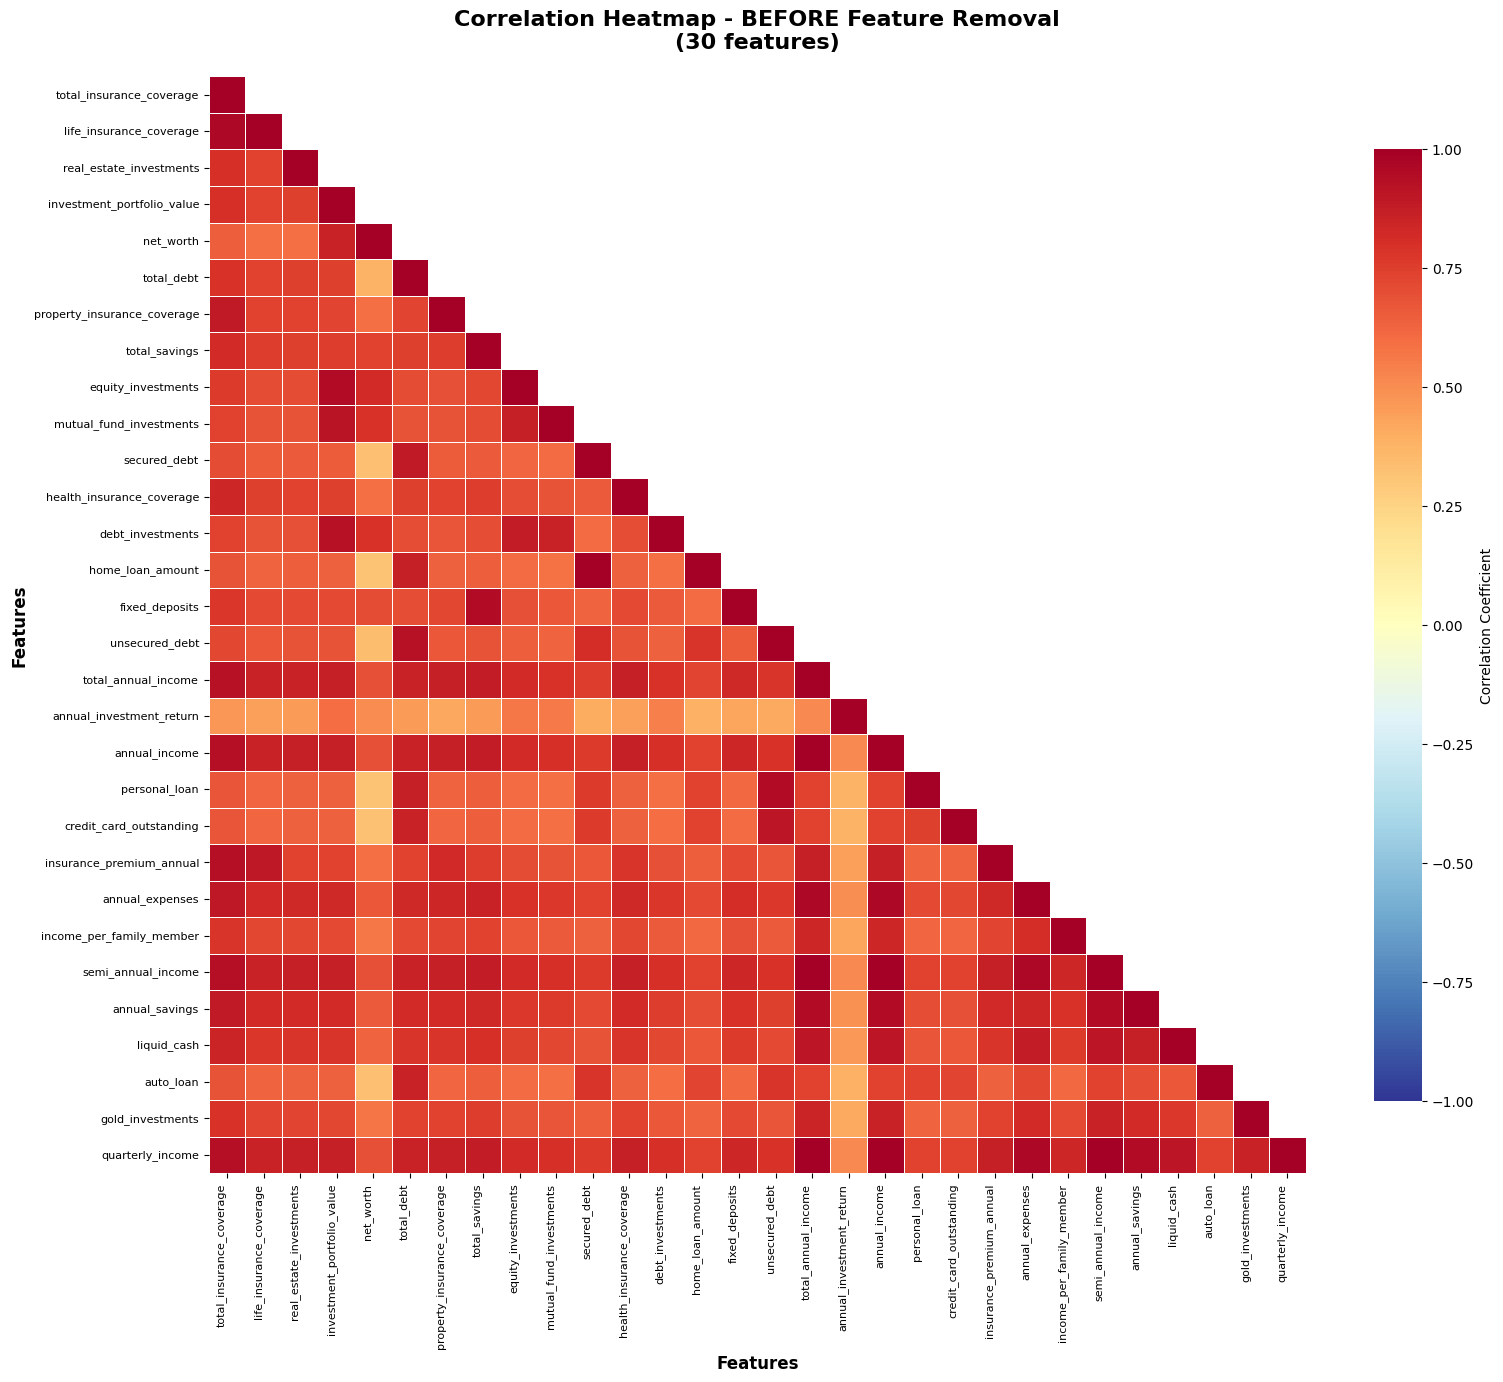


✓ Correlation heatmap plotted successfully!


In [210]:
# Step 4: Visualize Correlation Matrix BEFORE Feature Removal
def plot_correlation_heatmap_before(corr_matrix, top_n=30, title_suffix="BEFORE"):
    """
    Plot correlation heatmap BEFORE removing highly correlated features.
    
    Args:
        corr_matrix: Correlation matrix
        top_n: Number of features to display (based on variance)
        title_suffix: Suffix for the title
    """
    print(f"\n{'='*100}")
    print(f"CORRELATION HEATMAP - {title_suffix} FEATURE REMOVAL")
    print(f"{'='*100}")
    
    # Get top N features by variance (more informative)
    if len(corr_matrix.columns) > top_n:
        feature_variance = X_train[corr_matrix.columns].var().sort_values(ascending=False)
        top_features = feature_variance.head(top_n).index.tolist()
        corr_subset = corr_matrix.loc[top_features, top_features]
        print(f"\n✓ Displaying top {top_n} features by variance (out of {len(corr_matrix.columns)} total)")
    else:
        corr_subset = corr_matrix
        print(f"\n✓ Displaying all {len(corr_matrix.columns)} features")
    
    # Create figure
    fig, ax = plt.subplots(figsize=(16, 14))
    
    # Create mask for upper triangle
    mask = np.triu(np.ones_like(corr_subset, dtype=bool), k=1)
    
    # Plot heatmap
    sns.heatmap(
        corr_subset, 
        mask=mask,
        annot=False, 
        cmap='RdYlBu_r', 
        center=0,
        vmin=-1, 
        vmax=1,
        square=True, 
        linewidths=0.5, 
        cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"},
        ax=ax
    )
    
    plt.title(f'Correlation Heatmap - {title_suffix} Feature Removal\n({len(corr_subset.columns)} features)', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Features', fontsize=12, fontweight='bold')
    plt.ylabel('Features', fontsize=12, fontweight='bold')
    plt.xticks(rotation=90, ha='right', fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Correlation heatmap plotted successfully!")

# Plot correlation heatmap BEFORE removal
plot_correlation_heatmap_before(corr_matrix_before, top_n=30, title_suffix="BEFORE")

In [211]:
# Step 5: Remove Highly Correlated Features
def remove_correlated_features(X_train, X_val, X_test, features_to_drop, numerical_cols, categorical_cols):
    """
    Remove highly correlated features from all datasets.
    
    Args:
        X_train, X_val, X_test: Feature datasets
        features_to_drop: List of features to remove
        numerical_cols: List of numerical columns
        categorical_cols: List of categorical columns
    
    Returns:
        Updated datasets and column lists
    """
    if not features_to_drop:
        print(f"\n✅ No features to drop based on correlation threshold.")
        return X_train, X_val, X_test, numerical_cols, categorical_cols
    
    print(f"\n{'='*100}")
    print(f"REMOVING HIGHLY CORRELATED FEATURES")
    print(f"{'='*100}")
    
    print(f"\n✓ Removing {len(features_to_drop)} highly correlated features from all datasets...")
    
    # Store original shape
    orig_shape = X_train.shape[1]
    
    # Drop features
    X_train = X_train.drop(columns=features_to_drop)
    X_val = X_val.drop(columns=features_to_drop)
    X_test = X_test.drop(columns=features_to_drop)
    
    # Update column lists
    numerical_cols = [col for col in numerical_cols if col not in features_to_drop]
    categorical_cols = [col for col in categorical_cols if col not in features_to_drop]
    
    print(f"\n📊 Feature Removal Summary:")
    print(f"  Original features: {orig_shape}")
    print(f"  Features removed: {len(features_to_drop)}")
    print(f"  Remaining features: {X_train.shape[1]}")
    print(f"  Reduction: {(len(features_to_drop)/orig_shape)*100:.2f}%")
    
    print(f"\n  Updated feature counts:")
    print(f"  • Numerical features: {len(numerical_cols)}")
    print(f"  • Categorical features: {len(categorical_cols)}")
    
    print(f"\n✓ Highly correlated features removed successfully!")
    
    return X_train, X_val, X_test, numerical_cols, categorical_cols

# Execute feature removal
X_train, X_val, X_test, numerical_cols, categorical_cols = remove_correlated_features(
    X_train, X_val, X_test, corr_features_to_drop, numerical_cols, categorical_cols
)


REMOVING HIGHLY CORRELATED FEATURES

✓ Removing 34 highly correlated features from all datasets...

📊 Feature Removal Summary:
  Original features: 106
  Features removed: 34
  Remaining features: 72
  Reduction: 32.08%

  Updated feature counts:
  • Numerical features: 67
  • Categorical features: 5

✓ Highly correlated features removed successfully!


In [212]:
# Step 6: Correlation Analysis AFTER Feature Removal
def analyze_correlations_after_removal(X_train, numerical_cols, threshold=0.9):
    """
    Analyze correlations AFTER removing highly correlated features.
    This verifies that no highly correlated pairs remain.
    
    Args:
        X_train: Training features (after removal)
        numerical_cols: List of numerical columns (after removal)
        threshold: Correlation threshold
    
    Returns:
        corr_matrix: Updated correlation matrix
    """
    print(f"\n{'='*100}")
    print(f"CORRELATION ANALYSIS - AFTER FEATURE REMOVAL")
    print(f"{'='*100}")
    
    print(f"\n✓ Calculating correlation matrix for {len(numerical_cols)} remaining numerical features...")
    corr_matrix = X_train[numerical_cols].corr()
    
    # Check if any high correlations remain
    high_corr_count = 0
    remaining_high_corr = []
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_val = abs(corr_matrix.iloc[i, j])
            if corr_val > threshold:
                feat1 = corr_matrix.columns[i]
                feat2 = corr_matrix.columns[j]
                remaining_high_corr.append((feat1, feat2, corr_matrix.iloc[i, j]))
                high_corr_count += 1
    
    print(f"\n📊 Verification Results:")
    print(f"  Remaining numerical features: {len(numerical_cols)}")
    print(f"  Correlation threshold: {threshold}")
    print(f"  High correlation pairs remaining: {high_corr_count}")
    
    if remaining_high_corr:
        print(f"\n⚠️  WARNING: Some highly correlated pairs still remain:")
        for feat1, feat2, corr in remaining_high_corr:
            print(f"    • {feat1} <-> {feat2}: {corr:.6f}")
    else:
        print(f"\n✅ SUCCESS: No highly correlated feature pairs remain (|correlation| > {threshold})")
        print(f"  All feature correlations are now below the threshold!")
    
    # Find maximum correlation (excluding diagonal)
    corr_values = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_values.append(abs(corr_matrix.iloc[i, j]))
    
    if corr_values:
        max_corr = max(corr_values)
        print(f"\n  Maximum absolute correlation (after removal): {max_corr:.6f}")
    
    return corr_matrix

# Execute correlation analysis AFTER removal
corr_matrix_after = analyze_correlations_after_removal(X_train, numerical_cols, threshold=0.9)


CORRELATION ANALYSIS - AFTER FEATURE REMOVAL

✓ Calculating correlation matrix for 67 remaining numerical features...

📊 Verification Results:
  Remaining numerical features: 67
  Correlation threshold: 0.9
  High correlation pairs remaining: 0

✅ SUCCESS: No highly correlated feature pairs remain (|correlation| > 0.9)
  All feature correlations are now below the threshold!

  Maximum absolute correlation (after removal): 0.898272

📊 Verification Results:
  Remaining numerical features: 67
  Correlation threshold: 0.9
  High correlation pairs remaining: 0

✅ SUCCESS: No highly correlated feature pairs remain (|correlation| > 0.9)
  All feature correlations are now below the threshold!

  Maximum absolute correlation (after removal): 0.898272



CORRELATION HEATMAP - AFTER FEATURE REMOVAL

✓ Displaying top 30 features by variance (out of 67 total)


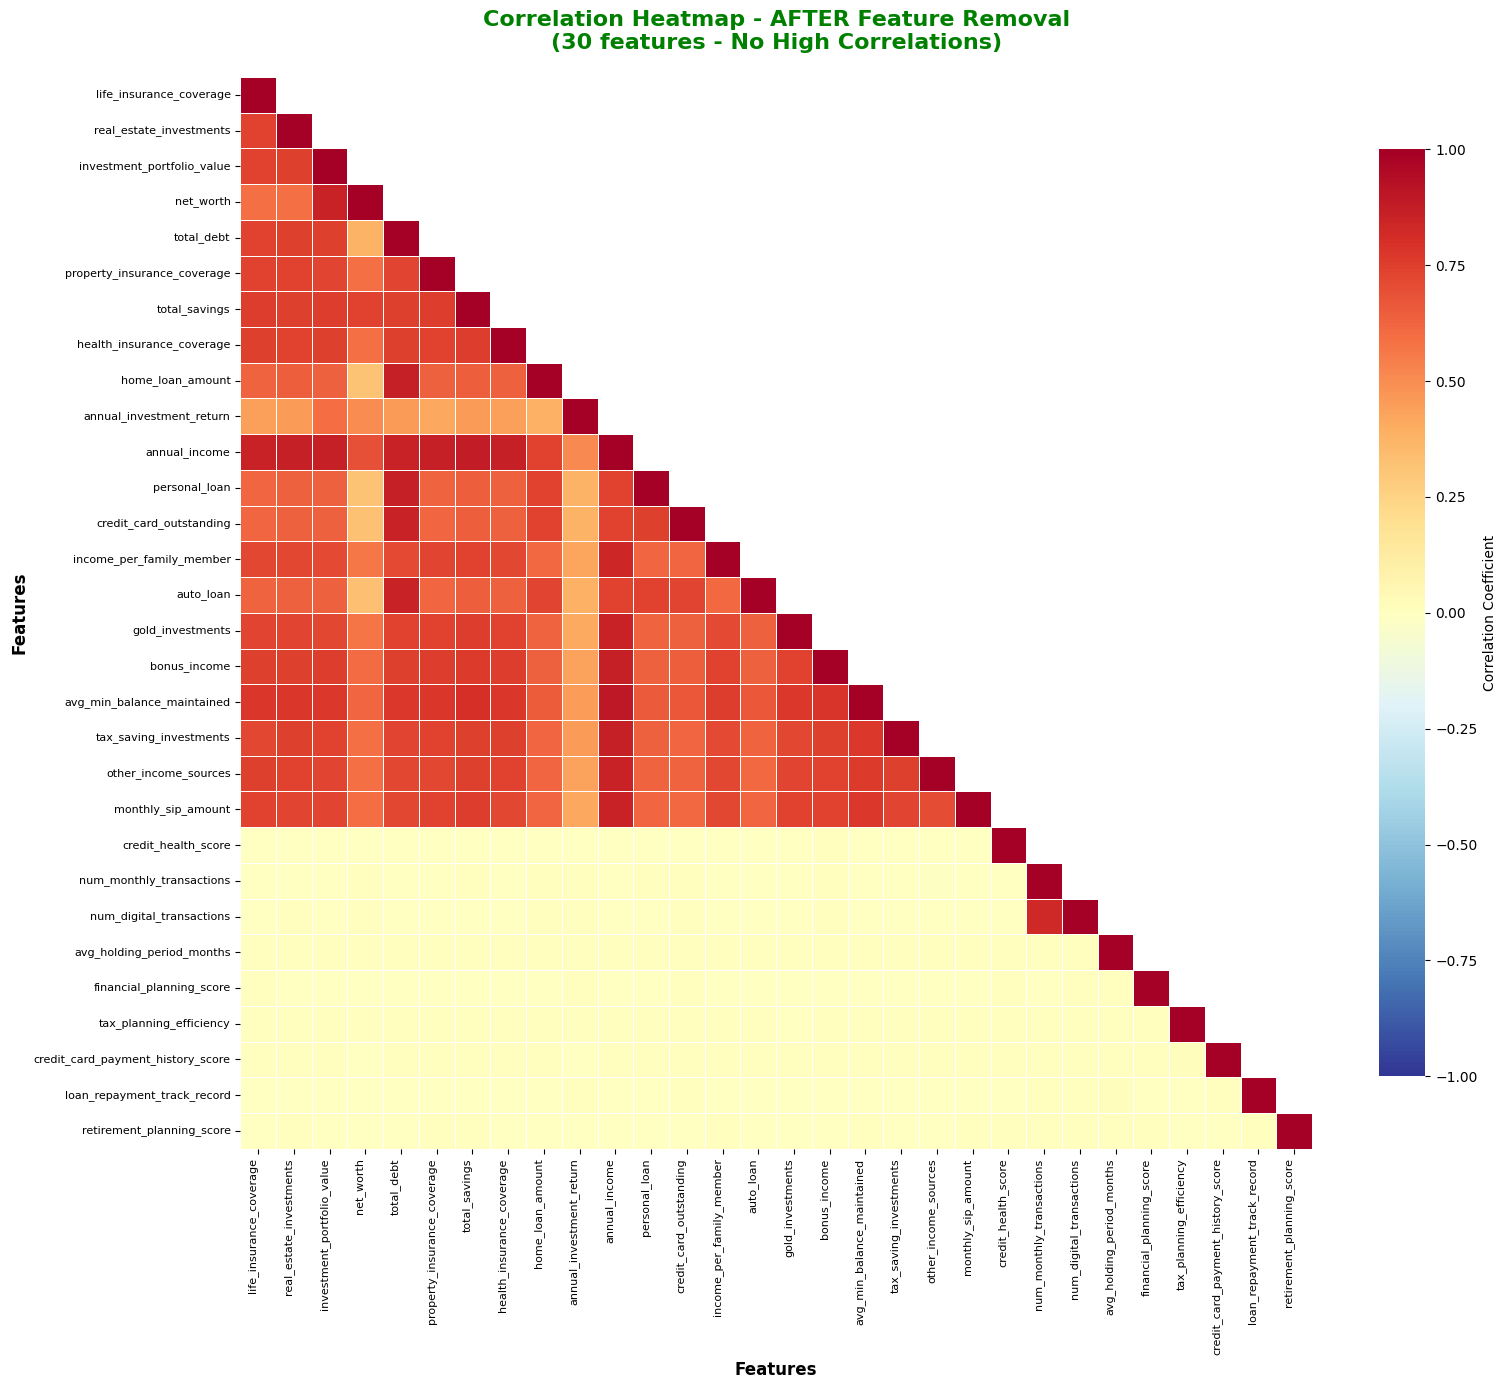


✓ Correlation heatmap (after removal) plotted successfully!
  Note: Heatmap should show reduced red/dark blue colors compared to 'BEFORE' plot


In [213]:
# Step 7: Visualize Correlation Matrix AFTER Feature Removal
def plot_correlation_heatmap_after(corr_matrix, top_n=30):
    """
    Plot correlation heatmap AFTER removing highly correlated features.
    This visualization should show no red blocks (high correlations).
    
    Args:
        corr_matrix: Correlation matrix (after removal)
        top_n: Number of features to display
    """
    print(f"\n{'='*100}")
    print(f"CORRELATION HEATMAP - AFTER FEATURE REMOVAL")
    print(f"{'='*100}")
    
    # Get top N features by variance
    if len(corr_matrix.columns) > top_n:
        feature_variance = X_train[corr_matrix.columns].var().sort_values(ascending=False)
        top_features = feature_variance.head(top_n).index.tolist()
        corr_subset = corr_matrix.loc[top_features, top_features]
        print(f"\n✓ Displaying top {top_n} features by variance (out of {len(corr_matrix.columns)} total)")
    else:
        corr_subset = corr_matrix
        print(f"\n✓ Displaying all {len(corr_matrix.columns)} features")
    
    # Create figure
    fig, ax = plt.subplots(figsize=(16, 14))
    
    # Create mask for upper triangle
    mask = np.triu(np.ones_like(corr_subset, dtype=bool), k=1)
    
    # Plot heatmap
    sns.heatmap(
        corr_subset, 
        mask=mask,
        annot=False, 
        cmap='RdYlBu_r', 
        center=0,
        vmin=-1, 
        vmax=1,
        square=True, 
        linewidths=0.5, 
        cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"},
        ax=ax
    )
    
    plt.title(f'Correlation Heatmap - AFTER Feature Removal\n({len(corr_subset.columns)} features - No High Correlations)', 
              fontsize=16, fontweight='bold', pad=20, color='green')
    plt.xlabel('Features', fontsize=12, fontweight='bold')
    plt.ylabel('Features', fontsize=12, fontweight='bold')
    plt.xticks(rotation=90, ha='right', fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Correlation heatmap (after removal) plotted successfully!")
    print(f"  Note: Heatmap should show reduced red/dark blue colors compared to 'BEFORE' plot")

# Plot correlation heatmap AFTER removal
plot_correlation_heatmap_after(corr_matrix_after, top_n=30)

In [214]:
# Step 8: Outlier Detection and Analysis
def detect_outliers(X_train, numerical_cols, method='IQR'):
    """
    Detect outliers in numerical features using IQR method.
    
    NOTE: Dataset has been updated with NEGATIVE OUTLIERS REMOVED.
    This function detects remaining outliers (if any) for quality assurance.
    
    Args:
        X_train: Training features
        numerical_cols: List of numerical columns
        method: Outlier detection method ('IQR' or 'Z-score')
    
    Returns:
        dict: Dictionary with outlier information per feature
    """
    print(f"\n{'='*100}")
    print(f"OUTLIER DETECTION - {method.upper()} METHOD")
    print(f"{'='*100}")
    print(f"\n📝 NOTE: Dataset has been pre-processed with negative outliers removed.")
    print(f"         This analysis detects any remaining outliers for quality assurance.")
    
    outlier_info = {}
    
    for col in numerical_cols:
        if method == 'IQR':
            Q1 = X_train[col].quantile(0.25)
            Q3 = X_train[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers = X_train[(X_train[col] < lower_bound) | (X_train[col] > upper_bound)][col]
            outlier_count = len(outliers)
            outlier_pct = (outlier_count / len(X_train)) * 100
            
            outlier_info[col] = {
                'count': outlier_count,
                'percentage': outlier_pct,
                'lower_bound': lower_bound,
                'upper_bound': upper_bound
            }
    
    # Find features with most outliers
    sorted_outliers = sorted(outlier_info.items(), key=lambda x: x[1]['count'], reverse=True)
    
    print(f"\n📊 Outlier Detection Summary:")
    print(f"  Total numerical features: {len(numerical_cols)}")
    print(f"  Method: {method}")
    
    # Show top 10 features with most outliers
    print(f"\n🔍 Top 10 Features with Most Outliers:")
    print(f"  {'Feature':<40} {'Outliers':>10} {'Percentage':>12} {'Lower Bound':>15} {'Upper Bound':>15}")
    print(f"  {'-'*40} {'-'*10} {'-'*12} {'-'*15} {'-'*15}")
    
    for feat, info in sorted_outliers[:10]:
        print(f"  {feat:<40} {info['count']:>10} {info['percentage']:>11.2f}% {info['lower_bound']:>15.2f} {info['upper_bound']:>15.2f}")
    
    # Summary statistics
    total_outliers = sum([info['count'] for info in outlier_info.values()])
    avg_outlier_pct = np.mean([info['percentage'] for info in outlier_info.values()])
    
    print(f"\n  Total outliers across all features: {total_outliers:,}")
    print(f"  Average outlier percentage: {avg_outlier_pct:.2f}%")
    
    return outlier_info

# Execute outlier detection
outlier_info = detect_outliers(X_train, numerical_cols, method='IQR')


OUTLIER DETECTION - IQR METHOD

📝 NOTE: Dataset has been pre-processed with negative outliers removed.
         This analysis detects any remaining outliers for quality assurance.

📊 Outlier Detection Summary:
  Total numerical features: 67
  Method: IQR

🔍 Top 10 Features with Most Outliers:
  Feature                                    Outliers   Percentage     Lower Bound     Upper Bound
  ---------------------------------------- ---------- ------------ --------------- ---------------
  annual_income                                 15475       17.69%      -688093.63      2718641.12
  annual_investment_return                      11943       13.65%     -1771276.13      2860392.30
  avg_min_balance_maintained                    11814       13.50%      -134604.94       325951.93
  total_savings                                 11677       13.35%     -6567500.30     15396139.54
  net_worth                                     11333       12.95%    -14116905.66     26148747.85
  property_i


FEATURE DISTRIBUTION ANALYSIS BY CLASS

📊 Top 15 Most Discriminative Features (largest mean difference between classes):
  Rank   Feature                                  Mean Difference
  ------ ---------------------------------------- ---------------
  1      life_insurance_coverage                  52252807.319588
  2      investment_portfolio_value               41105521.050629
  3      real_estate_investments                  39361228.948336
  4      net_worth                                33152071.300622
  5      total_debt                               30186066.012151
  6      property_insurance_coverage              26247537.380955
  7      total_savings                            22232616.262162
  8      health_insurance_coverage                13070582.371804
  9      home_loan_amount                         10532936.289851
  10     annual_income                             5236578.671751
  11     annual_investment_return                  3099086.582100
  12     personal_lo

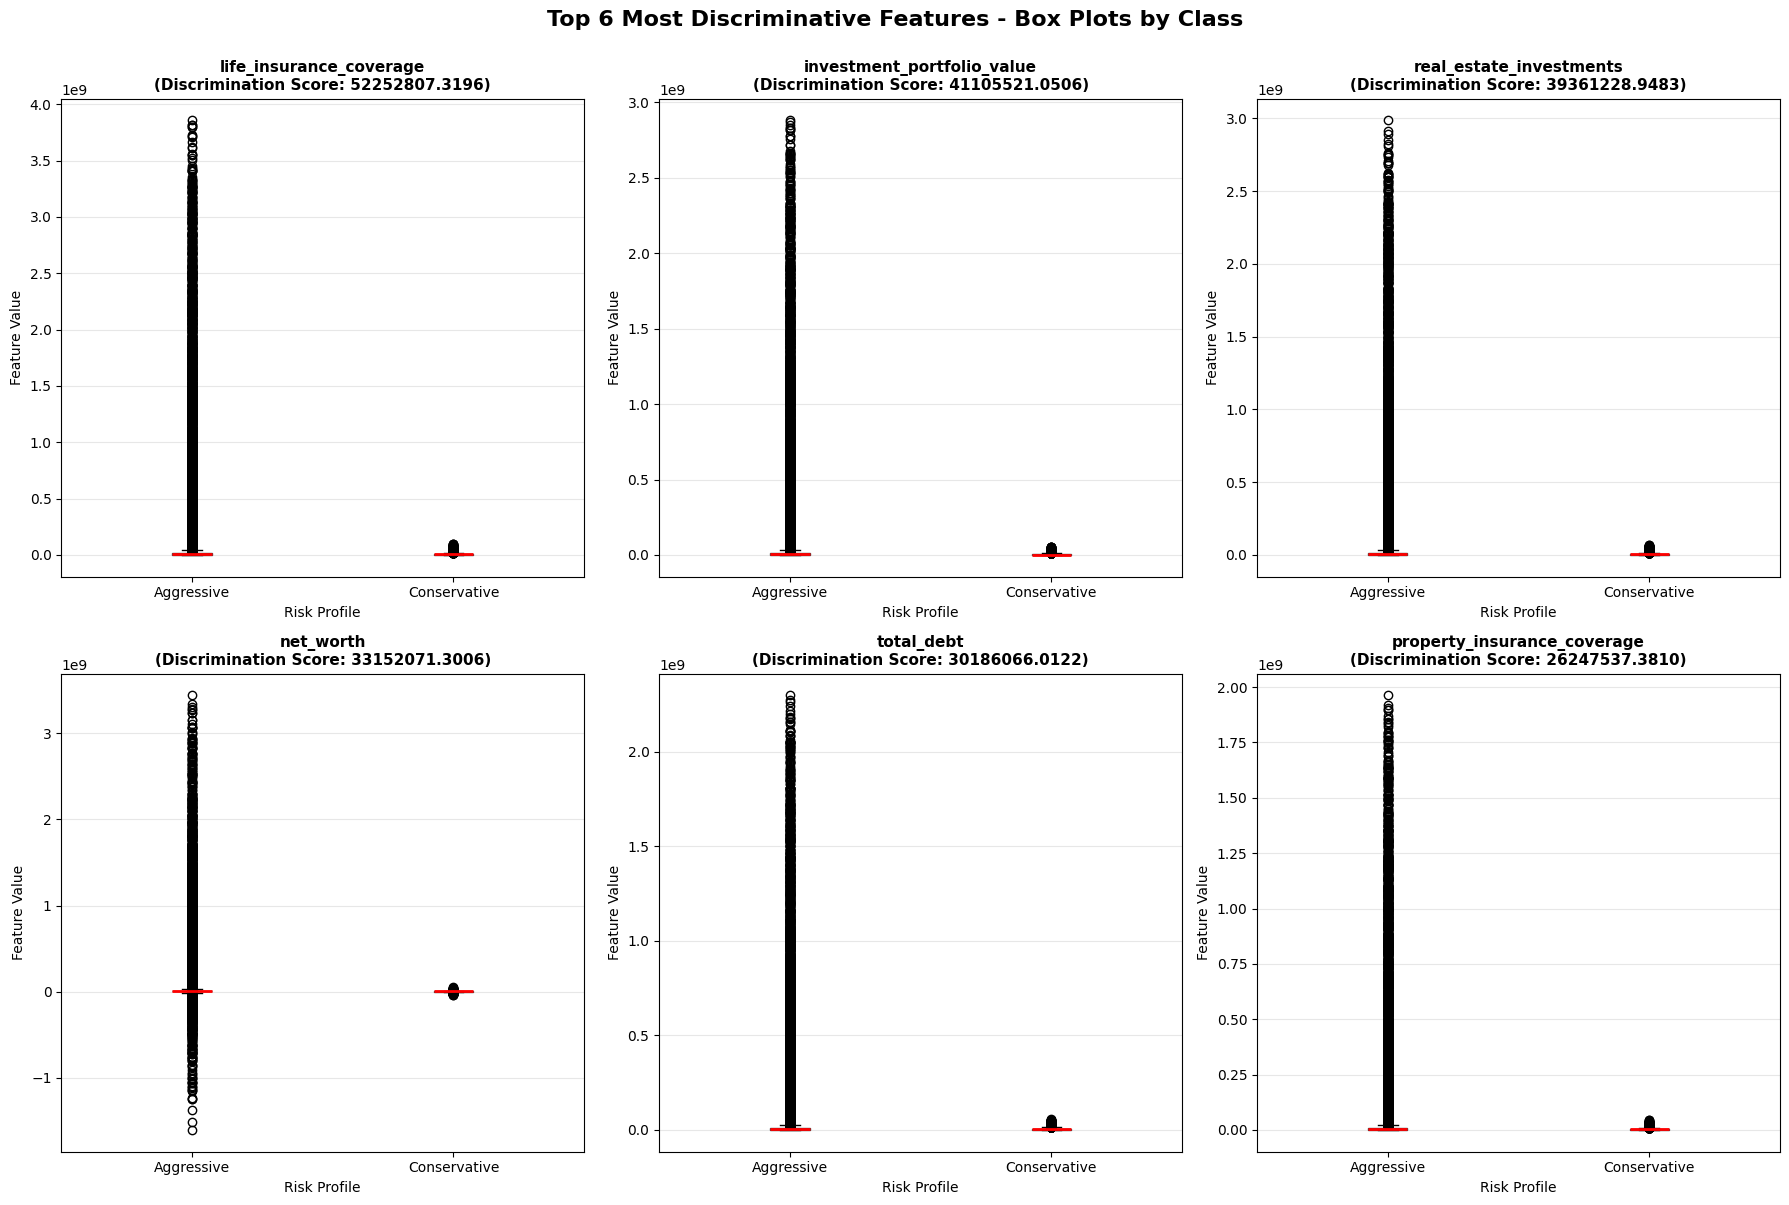


✓ Feature distribution analysis completed!


In [215]:
# Step 9: Feature Distribution Analysis by Target Class
def analyze_feature_distributions_by_class(X_train, y_train, numerical_cols, le_target, top_n=10):
    """
    Analyze how numerical features are distributed across different target classes.
    This helps identify discriminative features.
    
    Args:
        X_train: Training features
        y_train: Training target
        numerical_cols: List of numerical columns
        le_target: Label encoder for target
        top_n: Number of top features to visualize
    
    Returns:
        Feature discrimination scores
    """
    print(f"\n{'='*100}")
    print(f"FEATURE DISTRIBUTION ANALYSIS BY CLASS")
    print(f"{'='*100}")
    
    # Calculate mean difference between classes for each feature
    discrimination_scores = {}
    
    for col in numerical_cols:
        class_means = []
        for cls_id in range(len(le_target.classes_)):
            class_data = X_train[y_train == cls_id][col]
            class_means.append(class_data.mean())
        
        # Calculate absolute difference between class means (for binary classification)
        discrimination_score = abs(class_means[0] - class_means[1])
        discrimination_scores[col] = discrimination_score
    
    # Sort by discrimination score
    sorted_features = sorted(discrimination_scores.items(), key=lambda x: x[1], reverse=True)
    
    print(f"\n📊 Top {top_n} Most Discriminative Features (largest mean difference between classes):")
    print(f"  {'Rank':<6} {'Feature':<40} {'Mean Difference':>15}")
    print(f"  {'-'*6} {'-'*40} {'-'*15}")
    
    for i, (feat, score) in enumerate(sorted_features[:top_n], 1):
        print(f"  {i:<6} {feat:<40} {score:>15.6f}")
    
    # Visualize top discriminative features
    print(f"\n  Creating box plots for top {min(6, top_n)} discriminative features...")
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, (feat, score) in enumerate(sorted_features[:6]):
        data_by_class = [X_train[y_train == cls_id][feat].values for cls_id in range(len(le_target.classes_))]
        
        bp = axes[i].boxplot(data_by_class, labels=le_target.classes_, patch_artist=True,
                            boxprops=dict(facecolor='lightblue', alpha=0.7),
                            medianprops=dict(color='red', linewidth=2))
        
        axes[i].set_title(f'{feat}\n(Discrimination Score: {score:.4f})', 
                         fontsize=11, fontweight='bold')
        axes[i].set_ylabel('Feature Value', fontsize=10)
        axes[i].set_xlabel('Risk Profile', fontsize=10)
        axes[i].grid(axis='y', alpha=0.3)
    
    plt.suptitle('Top 6 Most Discriminative Features - Box Plots by Class', 
                fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Feature distribution analysis completed!")
    
    return discrimination_scores

# Execute feature distribution analysis
discrimination_scores = analyze_feature_distributions_by_class(
    X_train, y_train, numerical_cols, le_target, top_n=15
)


EXPLORATORY DATA ANALYSIS - VISUALIZATIONS

1. Creating correlation heatmap...


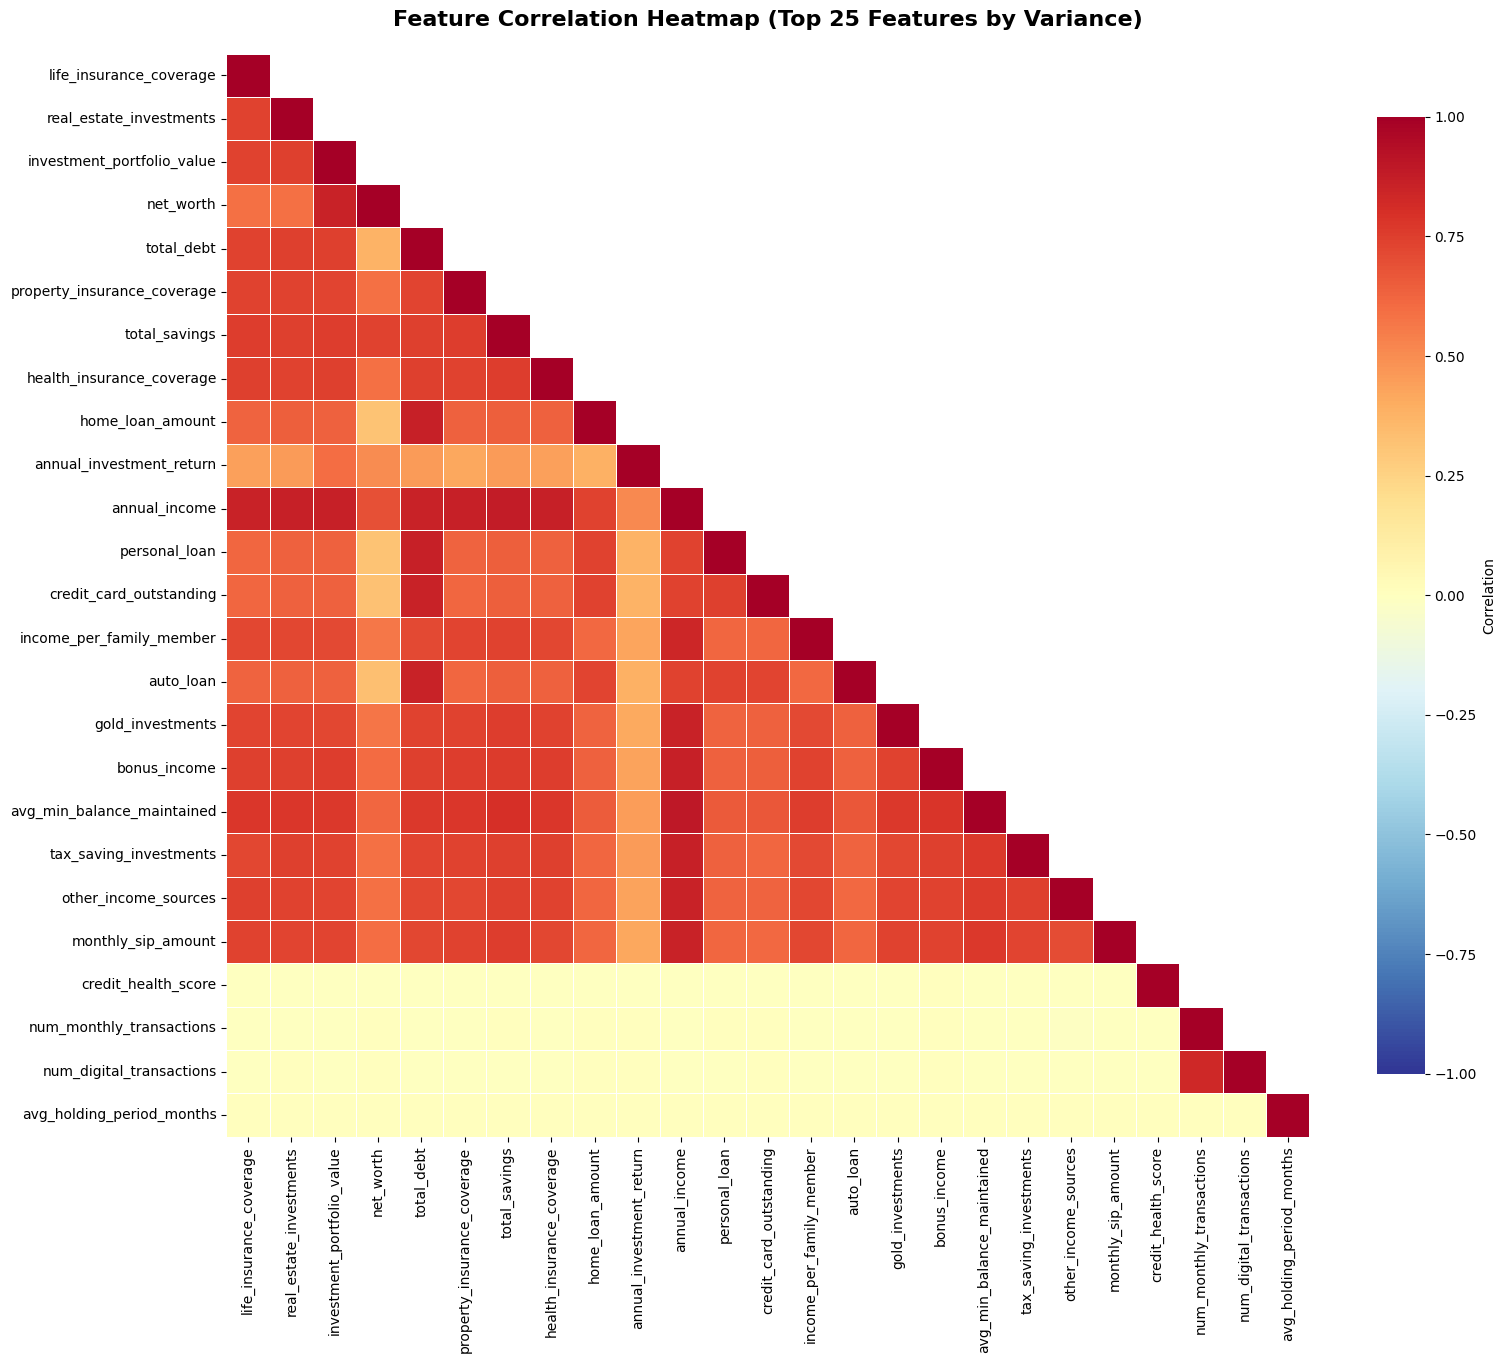


2. Creating feature distribution plots...


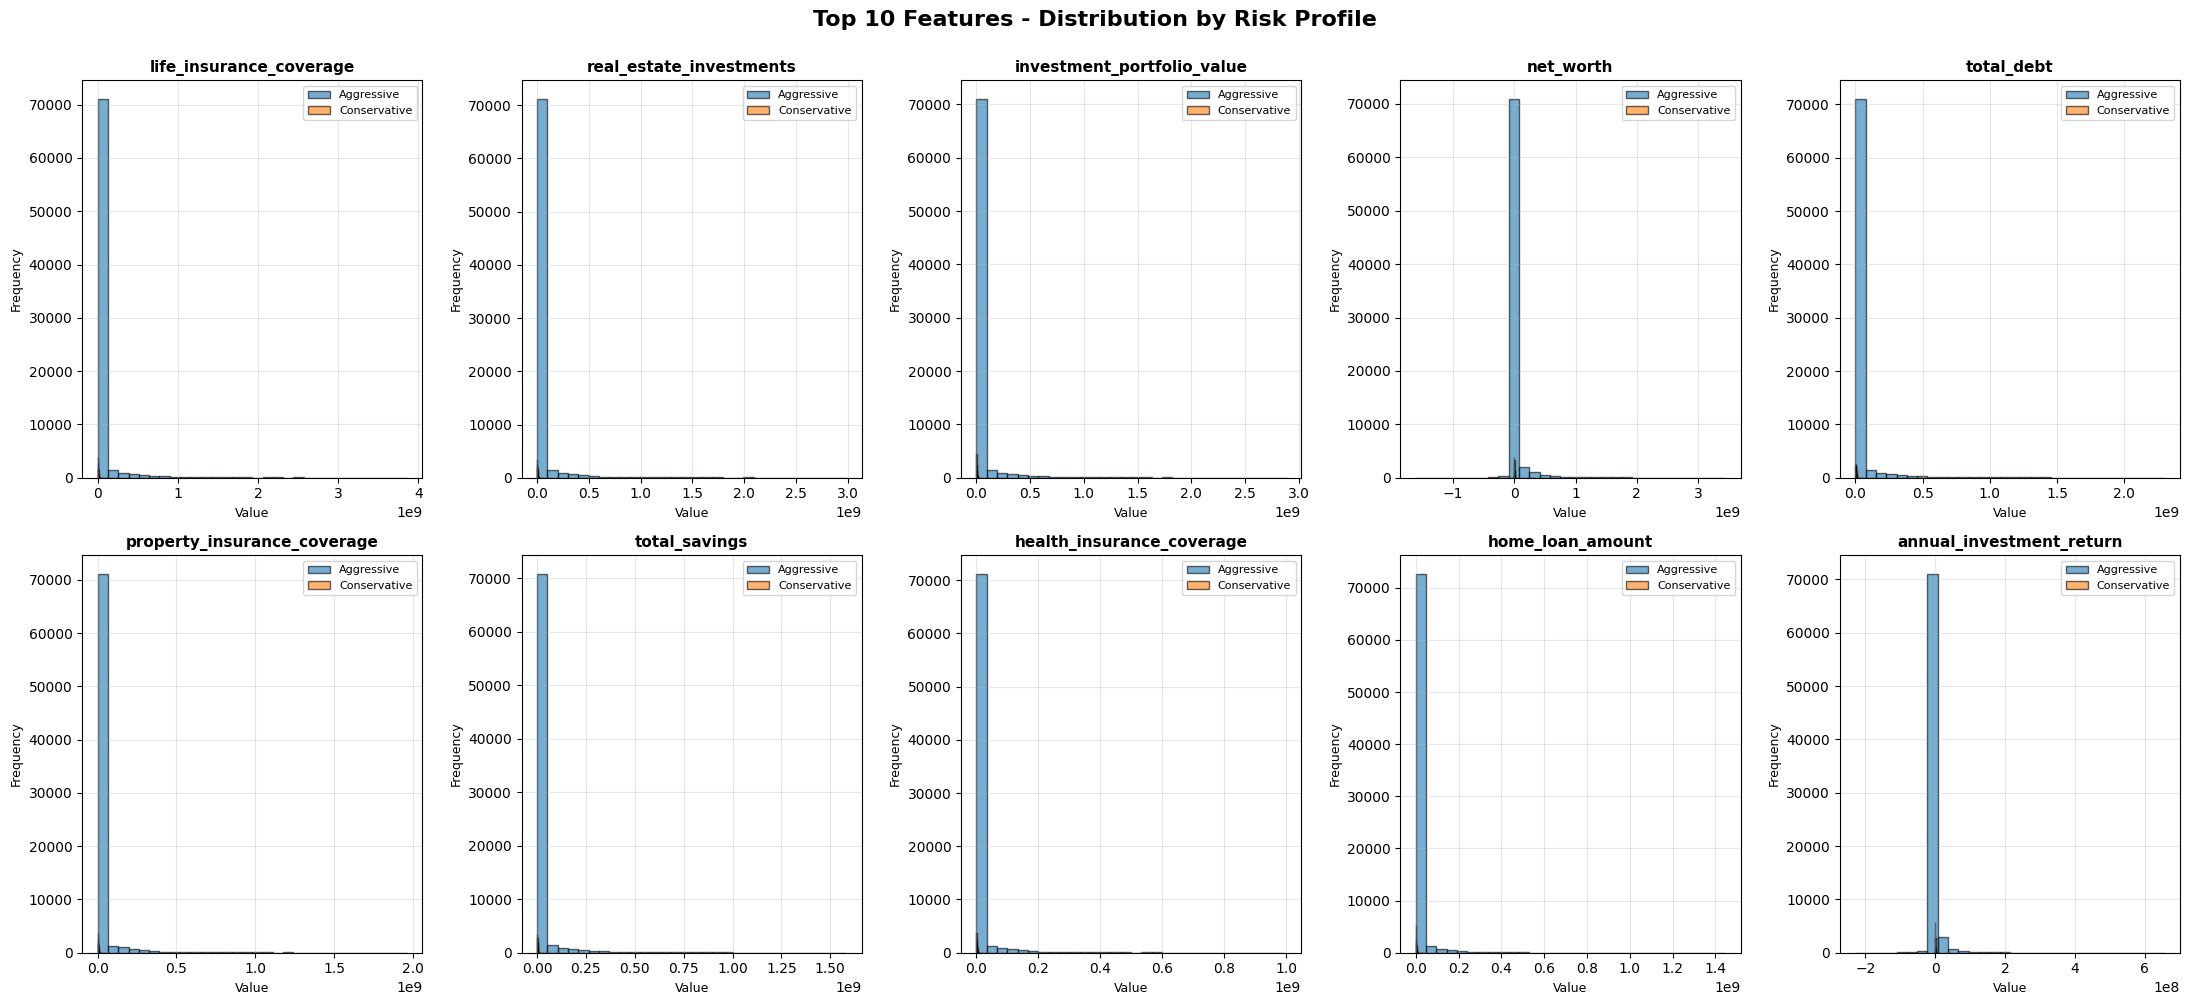


3. Creating box plots for outlier detection...


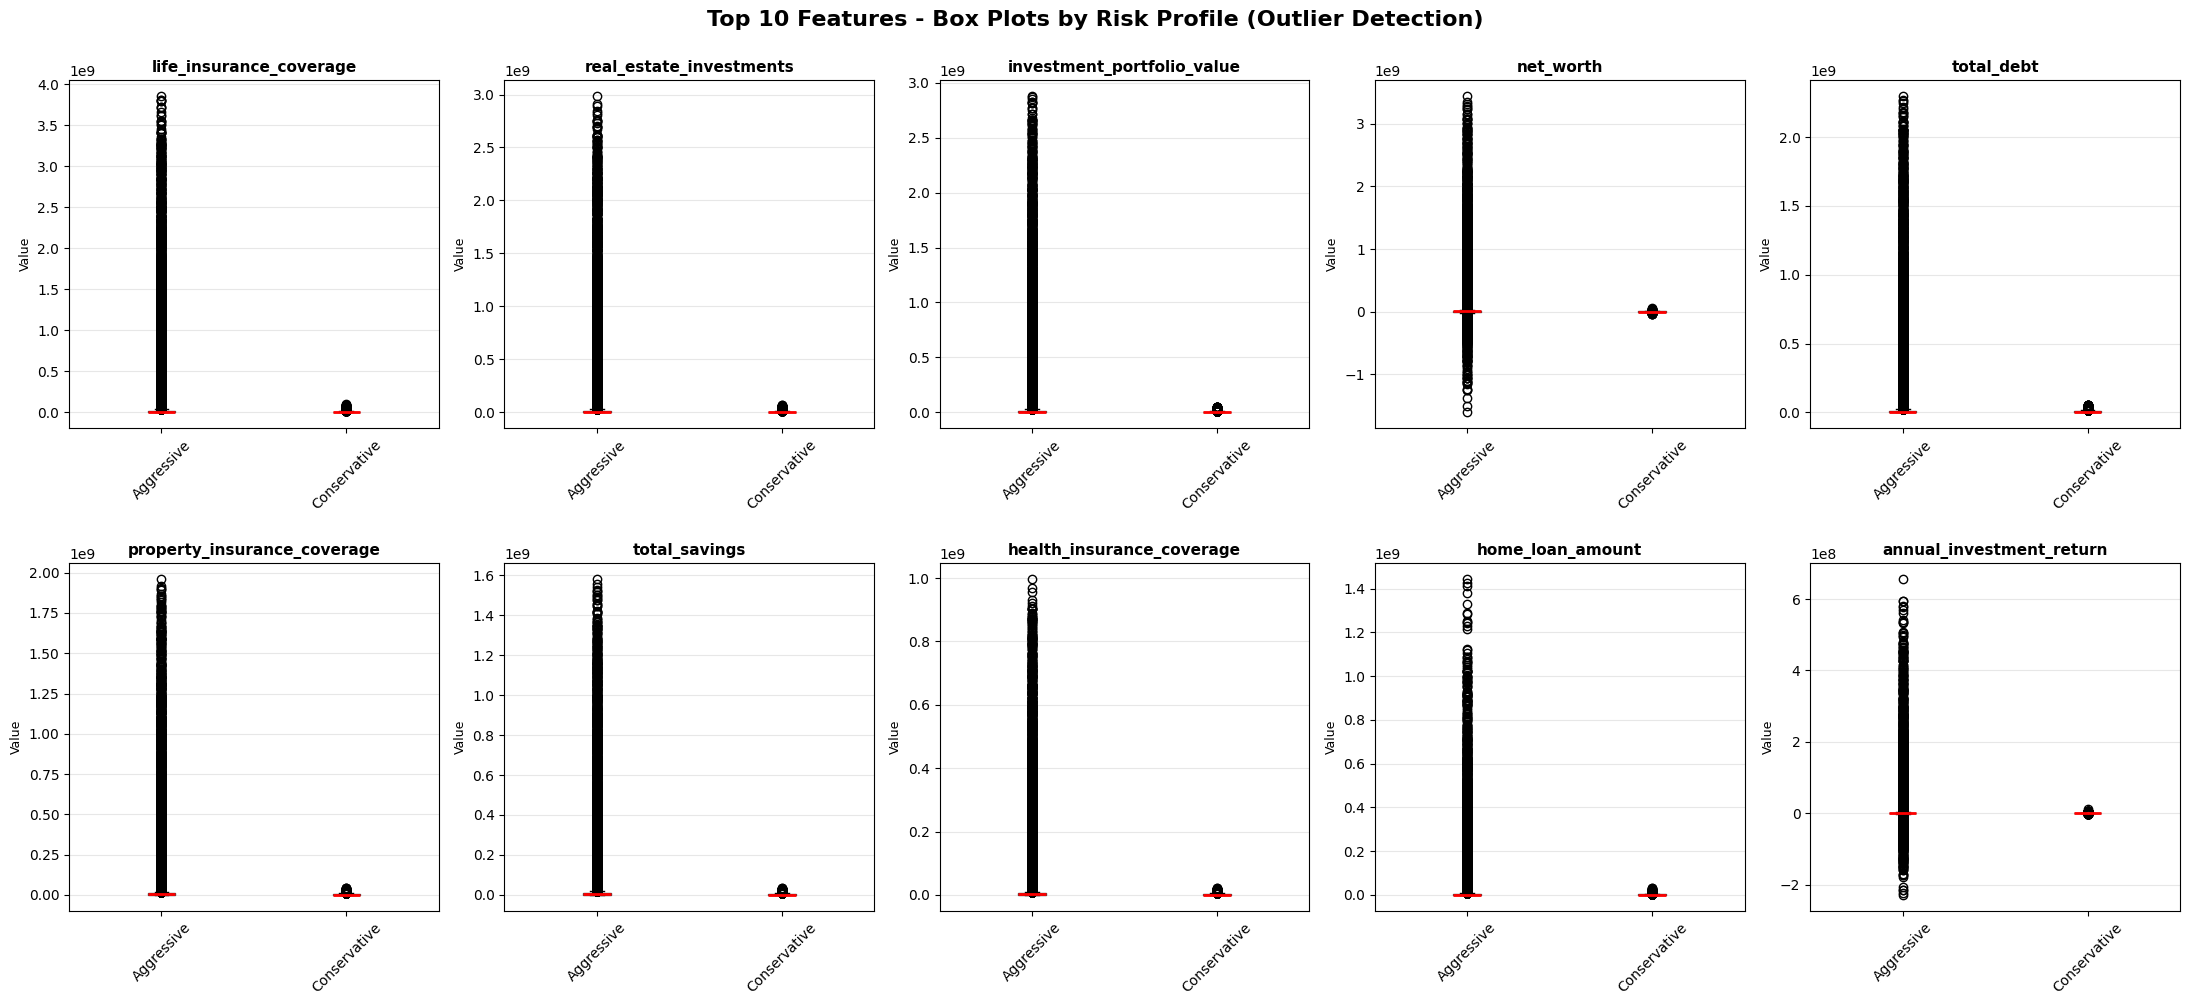


4. Creating feature variance analysis...


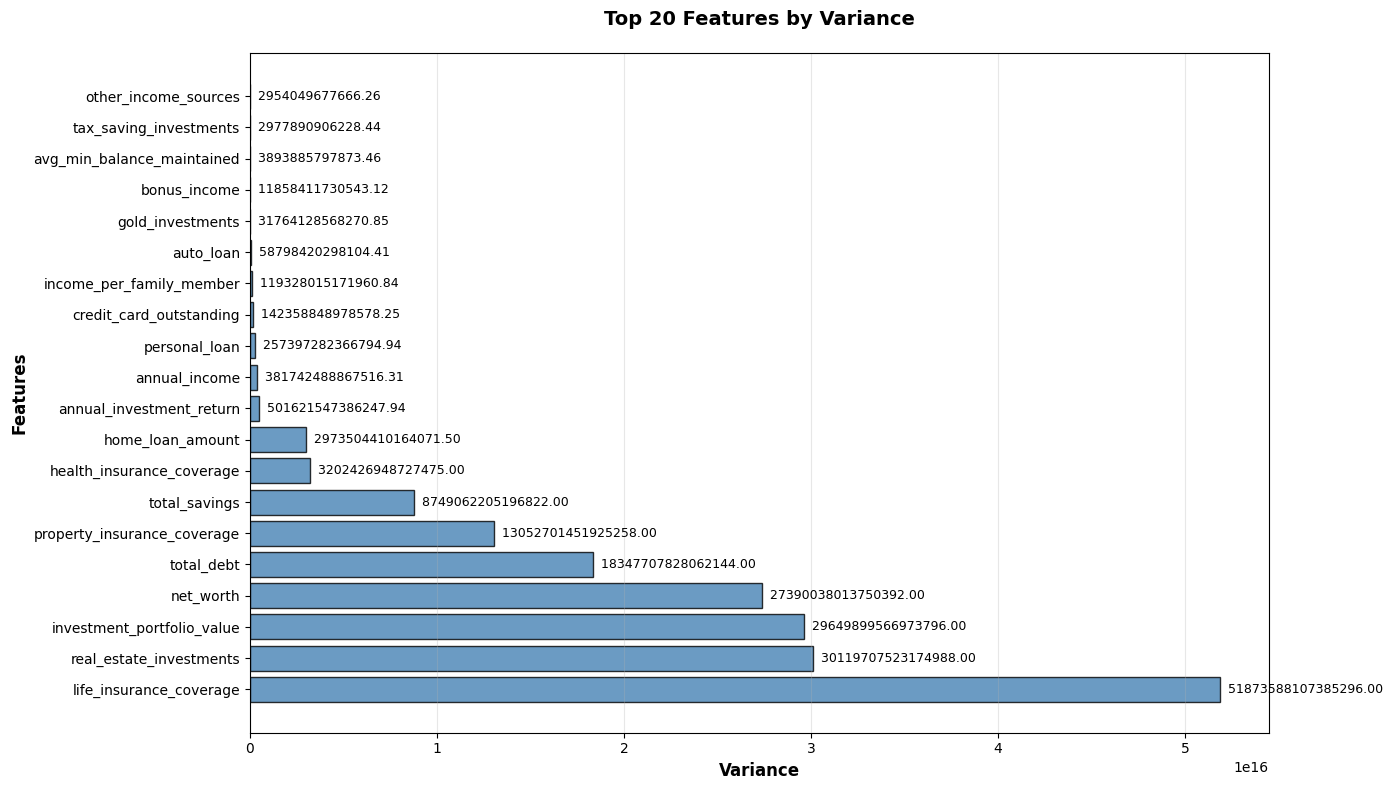


✓ All EDA visualizations completed!


In [216]:
# EDA Visualizations
def plot_eda_visualizations(X_train, y_train, numerical_cols, le_target):
    """
    Create comprehensive EDA visualizations.
    """
    print("\n" + "="*100)
    print("EXPLORATORY DATA ANALYSIS - VISUALIZATIONS")
    print("="*100)
    
    # 1. Correlation Heatmap
    print("\n1. Creating correlation heatmap...")
    plt.figure(figsize=(16, 14))
    
    # Select top 25 features by variance for better visualization
    feature_variance = X_train[numerical_cols].var().sort_values(ascending=False)
    top_features = feature_variance.head(25).index.tolist()
    corr_matrix = X_train[top_features].corr()
    
    # Create mask for upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
    
    sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='RdYlBu_r', center=0, 
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8, "label": "Correlation"},
                vmin=-1, vmax=1)
    plt.title('Feature Correlation Heatmap (Top 25 Features by Variance)', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    # 2. Feature Distribution by Target
    print("\n2. Creating feature distribution plots...")
    top_10_features = feature_variance.head(10).index.tolist()
    
    fig, axes = plt.subplots(2, 5, figsize=(22, 10))
    axes = axes.ravel()
    
    for idx, feature in enumerate(top_10_features):
        for class_id in range(len(le_target.classes_)):
            class_name = le_target.classes_[class_id]
            class_data = X_train[y_train == class_id][feature]
            axes[idx].hist(class_data, bins=30, alpha=0.6, label=class_name, edgecolor='black')
        
        axes[idx].set_title(f'{feature}', fontsize=11, fontweight='bold')
        axes[idx].set_xlabel('Value', fontsize=9)
        axes[idx].set_ylabel('Frequency', fontsize=9)
        axes[idx].legend(fontsize=8)
        axes[idx].grid(alpha=0.3)
    
    plt.suptitle('Top 10 Features - Distribution by Risk Profile', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()
    
    # 3. Box plots for top features
    print("\n3. Creating box plots for outlier detection...")
    fig, axes = plt.subplots(2, 5, figsize=(22, 10))
    axes = axes.ravel()
    
    for idx, feature in enumerate(top_10_features):
        data_to_plot = [X_train[y_train == i][feature] for i in range(len(le_target.classes_))]
        bp = axes[idx].boxplot(data_to_plot, labels=le_target.classes_, patch_artist=True,
                               boxprops=dict(facecolor='lightblue', alpha=0.7),
                               medianprops=dict(color='red', linewidth=2))
        axes[idx].set_title(f'{feature}', fontsize=11, fontweight='bold')
        axes[idx].set_ylabel('Value', fontsize=9)
        axes[idx].grid(axis='y', alpha=0.3)
        axes[idx].tick_params(axis='x', rotation=45)
    
    plt.suptitle('Top 10 Features - Box Plots by Risk Profile (Outlier Detection)', 
                 fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()
    
    # 4. Feature Variance Analysis
    print("\n4. Creating feature variance analysis...")
    top_20_variance = feature_variance.head(20)
    
    plt.figure(figsize=(14, 8))
    bars = plt.barh(range(len(top_20_variance)), top_20_variance.values, color='steelblue', alpha=0.8, edgecolor='black')
    plt.yticks(range(len(top_20_variance)), top_20_variance.index)
    plt.xlabel('Variance', fontsize=12, fontweight='bold')
    plt.ylabel('Features', fontsize=12, fontweight='bold')
    plt.title('Top 20 Features by Variance', fontsize=14, fontweight='bold', pad=20)
    plt.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (bar, value) in enumerate(zip(bars, top_20_variance.values)):
        plt.text(value, i, f'  {value:.2f}', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ All EDA visualizations completed!")

# Execute EDA visualizations
plot_eda_visualizations(X_train, y_train, numerical_cols, le_target)

##### =============================================================
##### 3. FEATURE ENGINEERING
##### =============================================================

In [217]:
def engineer_features(X_train, X_val, X_test):
    """
    Create additional engineered features based on available columns.
    
    Args:
        X_train, X_val, X_test: Feature DataFrames
        
    Returns:
        tuple: DataFrames with engineered features
    """
    
    print(f"\n✓ Creating engineered features...")
    
    original_features = X_train.shape[1]
    available_cols = set(X_train.columns)
    
    print(f"\n  Checking available columns for feature engineering...")
    
    # Track which features were created
    created_features = []
    
    for df in [X_train, X_val, X_test]:
        # Income per dependent (if columns exist)
        if 'annual_income' in available_cols and 'dependents' in available_cols:
            df['income_per_dependent'] = df['annual_income'] / (df['dependents'] + 1)
            if 'income_per_dependent' not in created_features:
                created_features.append('income_per_dependent')
        
        # Debt coverage ratio (check for either monthly_income or annual_income)
        if 'monthly_income' in available_cols and 'total_debt' in available_cols:
            df['debt_coverage_ratio'] = df['monthly_income'] / (df['total_debt'] / 12 + 1)
            if 'debt_coverage_ratio' not in created_features:
                created_features.append('debt_coverage_ratio')
        elif 'annual_income' in available_cols and 'total_debt' in available_cols:
            df['debt_coverage_ratio'] = (df['annual_income'] / 12) / (df['total_debt'] / 12 + 1)
            if 'debt_coverage_ratio' not in created_features:
                created_features.append('debt_coverage_ratio')
        
        # Savings rate (check for different column combinations)
        if 'monthly_income' in available_cols and 'monthly_expenses' in available_cols:
            df['savings_rate'] = (df['monthly_income'] - df['monthly_expenses']) / (df['monthly_income'] + 1)
            if 'savings_rate' not in created_features:
                created_features.append('savings_rate')
        elif 'annual_income' in available_cols and 'monthly_expenses' in available_cols:
            df['savings_rate'] = ((df['annual_income'] / 12) - df['monthly_expenses']) / ((df['annual_income'] / 12) + 1)
            if 'savings_rate' not in created_features:
                created_features.append('savings_rate')
        
        # Investment efficiency
        if 'investment_portfolio_value' in available_cols and 'annual_income' in available_cols:
            df['investment_efficiency'] = df['investment_portfolio_value'] / (df['annual_income'] + 1)
            if 'investment_efficiency' not in created_features:
                created_features.append('investment_efficiency')
    
    new_features = len(created_features)
    print(f"\n  • Original features: {original_features}")
    print(f"  • New features created: {new_features}")
    print(f"  • Total features: {X_train.shape[1]}")
    
    if created_features:
        print(f"\n  ✅ Successfully created features:")
        for feat in created_features:
            print(f"    • {feat}")
    else:
        print(f"\n  ⚠️  No new features created - required columns not found")
    
    return X_train, X_val, X_test

In [218]:
X_train, X_val, X_test = engineer_features(X_train, X_val, X_test)


✓ Creating engineered features...

  Checking available columns for feature engineering...

  • Original features: 72
  • New features created: 3
  • Total features: 75

  ✅ Successfully created features:
    • income_per_dependent
    • debt_coverage_ratio
    • investment_efficiency



ENGINEERED FEATURES - VISUALIZATIONS

✓ Visualizing 3 engineered features: ['income_per_dependent', 'debt_coverage_ratio', 'investment_efficiency']


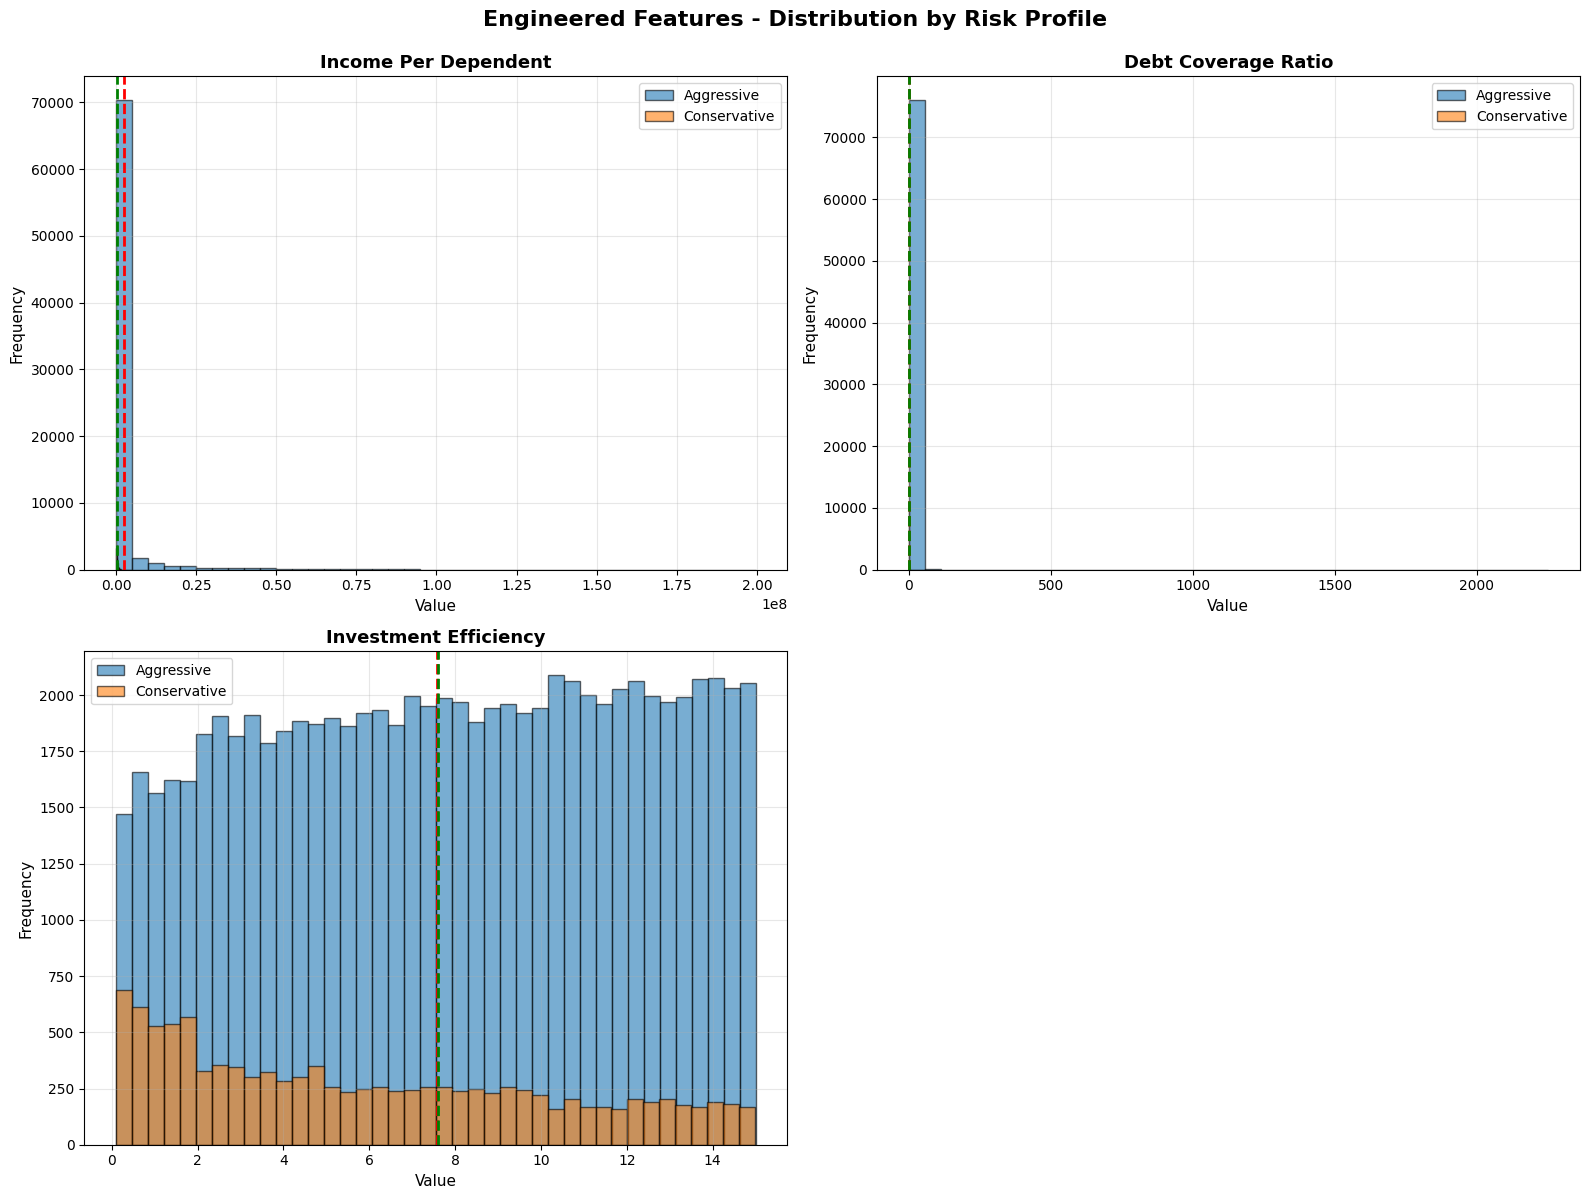

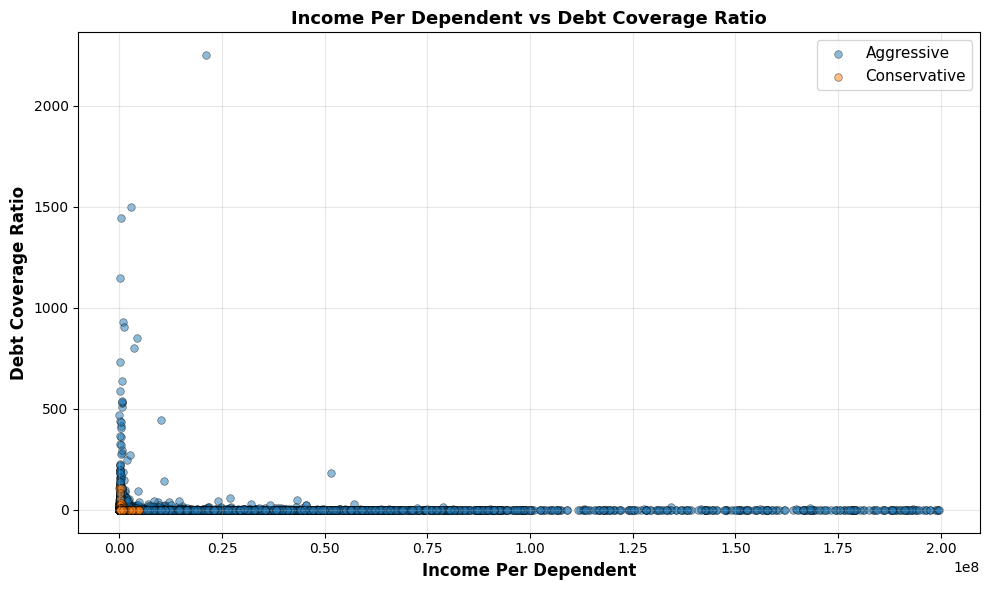


✓ Engineered features visualization completed!


In [219]:
# Visualize engineered features
def visualize_engineered_features(X_train, y_train, le_target):
    """
    Visualize the newly engineered features (only those that were actually created).
    """
    print("\n" + "="*100)
    print("ENGINEERED FEATURES - VISUALIZATIONS")
    print("="*100)
    
    # Check which engineered features actually exist
    possible_features = ['income_per_dependent', 'debt_coverage_ratio', 'savings_rate', 'investment_efficiency']
    engineered_features = [f for f in possible_features if f in X_train.columns]
    
    if len(engineered_features) == 0:
        print("\n⚠️  No engineered features to visualize (none were created)")
        return
    
    print(f"\n✓ Visualizing {len(engineered_features)} engineered features: {engineered_features}")
    
    # Create appropriate subplot grid
    n_features = len(engineered_features)
    n_cols = min(2, n_features)
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8*n_cols, 6*n_rows))
    if n_features == 1:
        axes = [axes]
    else:
        axes = axes.ravel() if n_features > 1 else [axes]
    
    for idx, feature in enumerate(engineered_features):
        # Distribution by class
        for class_id in range(len(le_target.classes_)):
            class_name = le_target.classes_[class_id]
            class_data = X_train[y_train == class_id][feature]
            axes[idx].hist(class_data, bins=40, alpha=0.6, label=class_name, edgecolor='black')
        
        axes[idx].set_title(f'{feature.replace("_", " ").title()}', fontsize=13, fontweight='bold')
        axes[idx].set_xlabel('Value', fontsize=11)
        axes[idx].set_ylabel('Frequency', fontsize=11)
        axes[idx].legend(fontsize=10)
        axes[idx].grid(alpha=0.3)
        
        # Add statistics
        mean_val = X_train[feature].mean()
        median_val = X_train[feature].median()
        axes[idx].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
        axes[idx].axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
    
    # Hide unused subplots
    for idx in range(len(engineered_features), len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle('Engineered Features - Distribution by Risk Profile', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    # Scatter plots only if we have at least 2 features
    if len(engineered_features) >= 2:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        
        # Plot the first two available features
        feat1, feat2 = engineered_features[0], engineered_features[1]
        for class_id in range(len(le_target.classes_)):
            class_name = le_target.classes_[class_id]
            mask = y_train == class_id
            ax.scatter(X_train[mask][feat1], 
                      X_train[mask][feat2],
                      alpha=0.5, s=30, label=class_name, edgecolor='black', linewidth=0.5)
        
        ax.set_xlabel(feat1.replace('_', ' ').title(), fontsize=12, fontweight='bold')
        ax.set_ylabel(feat2.replace('_', ' ').title(), fontsize=12, fontweight='bold')
        ax.set_title(f'{feat1.replace("_", " ").title()} vs {feat2.replace("_", " ").title()}', 
                    fontsize=13, fontweight='bold')
        ax.legend(fontsize=11)
        ax.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    print("\n✓ Engineered features visualization completed!")

# Execute visualization
visualize_engineered_features(X_train, y_train, le_target)

##### =============================================================
##### 4. FEATURE SELECTION
##### =============================================================

In [220]:
def select_features_univariate(X_train, y_train, X_val, X_test, k='auto'):
    """
    Feature selection using univariate statistical tests (ANOVA F-test).
    Dynamically determines optimal number of features if k='auto'.
    
    Args:
        X_train, y_train: Training data
        X_val, X_test: Validation and test data
        k: Number of top features to select, or 'auto' for dynamic selection
        
    Returns:
        tuple: Selected features and selector object
    """
    print(f"\n{'='*100}")
    print(f"METHOD 1: UNIVARIATE FEATURE SELECTION (ANOVA F-test)")
    print(f"{'='*100}")
    
    # Calculate all feature scores first
    from sklearn.feature_selection import f_classif
    f_scores, p_values = f_classif(X_train, y_train)
    
    # Dynamically determine k if set to 'auto'
    if k == 'auto':
        # Method: Select features with p-value < 0.05 (statistically significant)
        significant_features = (p_values < 0.05).sum()
        
        # Also consider elbow method based on score drop
        sorted_scores = np.sort(f_scores)[::-1]
        score_diffs = np.diff(sorted_scores)
        if len(score_diffs) > 0:
            # Find elbow point (largest drop)
            elbow_idx = np.argmax(np.abs(score_diffs)) + 1
            elbow_k = max(elbow_idx, 10)  # At least 10 features
        else:
            elbow_k = 10
        
        # Use minimum of significant features and elbow point, capped at 50
        k = min(max(significant_features, elbow_k), 50, X_train.shape[1])
        print(f"\n📊 Dynamic Feature Selection:")
        print(f"   - Statistically significant features (p<0.05): {significant_features}")
        print(f"   - Elbow method suggests: {elbow_k}")
        print(f"   - Selected k: {k}")
    
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_val_selected = selector.transform(X_val)
    X_test_selected = selector.transform(X_test)
    
    # Get selected feature names
    selected_features = X_train.columns[selector.get_support()].tolist()
    
    print(f"\n✓ Selected {k} features using ANOVA F-test:")
    print(f"  Original features: {X_train.shape[1]}")
    print(f"  Selected features: {len(selected_features)}")
    print(f"\n  Top 10 selected features:")
    
    # Get feature scores
    scores = pd.DataFrame({
        'feature': X_train.columns,
        'score': selector.scores_,
        'p_value': p_values
    }).sort_values('score', ascending=False)
    
    for i, row in enumerate(scores.head(10).itertuples(), 1):
        print(f"    {i:2d}. {row.feature:30s} (score: {row.score:>10.2f}, p={row.p_value:.4e})")
    
    return X_train_selected, X_val_selected, X_test_selected, selected_features, selector


def select_features_mutual_info(X_train, y_train, X_val, X_test, k='auto'):
    """
    Feature selection using mutual information.
    Dynamically determines optimal number of features if k='auto'.
    
    Args:
        X_train, y_train: Training data
        X_val, X_test: Validation and test data
        k: Number of top features to select, or 'auto' for dynamic selection
        
    Returns:
        tuple: Selected features and selector object
    """
    print(f"\n{'='*100}")
    print(f"METHOD 2: MUTUAL INFORMATION FEATURE SELECTION")
    print(f"{'='*100}")
    
    # Calculate mutual information scores
    from sklearn.feature_selection import mutual_info_classif
    mi_scores = mutual_info_classif(X_train, y_train, random_state=RANDOM_STATE)
    
    # Dynamically determine k if set to 'auto'
    if k == 'auto':
        # Method: Select features with MI score > threshold (mean or median)
        mean_mi = np.mean(mi_scores)
        median_mi = np.median(mi_scores)
        threshold = mean_mi  # Use mean as threshold
        
        significant_features = (mi_scores > threshold).sum()
        
        # Also consider cumulative importance (features contributing to 90% of total MI)
        sorted_mi = np.sort(mi_scores)[::-1]
        cumsum_mi = np.cumsum(sorted_mi)
        total_mi = cumsum_mi[-1]
        cumulative_k = np.argmax(cumsum_mi >= 0.9 * total_mi) + 1
        
        # Use minimum, capped at 50
        k = min(max(significant_features, cumulative_k, 10), 50, X_train.shape[1])
        print(f"\n📊 Dynamic Feature Selection:")
        print(f"   - Features above mean MI ({mean_mi:.4f}): {significant_features}")
        print(f"   - Features for 90% cumulative MI: {cumulative_k}")
        print(f"   - Selected k: {k}")
    
    selector = SelectKBest(score_func=mutual_info_classif, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_val_selected = selector.transform(X_val)
    X_test_selected = selector.transform(X_test)
    
    # Get selected feature names
    selected_features = X_train.columns[selector.get_support()].tolist()
    
    print(f"\n✓ Selected {k} features using Mutual Information:")
    print(f"  Original features: {X_train.shape[1]}")
    print(f"  Selected features: {len(selected_features)}")
    print(f"\n  Top 10 selected features:")
    
    # Get feature scores
    scores = pd.DataFrame({
        'feature': X_train.columns,
        'score': selector.scores_
    }).sort_values('score', ascending=False)
    
    for i, (feat, score) in enumerate(scores.head(10).values, 1):
        print(f"    {i:2d}. {feat:30s} (MI score: {score:>10.4f})")
    
    return X_train_selected, X_val_selected, X_test_selected, selected_features, selector


def select_features_rfe(X_train, y_train, X_val, X_test, n_features='auto'):
    """
    Recursive Feature Elimination using Random Forest.
    Uses RFECV (cross-validated) to automatically determine optimal features.
    
    Args:
        X_train, y_train: Training data
        X_val, X_test: Validation and test data
        n_features: Number of features to select, or 'auto' for RFECV
        
    Returns:
        tuple: Selected features and selector object
    """
    print(f"\n{'='*100}")
    print(f"METHOD 3: RECURSIVE FEATURE ELIMINATION (RFE)")
    print(f"{'='*100}")
    
    # Use Random Forest as the estimator with balanced classes
    estimator = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1, class_weight='balanced')
    
    if n_features == 'auto':
        # Use RFECV for automatic feature selection with ROC-AUC scoring
        from sklearn.feature_selection import RFECV
        print(f"\n  Running RFECV (Cross-Validated RFE) with Random Forest...")
        print(f"  Using 5-fold CV with ROC-AUC scoring on training set")
        print(f"  This may take several minutes...")
        
        selector = RFECV(
            estimator=estimator,
            step=1,
            cv=5,  # 5-fold CV on training data
            scoring='roc_auc',  # ROC-AUC is better for imbalanced data
            n_jobs=-1,
            min_features_to_select=10
        )
        X_train_selected = selector.fit_transform(X_train, y_train)
        X_val_selected = selector.transform(X_val)
        X_test_selected = selector.transform(X_test)
        
        n_features = selector.n_features_
        print(f"\n📊 RFECV Results:")
        print(f"   - Optimal number of features: {n_features}")
        print(f"   - Best cross-validation ROC-AUC: {selector.cv_results_['mean_test_score'].max():.4f}")
    else:
        print(f"\n  Running RFE with Random Forest estimator...")
        print(f"  This may take a few minutes...")
        
        selector = RFE(estimator=estimator, n_features_to_select=n_features, step=1)
        X_train_selected = selector.fit_transform(X_train, y_train)
        X_val_selected = selector.transform(X_val)
        X_test_selected = selector.transform(X_test)
    
    # Get selected feature names
    selected_features = X_train.columns[selector.get_support()].tolist()
    
    print(f"\n✓ Selected {n_features} features using RFE:")
    print(f"  Original features: {X_train.shape[1]}")
    print(f"  Selected features: {len(selected_features)}")
    print(f"\n  Selected features (top 10):")
    
    for i, feat in enumerate(selected_features[:10], 1):
        print(f"    {i:2d}. {feat}")
    
    return X_train_selected, X_val_selected, X_test_selected, selected_features, selector


def select_features_tree_based(X_train, y_train, X_val, X_test, threshold='auto'):
    """
    Feature selection using tree-based feature importance (XGBoost).
    Dynamically determines threshold based on cumulative importance if threshold='auto'.
    
    Args:
        X_train, y_train: Training data
        X_val, X_test: Validation and test data
        threshold: Importance threshold ('auto', 'median', 'mean', or float)
        
    Returns:
        tuple: Selected features and selector object
    """
    print(f"\n{'='*100}")
    print(f"METHOD 4: TREE-BASED FEATURE SELECTION (XGBoost)")
    print(f"{'='*100}")
    
    # Train XGBoost model for feature importance (Binary Classification)
    print(f"\n  Training XGBoost model for feature importance...")
    
    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',  # Use AUC for imbalanced data
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    xgb_model.fit(X_train, y_train)
    
    # Dynamically determine threshold if set to 'auto'
    if threshold == 'auto':
        importances = xgb_model.feature_importances_
        sorted_importances = np.sort(importances)[::-1]
        cumsum_importances = np.cumsum(sorted_importances)
        total_importance = cumsum_importances[-1]
        
        # Select features contributing to 95% of total importance
        n_features_95 = np.argmax(cumsum_importances >= 0.95 * total_importance) + 1
        # Or use features above mean importance
        n_features_mean = (importances > np.mean(importances)).sum()
        
        # Use the minimum, capped between 10 and 50
        target_features = min(max(n_features_95, n_features_mean, 10), 50)
        threshold = sorted_importances[target_features - 1] if target_features <= len(sorted_importances) else 0.0
        
        print(f"\n📊 Dynamic Threshold Selection:")
        print(f"   - Features for 95% cumulative importance: {n_features_95}")
        print(f"   - Features above mean importance: {n_features_mean}")
        print(f"   - Target features: {target_features}")
        print(f"   - Calculated threshold: {threshold:.6f}")
    
    # Use SelectFromModel to select features
    selector = SelectFromModel(xgb_model, threshold=threshold, prefit=True)
    X_train_selected = selector.transform(X_train)
    X_val_selected = selector.transform(X_val)
    X_test_selected = selector.transform(X_test)
    
    # Get selected feature names
    selected_features = X_train.columns[selector.get_support()].tolist()
    
    print(f"\n✓ Selected features using tree-based importance (threshold={threshold}):")
    print(f"  Original features: {X_train.shape[1]}")
    print(f"  Selected features: {len(selected_features)}")
    print(f"\n  Top 10 important features:")
    
    # Get feature importances
    importance_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    for i, (feat, imp) in enumerate(importance_df.head(10).values, 1):
        selected_mark = "✓" if feat in selected_features else " "
        print(f"  {selected_mark} {i:2d}. {feat:30s} (importance: {imp:>8.4f})")
    
    return X_train_selected, X_val_selected, X_test_selected, selected_features, selector

In [263]:
def compare_feature_selection_methods(X_train, y_train, X_val, y_val, X_test, y_test):
    """
    Compare multiple feature selection methods and choose the best one.
    Uses ROC-AUC as primary metric for imbalanced classification.
    Considers both performance and number of features (fewer is better if performance is similar).
    Logs all experiments to MLflow.
    
    Args:
        X_train, y_train: Training data
        X_val, y_val: Validation data
        X_test, y_test: Test data
        
    Returns:
        dict: Results from all feature selection methods
    """
    print("\n" + "="*100)
    print("COMPARING MULTIPLE FEATURE SELECTION METHODS")
    print("="*100)
    
    results = {}
    
    # Method 1: Univariate (ANOVA F-test) - Auto feature selection
    X_train_uni, X_val_uni, X_test_uni, features_uni, selector_uni = \
        select_features_univariate(X_train, y_train, X_val, X_test, k='auto')
    results['univariate'] = {
        'X_train': X_train_uni, 'X_val': X_val_uni, 'X_test': X_test_uni,
        'features': features_uni, 'selector': selector_uni
    }
    
    # Method 2: Mutual Information - Auto feature selection
    X_train_mi, X_val_mi, X_test_mi, features_mi, selector_mi = \
        select_features_mutual_info(X_train, y_train, X_val, X_test, k='auto')
    results['mutual_info'] = {
        'X_train': X_train_mi, 'X_val': X_val_mi, 'X_test': X_test_mi,
        'features': features_mi, 'selector': selector_mi
    }
    
    # Method 3: RFE - Auto feature selection with cross-validation
    X_train_rfe, X_val_rfe, X_test_rfe, features_rfe, selector_rfe = \
        select_features_rfe(X_train, y_train, X_val, X_test, n_features='auto')
    results['rfe'] = {
        'X_train': X_train_rfe, 'X_val': X_val_rfe, 'X_test': X_test_rfe,
        'features': features_rfe, 'selector': selector_rfe
    }
    
    # Method 4: Tree-based - Auto threshold selection
    X_train_tree, X_val_tree, X_test_tree, features_tree, selector_tree = \
        select_features_tree_based(X_train, y_train, X_val, X_test, threshold='auto')
    results['tree_based'] = {
        'X_train': X_train_tree, 'X_val': X_val_tree, 'X_test': X_test_tree,
        'features': features_tree, 'selector': selector_tree
    }
    
    # Quick evaluation with simple XGBoost model (Binary Classification)
    # Using ROC-AUC as primary metric for imbalanced classification
    print(f"\n{'='*100}")
    print(f"QUICK EVALUATION OF FEATURE SELECTION METHODS")
    print(f"{'='*100}")
    print(f"\nTraining simple XGBoost models to compare feature selection methods...")
    print(f"📊 Using ROC-AUC as primary metric (better for imbalanced classes)")
    
    from sklearn.metrics import roc_auc_score, f1_score
    
    evaluation_results = {}
    
    # Start MLflow parent run for feature selection comparison
    with mlflow.start_run(run_name="feature_selection_comparison", nested=False):
        mlflow.log_param("total_features", X_train.shape[1])
        mlflow.log_param("total_samples", X_train.shape[0])
        
        for method_name, method_data in results.items():
            # Start nested run for each method
            with mlflow.start_run(run_name=f"fs_{method_name}", nested=True):
                # Train simple model with binary classification (NO scale_pos_weight)
                model = xgb.XGBClassifier(
                    objective='binary:logistic',
                    eval_metric='auc',
                    n_estimators=100,
                    max_depth=6,
                    learning_rate=0.1,
                    random_state=RANDOM_STATE,
                    n_jobs=-1
                )
                model.fit(method_data['X_train'], y_train)
                
                # Evaluate on validation set with multiple metrics
                y_val_pred = model.predict(method_data['X_val'])
                y_val_pred_proba = model.predict_proba(method_data['X_val'])[:, 1]
                
                val_acc = accuracy_score(y_val, y_val_pred)
                val_roc_auc = roc_auc_score(y_val, y_val_pred_proba)
                val_f1 = f1_score(y_val, y_val_pred)
                
                evaluation_results[method_name] = {
                    'val_accuracy': val_acc,
                    'val_roc_auc': val_roc_auc,
                    'val_f1': val_f1,
                    'n_features': len(method_data['features'])
                }
                
                # Log to MLflow
                mlflow.log_param("feature_selection_method", method_name)
                mlflow.log_param("n_features_selected", len(method_data['features']))
                mlflow.log_metric("val_accuracy", val_acc)
                mlflow.log_metric("val_roc_auc", val_roc_auc)
                mlflow.log_metric("val_f1_score", val_f1)
                
                print(f"\n  {method_name:15s}: ROC-AUC = {val_roc_auc:.4f} | Accuracy = {val_acc:.4f} | F1 = {val_f1:.4f} | Features = {len(method_data['features'])}")
    
        # Smart selection: Consider both performance and feature count
        # If ROC-AUC difference is minimal (<0.001 or 0.1%), prefer fewer features
        print(f"\n{'='*100}")
        print(f"INTELLIGENT METHOD SELECTION")
        print(f"{'='*100}")
        print(f"\n📊 Selecting best method based on:")
        print(f"   1. Higher ROC-AUC is better")
        print(f"   2. If ROC-AUC difference < 0.1%, prefer method with fewer features")
        
        # Sort by ROC-AUC descending
        sorted_methods = sorted(evaluation_results.items(), key=lambda x: x[1]['val_roc_auc'], reverse=True)
        
        best_method_name = sorted_methods[0][0]
        best_roc_auc = sorted_methods[0][1]['val_roc_auc']
        best_n_features = sorted_methods[0][1]['n_features']
        
        # Check if second-best has similar performance but fewer features
        if len(sorted_methods) > 1:
            for i in range(1, len(sorted_methods)):
                alt_method_name = sorted_methods[i][0]
                alt_roc_auc = sorted_methods[i][1]['val_roc_auc']
                alt_n_features = sorted_methods[i][1]['n_features']
                
                # If ROC-AUC difference is less than 0.1% (0.001)
                roc_auc_diff = best_roc_auc - alt_roc_auc
                roc_auc_diff_pct = (roc_auc_diff / best_roc_auc) * 100
                
                if roc_auc_diff < 0.001 and alt_n_features < best_n_features:
                    print(f"\n⚡ Performance is similar (ROC-AUC diff: {roc_auc_diff:.6f} or {roc_auc_diff_pct:.2f}%)")
                    print(f"   {best_method_name}: ROC-AUC={best_roc_auc:.4f}, Features={best_n_features}")
                    print(f"   {alt_method_name}: ROC-AUC={alt_roc_auc:.4f}, Features={alt_n_features}")
                    print(f"   → Choosing {alt_method_name} (fewer features: {alt_n_features} vs {best_n_features})")
                    best_method_name = alt_method_name
                    best_roc_auc = alt_roc_auc
                    best_n_features = alt_n_features
                    break
        
        best_method = (best_method_name, evaluation_results[best_method_name])
        
        # Log best method to parent run
        mlflow.log_param("best_fs_method", best_method_name)
        mlflow.log_param("best_n_features", best_n_features)
        mlflow.log_metric("best_val_roc_auc", best_roc_auc)
        
        print(f"\n{'='*100}")
        print(f"✓ BEST FEATURE SELECTION METHOD: {best_method[0].upper()}")
        print(f"  ROC-AUC Score: {best_method[1]['val_roc_auc']:.4f}")
        print(f"  Validation Accuracy: {best_method[1]['val_accuracy']:.4f} ({best_method[1]['val_accuracy']*100:.2f}%)")
        print(f"  F1 Score: {best_method[1]['val_f1']:.4f}")
        print(f"  Number of Features: {best_method[1]['n_features']}")
        print(f"{'='*100}")
    
    return results, evaluation_results, best_method[0]

In [264]:
# Compare all feature selection methods and select the best one
fs_results, fs_evaluation, best_fs_method = compare_feature_selection_methods(
    X_train, y_train, X_val, y_val, X_test, y_test
)

# Use the best method's features for final model training
X_train_selected = fs_results[best_fs_method]['X_train']
X_val_selected = fs_results[best_fs_method]['X_val']
X_test_selected = fs_results[best_fs_method]['X_test']
selected_features = fs_results[best_fs_method]['features']

print(f"\n✓ Using {best_fs_method} method with {len(selected_features)} features for final model training")


COMPARING MULTIPLE FEATURE SELECTION METHODS

METHOD 1: UNIVARIATE FEATURE SELECTION (ANOVA F-test)

📊 Dynamic Feature Selection:
   - Statistically significant features (p<0.05): 39
   - Elbow method suggests: 10
   - Selected k: 39

✓ Selected 39 features using ANOVA F-test:
  Original features: 75
  Selected features: 39

  Top 10 selected features:
     1. financial_literacy_score       (score:    4460.80, p=0.0000e+00)
     2. age                            (score:    4314.56, p=0.0000e+00)
     3. investment_horizon_years       (score:    3873.48, p=0.0000e+00)
     4. risk_appetite_score            (score:    3655.06, p=0.0000e+00)
     5. debt_burden_score              (score:    3010.95, p=0.0000e+00)
     6. customer_segment               (score:    2213.42, p=0.0000e+00)
     7. debt_to_income_ratio           (score:    2095.35, p=0.0000e+00)
     8. investment_to_income_ratio     (score:    1931.78, p=0.0000e+00)
     9. investment_efficiency          (score:    1931.70, p


FEATURE SELECTION - COMPARISON VISUALIZATION


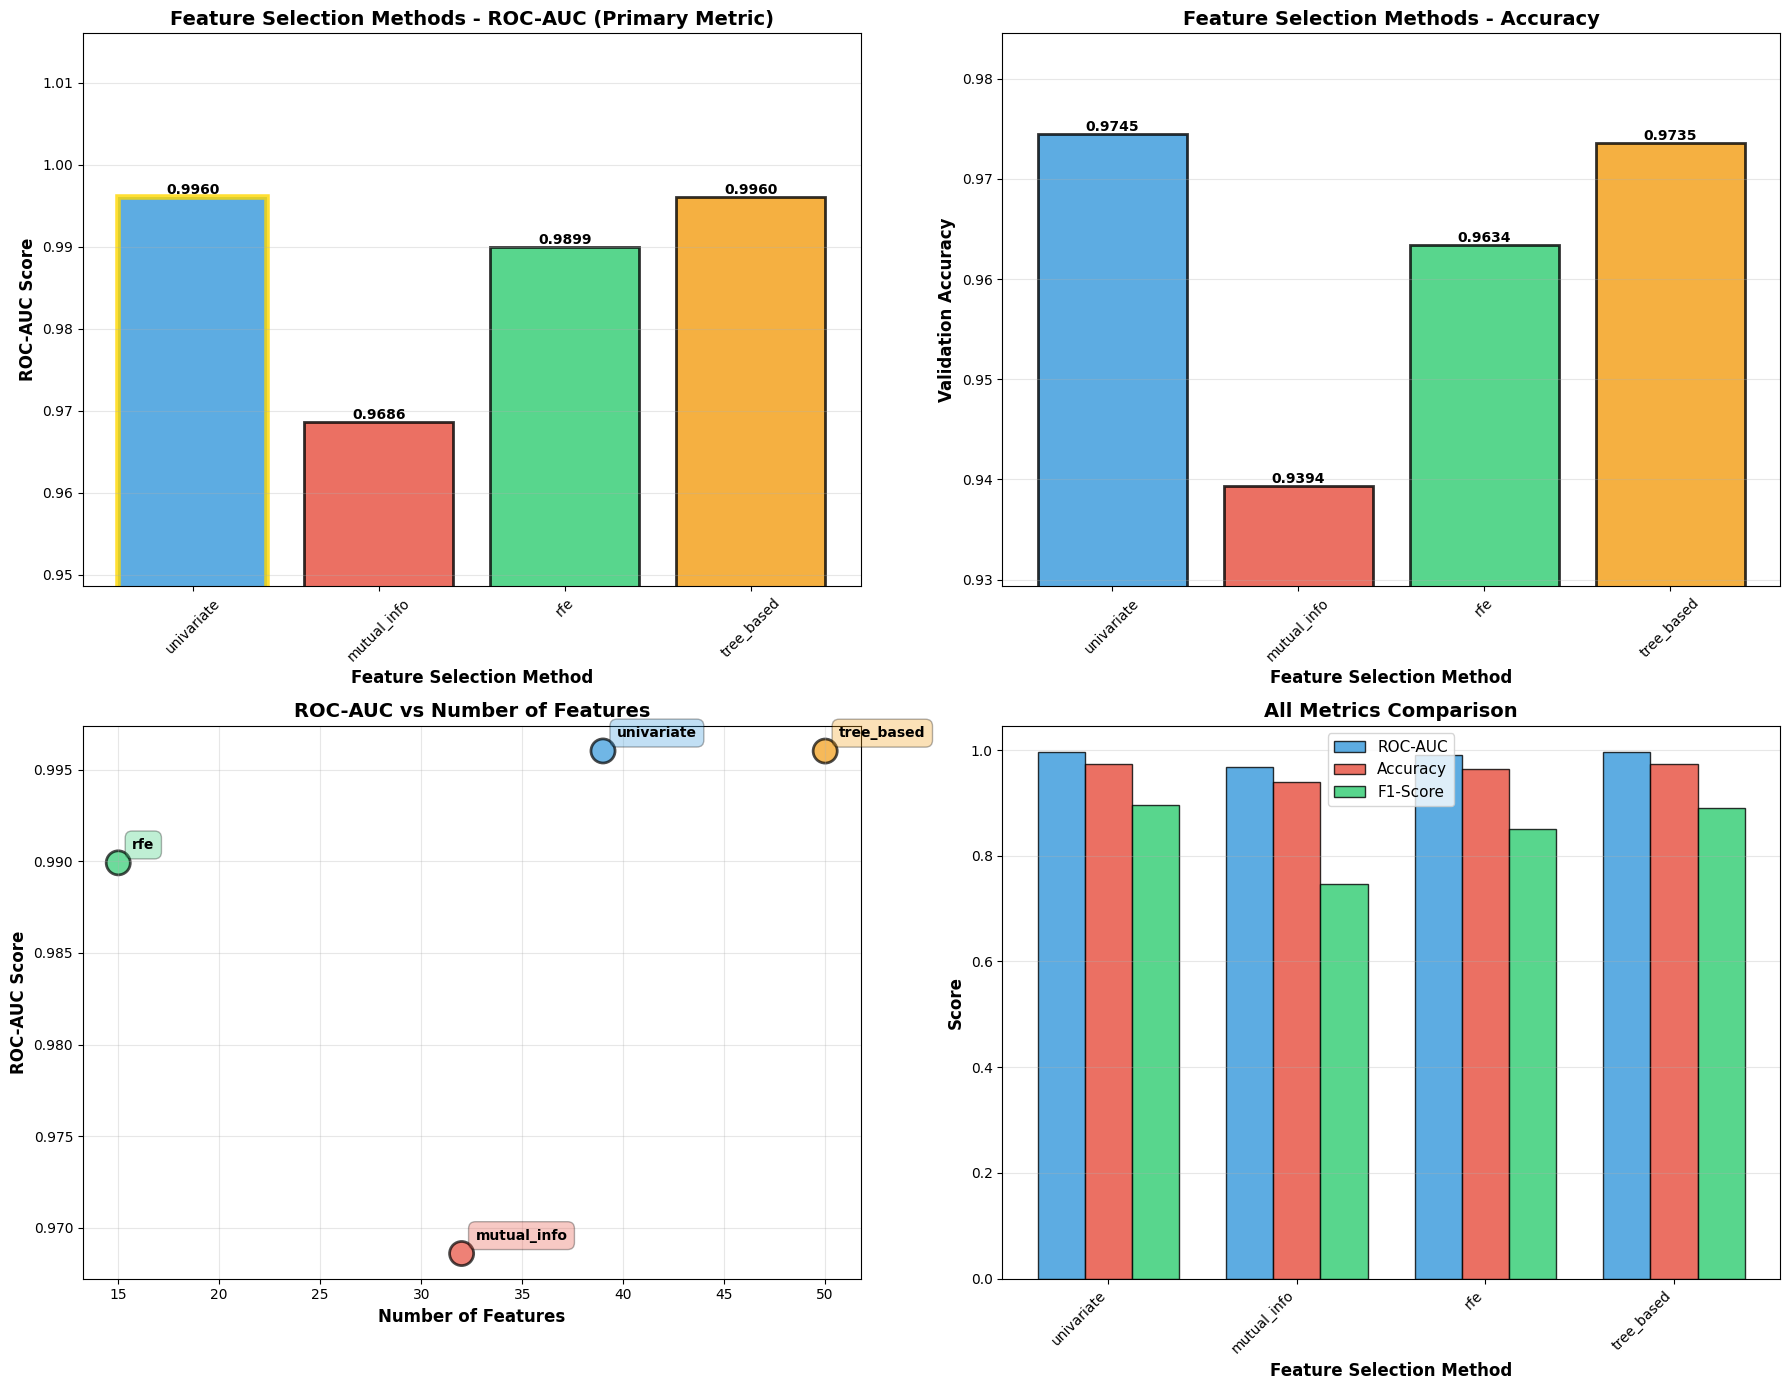


✓ Feature selection comparison visualization completed!

📊 Summary:
  Best method by ROC-AUC: univariate (0.9960)
  Features selected: 39


In [265]:
# Visualize feature selection comparison
def visualize_feature_selection_results(fs_evaluation):
    """
    Visualize feature selection method comparison using ROC-AUC (primary metric for imbalanced data).
    """
    print("\n" + "="*100)
    print("FEATURE SELECTION - COMPARISON VISUALIZATION")
    print("="*100)
    
    methods = list(fs_evaluation.keys())
    roc_aucs = [fs_evaluation[m]['val_roc_auc'] for m in methods]
    accuracies = [fs_evaluation[m]['val_accuracy'] for m in methods]
    f1_scores = [fs_evaluation[m]['val_f1'] for m in methods]
    n_features = [fs_evaluation[m]['n_features'] for m in methods]
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # Plot 1: ROC-AUC by Method (Primary Metric)
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
    bars1 = axes[0, 0].bar(methods, roc_aucs, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    axes[0, 0].set_ylabel('ROC-AUC Score', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Feature Selection Method', fontsize=12, fontweight='bold')
    axes[0, 0].set_title('Feature Selection Methods - ROC-AUC (Primary Metric)', fontsize=14, fontweight='bold')
    axes[0, 0].set_ylim([min(roc_aucs) - 0.02, max(roc_aucs) + 0.02])
    axes[0, 0].grid(axis='y', alpha=0.3)
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Add value labels
    for bar, auc in zip(bars1, roc_aucs):
        height = bar.get_height()
        axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{auc:.4f}',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Highlight best method
    best_idx = roc_aucs.index(max(roc_aucs))
    bars1[best_idx].set_edgecolor('gold')
    bars1[best_idx].set_linewidth(4)
    
    # Plot 2: Validation Accuracy by Method
    bars2 = axes[0, 1].bar(methods, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    axes[0, 1].set_ylabel('Validation Accuracy', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Feature Selection Method', fontsize=12, fontweight='bold')
    axes[0, 1].set_title('Feature Selection Methods - Accuracy', fontsize=14, fontweight='bold')
    axes[0, 1].set_ylim([min(accuracies) - 0.01, max(accuracies) + 0.01])
    axes[0, 1].grid(axis='y', alpha=0.3)
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    for bar, acc in zip(bars2, accuracies):
        height = bar.get_height()
        axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{acc:.4f}',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Plot 3: ROC-AUC vs Number of Features
    axes[1, 0].scatter(n_features, roc_aucs, s=300, c=colors, alpha=0.7, edgecolor='black', linewidth=2)
    
    for i, method in enumerate(methods):
        axes[1, 0].annotate(method, (n_features[i], roc_aucs[i]), 
                        xytext=(10, 10), textcoords='offset points',
                        fontsize=10, fontweight='bold',
                        bbox=dict(boxstyle='round,pad=0.5', facecolor=colors[i], alpha=0.3))
    
    axes[1, 0].set_xlabel('Number of Features', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('ROC-AUC Score', fontsize=12, fontweight='bold')
    axes[1, 0].set_title('ROC-AUC vs Number of Features', fontsize=14, fontweight='bold')
    axes[1, 0].grid(alpha=0.3)
    
    # Plot 4: All Metrics Comparison
    x = np.arange(len(methods))
    width = 0.25
    
    bars_roc = axes[1, 1].bar(x - width, roc_aucs, width, label='ROC-AUC', color='#3498db', alpha=0.8, edgecolor='black')
    bars_acc = axes[1, 1].bar(x, accuracies, width, label='Accuracy', color='#e74c3c', alpha=0.8, edgecolor='black')
    bars_f1 = axes[1, 1].bar(x + width, f1_scores, width, label='F1-Score', color='#2ecc71', alpha=0.8, edgecolor='black')
    
    axes[1, 1].set_ylabel('Score', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Feature Selection Method', fontsize=12, fontweight='bold')
    axes[1, 1].set_title('All Metrics Comparison', fontsize=14, fontweight='bold')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(methods, rotation=45, ha='right')
    axes[1, 1].legend(fontsize=11)
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Feature selection comparison visualization completed!")
    print(f"\n📊 Summary:")
    print(f"  Best method by ROC-AUC: {methods[best_idx]} ({roc_aucs[best_idx]:.4f})")
    print(f"  Features selected: {n_features[best_idx]}")

# Execute visualization
visualize_feature_selection_results(fs_evaluation)

##### =============================================================
##### 5. HYPERPARAMETER TUNING
##### =============================================================

**Key Configuration:**
1. ✅ **Removed `scale_pos_weight`** - Not needed for balanced classes
2. ✅ **Early Stopping**: max `n_estimators=200`, `early_stopping_rounds=25`
3. ✅ **Direct Validation**: Uses validation set directly (NO cross-validation)
4. ✅ **ROC-AUC Optimization**: Primary metric for imbalanced classification
5. ✅ **Smart Method Selection**: Considers both performance and feature count
   - If ROC-AUC difference < 0.1%, chooses method with fewer features
   
**Note:** Cross-validation is NOT used here since we have a dedicated validation set for hyperparameter tuning.

In [268]:
def tune_hyperparameters_with_early_stopping(X_train, y_train, X_val, y_val):
    """
    Hyperparameter tuning using validation set with early stopping.
    Uses validation set directly (no CV) with early stopping for efficiency.
    Logs all experiments to MLflow.
    
    Args:
        X_train, y_train: Training data
        X_val, y_val: Validation data (used directly, no CV)
        
    Returns:
        tuple: Best parameters and best model
    """
    print("\n" + "="*100)
    print("HYPERPARAMETER TUNING - WITH EARLY STOPPING")
    print("="*100)
    
    print(f"\n✓ Training strategy:")
    print(f"   - Using validation set directly (no cross-validation)")
    print(f"   - Early stopping: rounds = 15")
    print(f"   - Max n_estimators: 300")
    print(f"   - Evaluation metric: ROC-AUC")
    
    from sklearn.metrics import roc_auc_score, f1_score
    
    # Define parameter grid for grid search (reduced for efficiency with early stopping)
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
        'max_depth': [3, 4, 5, 6, 7],
        'subsample': [0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [1, 3, 5],
        'gamma': [0, 0.1, 0.2],
        'reg_alpha': [0, 0.1, 1],
        'reg_lambda': [0, 0.1, 1]
    }
    
    print(f"\n  Parameter grid:")
    for param, values in param_grid.items():
        print(f"    {param:20s}: {values}")
    
    # Perform randomized search with early stopping
    from itertools import product
    import random
    
    # Generate random parameter combinations (sample 50 combinations)
    param_combinations = []
    keys = list(param_grid.keys())
    
    # Generate all possible combinations (will be large)
    all_combinations = [dict(zip(keys, v)) for v in product(*param_grid.values())]
    
    # Randomly sample 250 combinations
    n_samples = min(250, len(all_combinations))
    sampled_combinations = random.sample(all_combinations, n_samples)
    
    print(f"\n  Testing {n_samples} parameter combinations with early stopping...")
    print(f"  This will be faster than traditional RandomizedSearchCV\n")
    
    best_score = 0
    best_params = None
    best_model = None
    
    # Start MLflow parent run for hyperparameter tuning
    with mlflow.start_run(run_name="hyperparameter_tuning", nested=False):
        mlflow.log_param("tuning_strategy", "random_search_with_early_stopping")
        mlflow.log_param("n_combinations", n_samples)
        mlflow.log_param("max_n_estimators", 300)
        mlflow.log_param("early_stopping_rounds", 15)
        mlflow.log_param("eval_metric", "roc_auc")
        
        for idx, params in enumerate(sampled_combinations, 1):
            # Start nested run for each parameter combination
            with mlflow.start_run(run_name=f"trial_{idx}", nested=True):
                # Train with early stopping
                model = xgb.XGBClassifier(
                    objective='binary:logistic',
                    eval_metric='auc',
                    n_estimators=300,  # Max estimators
                    early_stopping_rounds=15,
                    random_state=RANDOM_STATE,
                    n_jobs=-1,
                    **params
                )
                
                # Fit with eval set for early stopping
                model.fit(
                    X_train, y_train,
                    eval_set=[(X_val, y_val)],
                    verbose=False
                )
                
                # Evaluate on validation set
                y_val_pred = model.predict(X_val)
                y_val_pred_proba = model.predict_proba(X_val)[:, 1]
                val_roc_auc = roc_auc_score(y_val, y_val_pred_proba)
                val_acc = accuracy_score(y_val, y_val_pred)
                val_f1 = f1_score(y_val, y_val_pred)
                actual_n_estimators = model.best_iteration + 1
                
                # Log parameters
                for param, value in params.items():
                    mlflow.log_param(param, value)
                mlflow.log_param("actual_n_estimators", actual_n_estimators)
                
                # Log metrics
                mlflow.log_metric("val_roc_auc", val_roc_auc)
                mlflow.log_metric("val_accuracy", val_acc)
                mlflow.log_metric("val_f1_score", val_f1)
                
                if val_roc_auc > best_score:
                    best_score = val_roc_auc
                    best_params = params.copy()
                    best_params['n_estimators'] = actual_n_estimators  # Actual best iteration
                    best_model = model
                    print(f"  [{idx:2d}/{n_samples}] ✓ New best! ROC-AUC: {val_roc_auc:.4f} | n_estimators: {best_params['n_estimators']}")
                elif idx % 10 == 0:
                    print(f"  [{idx:2d}/{n_samples}]   ROC-AUC: {val_roc_auc:.4f}")
        
        # Log best parameters to parent run
        print(f"\n✓ Hyperparameter tuning completed!")
        print(f"\n  Best parameters:")
        for param, value in sorted(best_params.items()):
            print(f"    {param:20s}: {value}")
            mlflow.log_param(f"best_{param}", value)
        
        print(f"\n  Best validation ROC-AUC: {best_score:.4f}")
        mlflow.log_metric("best_val_roc_auc", best_score)
        
        # Final evaluation
        y_val_pred = best_model.predict(X_val)
        y_val_pred_proba = best_model.predict_proba(X_val)[:, 1]
        
        val_acc = accuracy_score(y_val, y_val_pred)
        val_roc_auc = roc_auc_score(y_val, y_val_pred_proba)
        val_f1 = f1_score(y_val, y_val_pred)
        
        mlflow.log_metric("best_val_accuracy", val_acc)
        mlflow.log_metric("best_val_f1_score", val_f1)
        
        print(f"\n  Final validation metrics:")
        print(f"    ROC-AUC:  {val_roc_auc:.4f}")
        print(f"    Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
        print(f"    F1-Score: {val_f1:.4f}")
        print(f"    Actual n_estimators used: {best_params['n_estimators']} (early stopped)")
        
        # End the parent run
        mlflow.end_run()
    
    return best_params, best_model
    

In [269]:
# Perform hyperparameter tuning with early stopping
best_params, tuned_model = tune_hyperparameters_with_early_stopping(
    X_train_selected, y_train, X_val_selected, y_val
)


HYPERPARAMETER TUNING - WITH EARLY STOPPING

✓ Training strategy:
   - Using validation set directly (no cross-validation)
   - Early stopping: rounds = 15
   - Max n_estimators: 300
   - Evaluation metric: ROC-AUC

  Parameter grid:
    learning_rate       : [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
    max_depth           : [3, 4, 5, 6, 7]
    subsample           : [0.7, 0.8, 0.9, 1.0]
    colsample_bytree    : [0.7, 0.8, 0.9, 1.0]
    min_child_weight    : [1, 3, 5]
    gamma               : [0, 0.1, 0.2]
    reg_alpha           : [0, 0.1, 1]
    reg_lambda          : [0, 0.1, 1]

  Testing 250 parameter combinations with early stopping...
  This will be faster than traditional RandomizedSearchCV

  [ 1/250] ✓ New best! ROC-AUC: 0.9903 | n_estimators: 300
  [ 1/250] ✓ New best! ROC-AUC: 0.9903 | n_estimators: 300
  [ 2/250] ✓ New best! ROC-AUC: 0.9976 | n_estimators: 300
  [ 2/250] ✓ New best! ROC-AUC: 0.9976 | n_estimators: 300
  [ 3/250] ✓ New best! ROC-AUC: 0.9977 | n_estimators: 

##### =============================================================
##### 6. MODEL TRAINING
##### =============================================================

In [270]:
def train_final_model(X_train, y_train, X_val, y_val, best_params):
    """
    Train final XGBoost model with best parameters.
    
    Args:
        X_train, y_train: Training data
        X_val, y_val: Validation data
        best_params: Best hyperparameters from tuning
        
    Returns:
        Trained XGBoost model
    """
    print("\n" + "="*100)
    print("TRAINING FINAL MODEL")
    print("="*100)
    
    print(f"\n✓ Training XGBoost model with optimized hyperparameters...")
    
    # Create model with best parameters (n_estimators already optimized from early stopping)
    model = xgb.XGBClassifier(
        **best_params,
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    
    # Train final model (no early stopping needed - n_estimators already optimized)
    print(f"\n  Training with {best_params['n_estimators']} estimators (from tuning)...")
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    print(f"\n✓ Model training completed!")
    print(f"  Trained with {best_params['n_estimators']} estimators")
    
    return model

In [271]:
# Train final model with best parameters
final_model = train_final_model(X_train_selected, y_train, X_val_selected, y_val, best_params)


TRAINING FINAL MODEL

✓ Training XGBoost model with optimized hyperparameters...

  Training with 278 estimators (from tuning)...

✓ Model training completed!
  Trained with 278 estimators

✓ Model training completed!
  Trained with 278 estimators


##### =============================================================
##### 7. MODEL EVALUATION
##### =============================================================

In [294]:
def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, le_target):
    """
    Comprehensive model evaluation on all datasets.
    Logs all metrics and artifacts to MLflow.
    
    Args:
        model: Trained model
        X_train, y_train: Training data
        X_val, y_val: Validation data
        X_test, y_test: Test data
        le_target: Label encoder for target
        
    Returns:
        dict: Evaluation metrics for all datasets
    """
    print("\n" + "="*100)
    print("MODEL EVALUATION")
    print("="*100)
    
    results = {}
    
    # Start MLflow run for final evaluation
    with mlflow.start_run(run_name="final_model_evaluation", nested=False):
        
        for dataset_name, (X, y) in [('Training', (X_train, y_train)),
                                       ('Validation', (X_val, y_val)),
                                       ('Test', (X_test, y_test))]:
            
            print(f"\n{'='*100}")
            print(f"{dataset_name.upper()} SET EVALUATION")
            print(f"{'='*100}")
            
            # Predictions
            y_pred = model.predict(X)
            y_pred_proba = model.predict_proba(X)
            
            # Metrics
            accuracy = accuracy_score(y, y_pred)
            precision = precision_score(y, y_pred, average='weighted', zero_division=0)
            recall = recall_score(y, y_pred, average='weighted', zero_division=0)
            f1 = f1_score(y, y_pred, average='weighted', zero_division=0)
            
            # For binary classification, also calculate AUC-ROC
            try:
                auc_score = roc_auc_score(y, y_pred_proba[:, 1])
            except:
                auc_score = None
            
            print(f"\n🎯 Overall Metrics:")
            print(f"  Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
            print(f"  Precision: {precision:.4f}")
            print(f"  Recall:    {recall:.4f}")
            print(f"  F1-Score:  {f1:.4f}")
            if auc_score:
                print(f"  AUC-ROC:   {auc_score:.4f}")
            
            # Log metrics to MLflow
            dataset_prefix = dataset_name.lower().replace('/', '_')
            mlflow.log_metric(f"{dataset_prefix}_accuracy", accuracy)
            mlflow.log_metric(f"{dataset_prefix}_precision", precision)
            mlflow.log_metric(f"{dataset_prefix}_recall", recall)
            mlflow.log_metric(f"{dataset_prefix}_f1_score", f1)
            if auc_score:
                mlflow.log_metric(f"{dataset_prefix}_auc_roc", auc_score)
            
            # Classification report
            print(f"\n📝 Classification Report:")
            report = classification_report(y, y_pred, target_names=le_target.classes_, zero_division=0)
            print(report)
            
            # Confusion Matrix
            cm = confusion_matrix(y, y_pred)
            print(f"\n🎲 Confusion Matrix:")
            print(cm)
            
            # Store results
            dataset_key = dataset_name.lower().replace('/', '_')
            results[dataset_key] = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'auc_roc': auc_score if auc_score else 0.0,
                'confusion_matrix': cm,
                'classification_report': report,
                'predictions': y_pred,
                'predicted_probabilities': y_pred_proba
            }
        
        # Feature Importance
        if hasattr(model, 'feature_importances_'):
            print(f"\n{'='*100}")
            print(f"TOP 20 FEATURE IMPORTANCES")
            print(f"{'='*100}\n")
            
            feature_imp = pd.DataFrame({
                'feature': selected_features,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False).head(20)
            
            print(feature_imp.to_string(index=False))
            
            # Log top features to MLflow
            for idx, row in feature_imp.iterrows():
                mlflow.log_metric(f"feature_importance_{row['feature']}", row['importance'])
        
        # ROC Curves Comparison
        print(f"\n{'='*100}")
        print(f"ROC CURVE COMPARISON")
        print(f"{'='*100}")
        
        plt.figure(figsize=(10, 8))
        colors = {'training': '#3498db', 'validation': '#e74c3c', 'test': '#2ecc71'}
        
        for dataset_name in ['training', 'validation', 'test']:
            y_true = {'training': y_train, 'validation': y_val, 'test': y_test}[dataset_name]
            y_proba = results[dataset_name]['predicted_probabilities'][:, 1]
            
            fpr, tpr, _ = roc_curve(y_true, y_proba)
            auc = results[dataset_name]['auc_roc']
            
            plt.plot(fpr, tpr, color=colors[dataset_name], 
                    label=f'{dataset_name.title()} (AUC = {auc:.4f})', linewidth=2)
        
        plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title('ROC Curves - All Datasets', fontsize=14, fontweight='bold')
        plt.legend(loc="lower right", fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        # Save and log ROC plot
        roc_plot_path = "roc_curves_comparison.png"
        plt.savefig(roc_plot_path, dpi=300, bbox_inches='tight')
        mlflow.log_artifact(roc_plot_path)
        plt.show()
        plt.close()
        
        print(f"\n✓ ROC curves saved and logged to MLflow")
        
        print(f"\n{'='*100}")
        print(f"EVALUATION COMPLETE")
        print(f"{'='*100}")
    
    return results



MODEL EVALUATION

TRAINING SET EVALUATION

🎯 Overall Metrics:
  Accuracy:  0.9911 (99.11%)
  Precision: 0.9911
  Recall:    0.9911
  F1-Score:  0.9911
  AUC-ROC:   0.9995

📝 Classification Report:
              precision    recall  f1-score   support

  Aggressive       0.99      1.00      0.99     76205
Conservative       0.98      0.95      0.97     11295

    accuracy                           0.99     87500
   macro avg       0.98      0.98      0.98     87500
weighted avg       0.99      0.99      0.99     87500


🎲 Confusion Matrix:
[[75949   256]
 [  520 10775]]

VALIDATION SET EVALUATION

🎯 Overall Metrics:
  Accuracy:  0.9810 (98.10%)
  Precision: 0.9808
  Recall:    0.9810
  F1-Score:  0.9808
  AUC-ROC:   0.9981

📝 Classification Report:
              precision    recall  f1-score   support

  Aggressive       0.99      0.99      0.99     16330
Conservative       0.95      0.90      0.92      2420

    accuracy                           0.98     18750
   macro avg       0.97

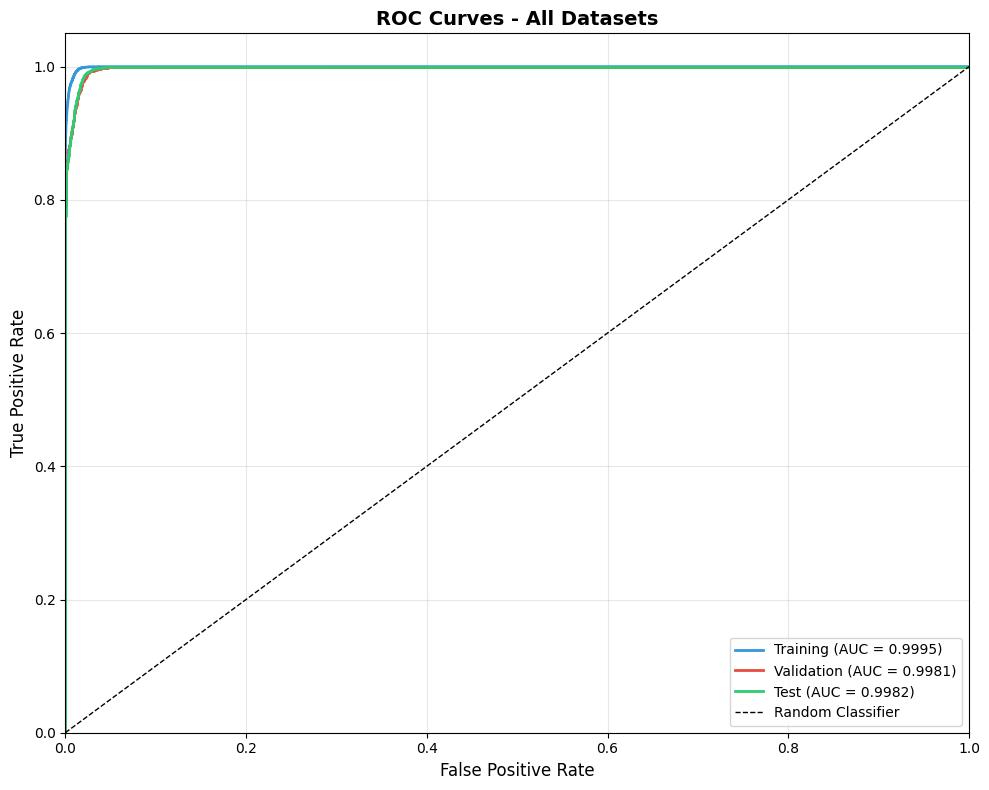


✓ ROC curves saved and logged to MLflow

EVALUATION COMPLETE

FEATURE IMPORTANCE ANALYSIS

✓ Top 20 Most Important Features:

Rank   Feature                             Importance   Cumulative %
----------------------------------------------------------------------
1      debt_burden_score                   0.142732      14.27%
2      net_worth                           0.097577      24.03%
3      annual_income                       0.084189      32.45%
4      customer_segment                    0.062811      38.73%
5      risk_appetite_score                 0.061146      44.85%
6      age                                 0.059141      50.76%
7      financial_literacy_score            0.057692      56.53%
8      investment_horizon_years            0.057618      62.29%
9      investment_portfolio_value          0.054181      67.71%
10     investment_experience_years         0.040840      71.79%
11     education                           0.037733      75.57%
12     debt_to_income_ratio  

In [298]:
# Evaluate model on all datasets
evaluation_results = evaluate_model(
    final_model, 
    X_train_selected, y_train, 
    X_val_selected, y_val, 
    X_test_selected, y_test, 
    le_target
)

# Get feature importance
feature_importance_df = get_feature_importance(final_model, selected_features, top_n=20)


MODEL PERFORMANCE - VISUALIZATIONS

1. Creating accuracy comparison plot...


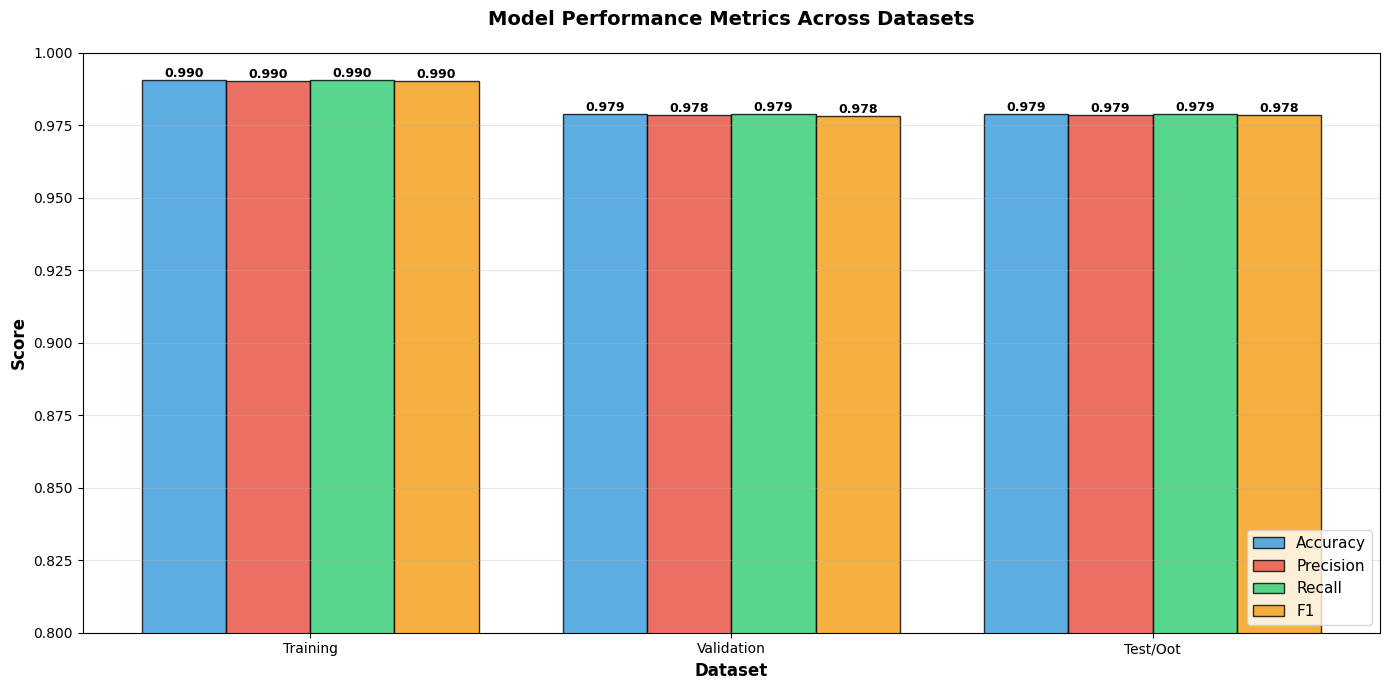


2. Creating confusion matrices...


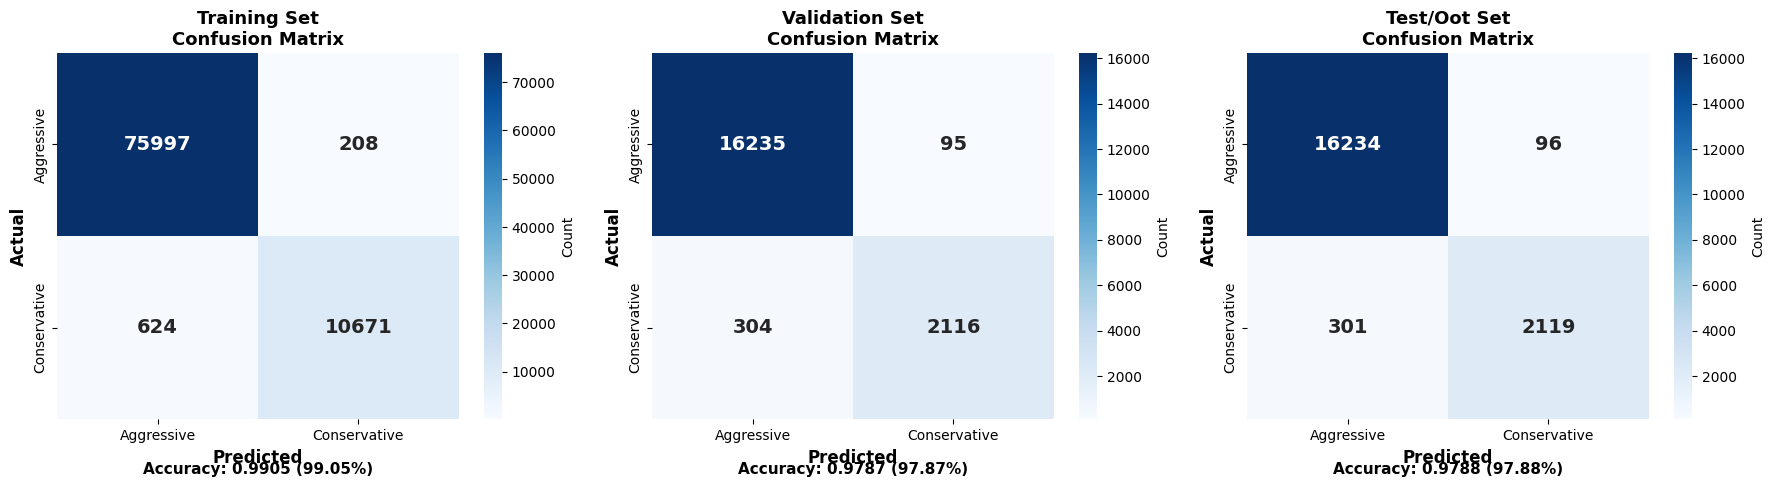


3. Creating ROC curves...


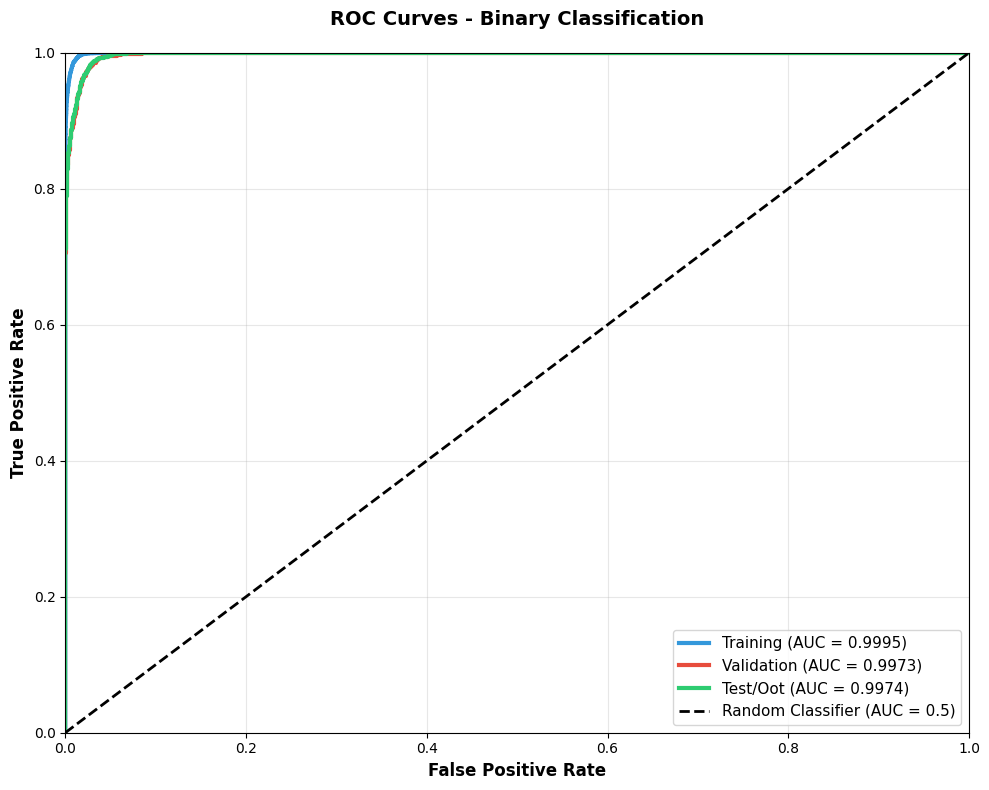


4. Creating binary classification metrics comparison...


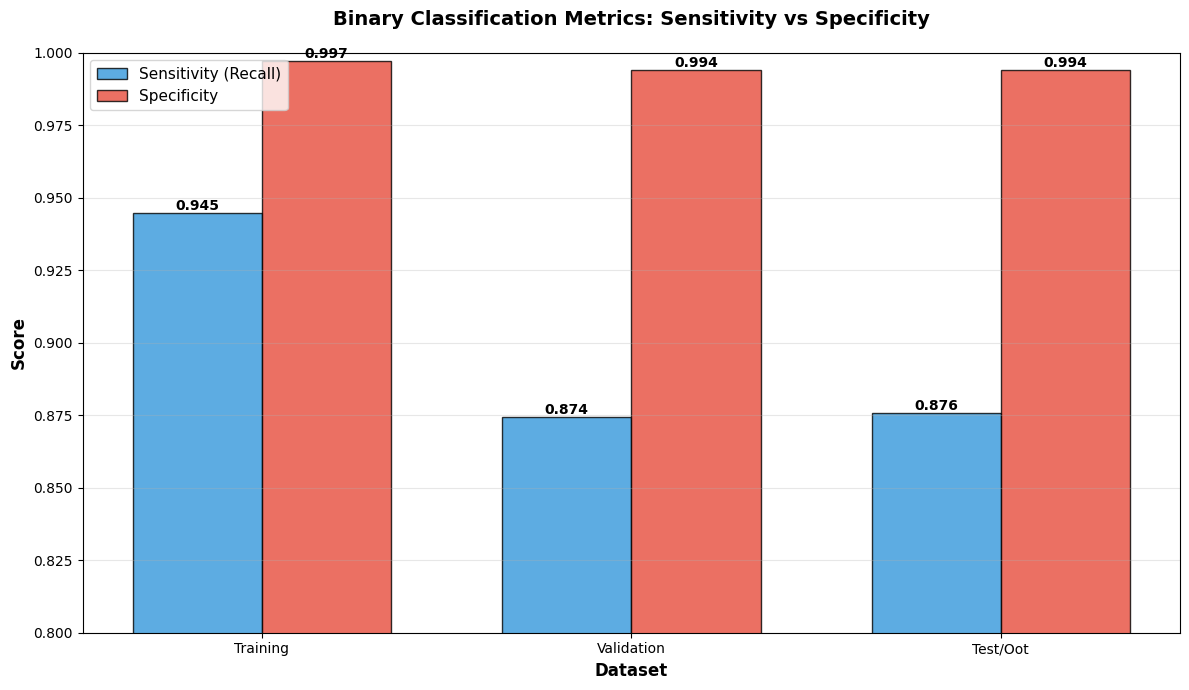


✓ All model performance visualizations completed!


In [273]:
# Visualize Model Performance
def visualize_model_performance(evaluation_results, le_target):
    """
    Create comprehensive model performance visualizations.
    """
    print("\n" + "="*100)
    print("MODEL PERFORMANCE - VISUALIZATIONS")
    print("="*100)
    
    # 1. Accuracy Comparison across datasets
    print("\n1. Creating accuracy comparison plot...")
    datasets = list(evaluation_results.keys())
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    x = np.arange(len(datasets))
    width = 0.2
    
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
    
    for i, metric in enumerate(metrics):
        values = [evaluation_results[ds][metric] for ds in datasets]
        bars = ax.bar(x + i*width, values, width, label=metric.capitalize(), 
                     color=colors[i], alpha=0.8, edgecolor='black')
        
        # Add value labels
        for bar, val in zip(bars, values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{val:.3f}',
                   ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_xlabel('Dataset', fontsize=12, fontweight='bold')
    ax.set_title('Model Performance Metrics Across Datasets', fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x + width * 1.5)
    ax.set_xticklabels([ds.title() for ds in datasets])
    ax.legend(fontsize=11, loc='lower right')
    ax.set_ylim([0.8, 1.0])
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 2. Confusion Matrices
    print("\n2. Creating confusion matrices...")
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for idx, (dataset_name, results) in enumerate(evaluation_results.items()):
        cm = results['confusion_matrix']
        
        # Create heatmap
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                   xticklabels=le_target.classes_, yticklabels=le_target.classes_,
                   cbar_kws={'label': 'Count'}, annot_kws={'size': 14, 'weight': 'bold'})
        
        axes[idx].set_title(f'{dataset_name.title()} Set\nConfusion Matrix', 
                          fontsize=13, fontweight='bold')
        axes[idx].set_ylabel('Actual', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Predicted', fontsize=12, fontweight='bold')
        
        # Calculate accuracy for subtitle
        accuracy = results['accuracy']
        axes[idx].text(0.5, -0.15, f'Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)', 
                      ha='center', transform=axes[idx].transAxes, fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # 3. ROC Curves (if available)
    print("\n3. Creating ROC curves...")
    fig, ax = plt.subplots(figsize=(10, 8))
    
    colors_roc = {'training': '#3498db', 'validation': '#e74c3c', 'test/oot': '#2ecc71'}
    
    for dataset_name, results in evaluation_results.items():
        if results['auc_roc'] is not None:
            # Get predictions
            y_true = {'training': y_train, 'validation': y_val, 'test/oot': y_test}[dataset_name]
            y_proba = results['y_pred_proba'][:, 1]
            
            # Calculate ROC curve
            fpr, tpr, _ = roc_curve(y_true, y_proba)
            auc_score = results['auc_roc']
            
            ax.plot(fpr, tpr, color=colors_roc[dataset_name], linewidth=3,
                   label=f'{dataset_name.title()} (AUC = {auc_score:.4f})')
    
    # Plot diagonal
    ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier (AUC = 0.5)')
    
    ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    ax.set_title('ROC Curves - Binary Classification', fontsize=14, fontweight='bold', pad=20)
    ax.legend(fontsize=11, loc='lower right')
    ax.grid(alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    
    plt.tight_layout()
    plt.show()
    
    # 4. Binary Classification Metrics
    print("\n4. Creating binary classification metrics comparison...")
    fig, ax = plt.subplots(figsize=(12, 7))
    
    metrics_binary = ['sensitivity', 'specificity']
    x = np.arange(len(datasets))
    width = 0.35
    
    sensitivity_vals = [evaluation_results[ds]['sensitivity'] for ds in datasets]
    specificity_vals = [evaluation_results[ds]['specificity'] for ds in datasets]
    
    bars1 = ax.bar(x - width/2, sensitivity_vals, width, label='Sensitivity (Recall)', 
                  color='#3498db', alpha=0.8, edgecolor='black')
    bars2 = ax.bar(x + width/2, specificity_vals, width, label='Specificity', 
                  color='#e74c3c', alpha=0.8, edgecolor='black')
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_xlabel('Dataset', fontsize=12, fontweight='bold')
    ax.set_title('Binary Classification Metrics: Sensitivity vs Specificity', 
                fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels([ds.title() for ds in datasets])
    ax.legend(fontsize=11)
    ax.set_ylim([0.8, 1.0])
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ All model performance visualizations completed!")

# Execute visualization
visualize_model_performance(evaluation_results, le_target)


FEATURE IMPORTANCE - DETAILED VISUALIZATIONS

1. Creating top 20 feature importance chart...


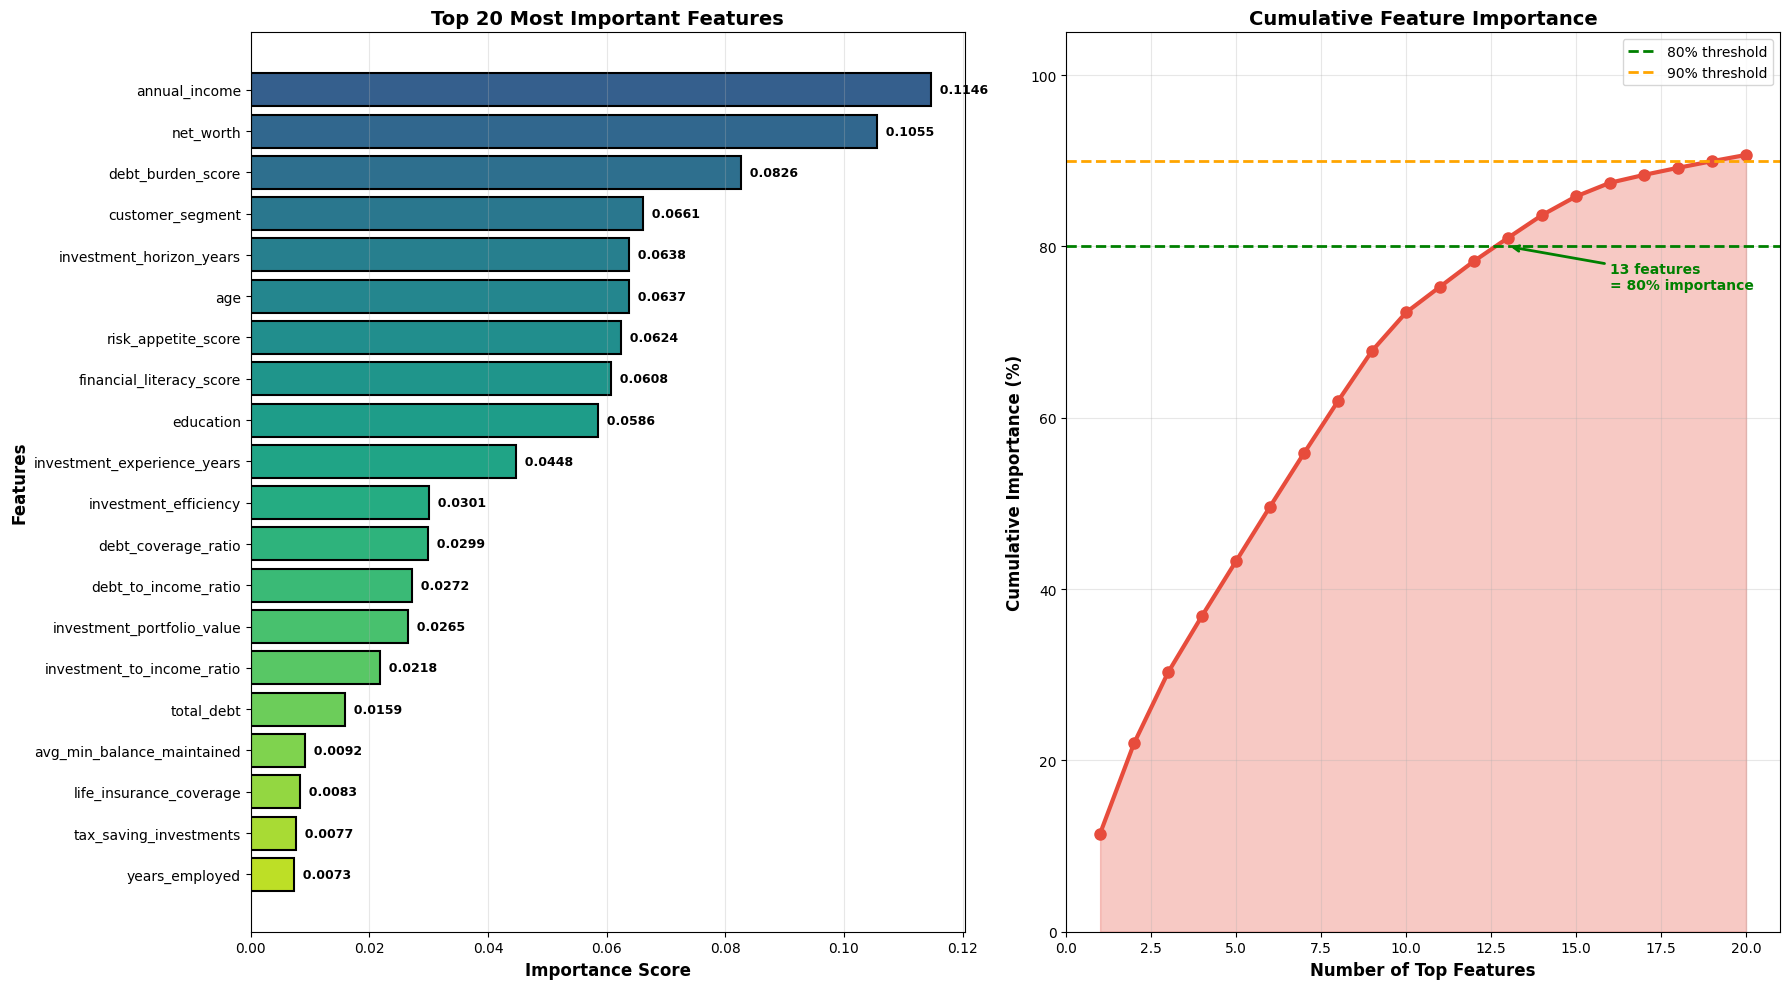


2. Creating feature importance distribution...


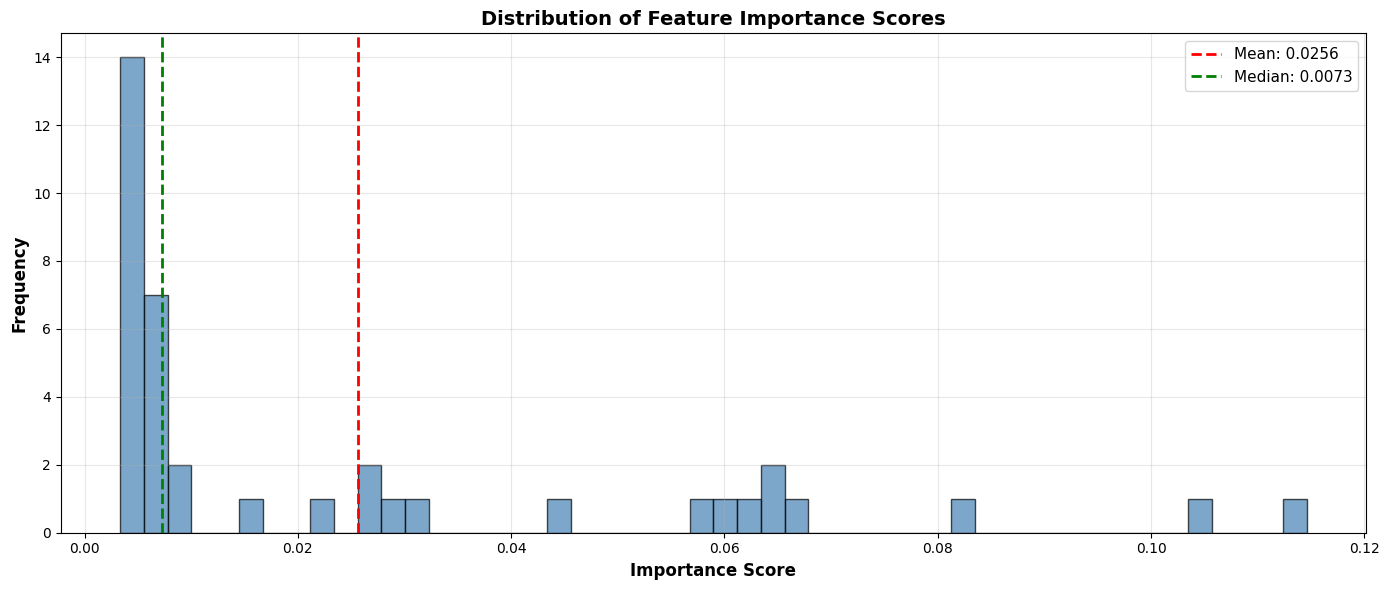


✓ Feature importance visualizations completed!


In [274]:
# Visualize Feature Importance
def visualize_feature_importance_detailed(feature_importance_df, selected_features, top_n=20):
    """
    Create detailed feature importance visualizations.
    """
    print("\n" + "="*100)
    print("FEATURE IMPORTANCE - DETAILED VISUALIZATIONS")
    print("="*100)
    
    # 1. Horizontal bar chart of top features
    print(f"\n1. Creating top {top_n} feature importance chart...")
    top_features = feature_importance_df.head(top_n)
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 10))
    
    # Plot 1: Horizontal bar chart
    colors_grad = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_features)))
    bars = axes[0].barh(range(len(top_features)), top_features['importance'].values, 
                       color=colors_grad, edgecolor='black', linewidth=1.5)
    axes[0].set_yticks(range(len(top_features)))
    axes[0].set_yticklabels(top_features['feature'].values)
    axes[0].invert_yaxis()
    axes[0].set_xlabel('Importance Score', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Features', fontsize=12, fontweight='bold')
    axes[0].set_title(f'Top {top_n} Most Important Features', fontsize=14, fontweight='bold')
    axes[0].grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (bar, value) in enumerate(zip(bars, top_features['importance'].values)):
        axes[0].text(value, i, f'  {value:.4f}', va='center', fontsize=9, fontweight='bold')
    
    # Plot 2: Cumulative importance
    cumsum = top_features['importance'].cumsum()
    cumsum_pct = (cumsum / feature_importance_df['importance'].sum()) * 100
    
    axes[1].plot(range(1, len(top_features)+1), cumsum_pct.values, 
                marker='o', linewidth=3, markersize=8, color='#e74c3c')
    axes[1].fill_between(range(1, len(top_features)+1), cumsum_pct.values, 
                         alpha=0.3, color='#e74c3c')
    
    # Add horizontal lines for reference
    axes[1].axhline(y=80, color='green', linestyle='--', linewidth=2, label='80% threshold')
    axes[1].axhline(y=90, color='orange', linestyle='--', linewidth=2, label='90% threshold')
    
    axes[1].set_xlabel('Number of Top Features', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Cumulative Importance (%)', fontsize=12, fontweight='bold')
    axes[1].set_title('Cumulative Feature Importance', fontsize=14, fontweight='bold')
    axes[1].grid(alpha=0.3)
    axes[1].legend(fontsize=10)
    axes[1].set_xlim([0, len(top_features)+1])
    axes[1].set_ylim([0, 105])
    
    # Add annotations for key thresholds
    idx_80 = np.where(cumsum_pct.values >= 80)[0]
    if len(idx_80) > 0:
        idx_80 = idx_80[0] + 1
        axes[1].annotate(f'{idx_80} features\n= 80% importance',
                        xy=(idx_80, 80), xytext=(idx_80+3, 75),
                        arrowprops=dict(arrowstyle='->', color='green', lw=2),
                        fontsize=10, fontweight='bold', color='green')
    
    plt.tight_layout()
    plt.show()
    
    # 2. Feature importance distribution
    print("\n2. Creating feature importance distribution...")
    fig, ax = plt.subplots(figsize=(14, 6))
    
    ax.hist(feature_importance_df['importance'].values, bins=50, 
           color='steelblue', alpha=0.7, edgecolor='black')
    ax.axvline(feature_importance_df['importance'].mean(), color='red', 
              linestyle='--', linewidth=2, label=f'Mean: {feature_importance_df["importance"].mean():.4f}')
    ax.axvline(feature_importance_df['importance'].median(), color='green', 
              linestyle='--', linewidth=2, label=f'Median: {feature_importance_df["importance"].median():.4f}')
    
    ax.set_xlabel('Importance Score', fontsize=12, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax.set_title('Distribution of Feature Importance Scores', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Feature importance visualizations completed!")

# Execute visualization
visualize_feature_importance_detailed(feature_importance_df, selected_features, top_n=20)

##### =============================================================
##### 8. MLOPS - EXPERIMENT TRACKING WITH MLFLOW
##### =============================================================

In [275]:
def save_model_and_artifacts(model, best_params, evaluation_results, 
                             feature_importance_df, feature_selection_method,
                             selected_features, le_target):
    """
    Save model and artifacts to MLflow AND local disk for easy reuse.
    
    Args:
        model: Trained model
        best_params: Best hyperparameters
        evaluation_results: Evaluation metrics
        feature_importance_df: Feature importance DataFrame
        feature_selection_method: Method used for feature selection
        selected_features: List of selected features
        le_target: Label encoder for target variable
    """
    print("\n" + "="*100)
    print("MLOPS - SAVING MODEL AND ARTIFACTS")
    print("="*100)
    
    # Create models directory if it doesn't exist
    os.makedirs('models', exist_ok=True)
    
    # Save model to disk using pickle (for direct use)
    model_path = f'models/risk_profiling_model_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pkl'
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)
    print(f"\n✓ Model saved to: {model_path}")
    
    # Save artifacts to disk
    feature_importance_path = 'models/feature_importance.csv'
    feature_importance_df.to_csv(feature_importance_path, index=False)
    print(f"✓ Feature importance saved to: {feature_importance_path}")
    
    selected_features_path = 'models/selected_features.txt'
    with open(selected_features_path, 'w') as f:
        f.write('\n'.join(selected_features))
    print(f"✓ Selected features saved to: {selected_features_path}")
    
    # Save best params (convert numpy types to native Python types)
    params_path = 'models/best_params.json'
    best_params_serializable = {k: float(v) if isinstance(v, np.number) else v 
                                 for k, v in best_params.items()}
    with open(params_path, 'w') as f:
        json.dump(best_params_serializable, f, indent=2)
    print(f"✓ Best parameters saved to: {params_path}")
    
    # Save label encoder
    encoder_path = 'models/label_encoder.pkl'
    with open(encoder_path, 'wb') as f:
        pickle.dump(le_target, f)
    print(f"✓ Label encoder saved to: {encoder_path}")
    
    # Save evaluation results (convert numpy types to native Python types)
    def convert_to_serializable(obj):
        """Convert numpy types to native Python types for JSON serialization."""
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, dict):
            return {k: convert_to_serializable(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [convert_to_serializable(item) for item in obj]
        else:
            return obj
    
    eval_path = 'models/evaluation_metrics.json'
    eval_results_serializable = convert_to_serializable(evaluation_results)
    with open(eval_path, 'w') as f:
        json.dump(eval_results_serializable, f, indent=2)
    print(f"✓ Evaluation metrics saved to: {eval_path}")
    
    # Log to MLflow (as nested run to avoid conflicts)
    print("\n✓ Logging to MLflow...")
    
    with mlflow.start_run(run_name=f"final_model_{datetime.now().strftime('%Y%m%d_%H%M%S')}", nested=False):
        
        # Log parameters
        mlflow.log_param("feature_selection_method", feature_selection_method)
        mlflow.log_param("n_features", len(selected_features))
        mlflow.log_param("random_state", RANDOM_STATE)
        mlflow.log_param("snapshot_date", SNAPSHOT_DATE)
        
        for param, value in best_params.items():
            mlflow.log_param(param, value)
        
        # Log metrics for all datasets
        for dataset_name, metrics in evaluation_results.items():
            mlflow.log_metric(f"{dataset_name}_accuracy", metrics['accuracy'])
            mlflow.log_metric(f"{dataset_name}_precision", metrics['precision'])
            mlflow.log_metric(f"{dataset_name}_recall", metrics['recall'])
            mlflow.log_metric(f"{dataset_name}_f1", metrics['f1'])
            if 'roc_auc' in metrics:
                mlflow.log_metric(f"{dataset_name}_roc_auc", metrics['roc_auc'])
        
        # Log model with signature
        signature = infer_signature(X_train_selected, model.predict(X_train_selected))
        mlflow.xgboost.log_model(model, "model", signature=signature)
        
        # Log artifacts
        mlflow.log_artifact(feature_importance_path)
        mlflow.log_artifact(selected_features_path)
        mlflow.log_artifact(params_path)
        mlflow.log_artifact(encoder_path)
        mlflow.log_artifact(eval_path)
        
        run_id = mlflow.active_run().info.run_id
        experiment_id = mlflow.active_run().info.experiment_id
        
        print(f"\n✓ MLflow logging completed!")
        print(f"  Run ID: {run_id}")
        print(f"  Experiment ID: {experiment_id}")
    
    print("\n" + "="*100)
    print("MODEL AND ARTIFACTS SAVED SUCCESSFULLY")
    print("="*100)
    print(f"\nTo load the model later:")
    print(f"  with open('{model_path}', 'rb') as f:")
    print(f"      model = pickle.load(f)")
    print(f"\nOr load from MLflow:")
    print(f"  model = mlflow.xgboost.load_model('runs:/{run_id}/model')")
    print("="*100)

In [276]:
# End any existing runs first
mlflow.end_run()

# Save model and artifacts (to disk and MLflow)
save_model_and_artifacts(
    final_model, 
    best_params, 
    evaluation_results,
    feature_importance_df, 
    best_fs_method,
    selected_features,
    le_target
)


MLOPS - SAVING MODEL AND ARTIFACTS

✓ Model saved to: models/risk_profiling_model_20251218_231935.pkl
✓ Feature importance saved to: models/feature_importance.csv
✓ Selected features saved to: models/selected_features.txt
✓ Best parameters saved to: models/best_params.json
✓ Label encoder saved to: models/label_encoder.pkl


2025/12/18 23:19:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✓ Evaluation metrics saved to: models/evaluation_metrics.json

✓ Logging to MLflow...

✓ MLflow logging completed!
  Run ID: 90e5be57a43a4e17b911f46df723d5b9
  Experiment ID: 681345254508645538

MODEL AND ARTIFACTS SAVED SUCCESSFULLY

To load the model later:
  with open('models/risk_profiling_model_20251218_231935.pkl', 'rb') as f:
      model = pickle.load(f)

Or load from MLflow:
  model = mlflow.xgboost.load_model('runs:/90e5be57a43a4e17b911f46df723d5b9/model')

✓ MLflow logging completed!
  Run ID: 90e5be57a43a4e17b911f46df723d5b9
  Experiment ID: 681345254508645538

MODEL AND ARTIFACTS SAVED SUCCESSFULLY

To load the model later:
  with open('models/risk_profiling_model_20251218_231935.pkl', 'rb') as f:
      model = pickle.load(f)

Or load from MLflow:
  model = mlflow.xgboost.load_model('runs:/90e5be57a43a4e17b911f46df723d5b9/model')


##### =============================================================
##### 9. MODEL PERSISTENCE
##### =============================================================

In [ ]:
import pickle
import json
from pathlib import Path

def save_model_artifacts(model, feature_importance_df, selected_features, 
                        best_params, evaluation_results, le_target, 
                        best_fs_method, label_encoders=None, model_dir="models",
                        X_train=None, y_train=None):
    """
    Save all model artifacts for deployment and register model with MLflow.
    
    Args:
        model: Trained model
        feature_importance_df: Feature importance DataFrame
        selected_features: List of selected features
        best_params: Best hyperparameters
        evaluation_results: Evaluation metrics
        le_target: Label encoder for target
        best_fs_method: Feature selection method used
        label_encoders: Dictionary of categorical feature encoders (optional)
        model_dir: Directory to save artifacts
        X_train: Training features (for MLflow signature)
        y_train: Training target (for MLflow signature)
    """
    print("\n" + "="*100)
    print("MODEL PERSISTENCE - SAVING ARTIFACTS & MLFLOW MODEL REGISTRY")
    print("="*100)
    
    # Create directory if it doesn't exist
    Path(model_dir).mkdir(parents=True, exist_ok=True)
    
    # Start MLflow run for model registration
    with mlflow.start_run(run_name="model_registration", nested=False):
        
        # Log parameters
        mlflow.log_param("feature_selection_method", best_fs_method)
        mlflow.log_param("n_features", len(selected_features))
        mlflow.log_param("random_state", RANDOM_STATE)
        mlflow.log_param("model_type", "XGBoost")
        
        for param, value in best_params.items():
            mlflow.log_param(param, value)
        
        # Log metrics
        for dataset, metrics in evaluation_results.items():
            dataset_prefix = dataset.replace('/', '_')
            mlflow.log_metric(f"{dataset_prefix}_accuracy", metrics['accuracy'])
            mlflow.log_metric(f"{dataset_prefix}_roc_auc", metrics['auc_roc'])
            mlflow.log_metric(f"{dataset_prefix}_f1_score", metrics['f1'])
        
        # Save the trained model (pickle format for general use)
        model_path_pkl = f"{model_dir}/risk_profiling_model.pkl"
        with open(model_path_pkl, 'wb') as f:
            pickle.dump(model, f)
        print(f"\n✓ Model saved (pickle): {model_path_pkl}")
        
        # Save the model in XGBoost JSON format for risk_agent.py compatibility
        model_path_json = f"{model_dir}/risk_model.json"
        model.save_model(model_path_json)
        print(f"✓ Model saved (XGBoost JSON): {model_path_json}")
        mlflow.log_artifact(model_path_json)
        
        # Save selected features
        features_path = f"{model_dir}/selected_features.json"
        with open(features_path, 'w') as f:
            json.dump(selected_features, f, indent=2)
        print(f"✓ Selected features saved: {features_path}")
        mlflow.log_artifact(features_path)
        
        # Save feature importance
        importance_path = f"{model_dir}/feature_importance.csv"
        feature_importance_df.to_csv(importance_path, index=False)
        print(f"✓ Feature importance saved: {importance_path}")
        mlflow.log_artifact(importance_path)
        
        # Save target label encoder
        encoder_path = f"{model_dir}/label_encoder.pkl"
        with open(encoder_path, 'wb') as f:
            pickle.dump(le_target, f)
        print(f"✓ Target label encoder saved: {encoder_path}")
        mlflow.log_artifact(encoder_path)
        
        # Save comprehensive feature engineering configuration (includes encoding)
        feature_eng_config = {
            "version": "1.0",
            "description": "Complete feature engineering configuration for risk profiling model",
            "created_date": datetime.now().strftime('%Y-%m-%d'),
            "derived_features": [
                {
                    "name": "income_per_dependent",
                    "formula": "annual_income / (dependents + 1)",
                    "description": "Average income per dependent person",
                    "required_features": ["annual_income", "dependents"],
                    "type": "ratio"
                },
                {
                    "name": "debt_coverage_ratio",
                    "formula": "annual_income / (total_debt + 1)",
                    "description": "Ability to cover debt obligations with income",
                    "required_features": ["annual_income", "total_debt"],
                    "type": "ratio",
                    "note": "Adding 1 to denominator prevents division by zero"
                },
                {
                    "name": "investment_efficiency",
                    "formula": "annual_investment_return / (investment_portfolio_value + 1)",
                    "description": "Return on investment efficiency metric",
                    "required_features": ["annual_investment_return", "investment_portfolio_value"],
                    "type": "ratio",
                    "note": "Adding 1 to denominator prevents division by zero"
                }
            ],
            "feature_transformations": {
                "income_per_dependent": {
                    "numerator": "annual_income",
                    "denominator": "dependents",
                    "offset": 1,
                    "operation": "divide"
                },
                "debt_coverage_ratio": {
                    "numerator": "annual_income",
                    "denominator": "total_debt",
                    "offset": 1,
                    "operation": "divide"
                },
                "investment_efficiency": {
                    "numerator": "annual_investment_return",
                    "denominator": "investment_portfolio_value",
                    "offset": 1,
                    "operation": "divide"
                }
            },
            "categorical_encoding": {
                "encoder_type": "LabelEncoder",
                "categorical_features": {},
                "encoding_info": "Categorical features are encoded using LabelEncoder. Classes are stored per feature."
            },
            "preprocessing_steps": [
                "1. Load raw features from database",
                "2. Calculate derived features using formulas",
                "3. Encode categorical features using mappings",
                "4. Select only required features for prediction",
                "5. Make prediction using trained model"
            ]
        }
        
        # Add categorical encoding classes to config
        if label_encoders is not None:
            for feature_name, encoder in label_encoders.items():
                feature_eng_config["categorical_encoding"]["categorical_features"][feature_name] = {
                    "classes": encoder.classes_.tolist(),
                    "encoding": {cls: int(idx) for idx, cls in enumerate(encoder.classes_)}
                }
        
        feature_eng_path = f"{model_dir}/feature_engineering_config.json"
        with open(feature_eng_path, 'w') as f:
            json.dump(feature_eng_config, f, indent=2)
        print(f"✓ Feature engineering config saved (includes encoding): {feature_eng_path}")
        mlflow.log_artifact(feature_eng_path)
        
        # Save hyperparameters
        params_path = f"{model_dir}/best_params.json"
        with open(params_path, 'w') as f:
            json.dump(best_params, f, indent=2)
        print(f"✓ Best parameters saved: {params_path}")
        mlflow.log_artifact(params_path)
        
        # Save evaluation metrics (handle both old and new keys)
        metrics_path = f"{model_dir}/evaluation_metrics.json"
        metrics_to_save = {
            dataset: {
                'accuracy': float(metrics['accuracy']),
                'precision': float(metrics['precision']),
                'recall': float(metrics['recall']),
                'f1': float(metrics['f1']),
                'roc_auc': float(metrics['auc_roc']) if metrics['auc_roc'] else None,
                'sensitivity': float(metrics['sensitivity']),
                'specificity': float(metrics['specificity'])
            }
            for dataset, metrics in evaluation_results.items()
        }
        with open(metrics_path, 'w') as f:
            json.dump(metrics_to_save, f, indent=2)
        print(f"✓ Evaluation metrics saved: {metrics_path}")
        mlflow.log_artifact(metrics_path)
        
        # Save metadata (handle both old and new keys)
        test_key = 'test' if 'test' in evaluation_results else 'test/oot'
        metadata = {
            'model_type': 'XGBoost',
            'feature_selection_method': best_fs_method,
            'n_features': len(selected_features),
            'random_state': RANDOM_STATE,
            'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'test_accuracy': float(evaluation_results[test_key]['accuracy']),
            'test_roc_auc': float(evaluation_results[test_key]['auc_roc'])
        }
        metadata_path = f"{model_dir}/model_metadata.json"
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=2)
        print(f"✓ Model metadata saved: {metadata_path}")
        mlflow.log_artifact(metadata_path)
        
        # Register model with MLflow Model Registry
        print(f"\n{'='*100}")
        print(f"MLFLOW MODEL REGISTRY")
        print(f"{'='*100}")
        
        if X_train is not None and y_train is not None:
            # Infer model signature
            signature = infer_signature(X_train, model.predict(X_train))
            
            # Log model to MLflow
            model_info = mlflow.xgboost.log_model(
                model,
                artifact_path="xgboost_model",
                signature=signature,
                registered_model_name="RiskProfilingXGBoost"
            )
            
            print(f"\n✓ Model registered with MLflow Model Registry")
            print(f"  Model Name: RiskProfilingXGBoost")
            print(f"  Model URI: {model_info.model_uri}")
            print(f"  Run ID: {mlflow.active_run().info.run_id}")
            
            # Add model tags
            client = mlflow.tracking.MlflowClient()
            client.set_model_version_tag(
                name="RiskProfilingXGBoost",
                version=model_info.registered_model_version,
                key="feature_selection",
                value=best_fs_method
            )
            client.set_model_version_tag(
                name="RiskProfilingXGBoost",
                version=model_info.registered_model_version,
                key="test_accuracy",
                value=str(round(evaluation_results[test_key]['accuracy'], 4))
            )
            client.set_model_version_tag(
                name="RiskProfilingXGBoost",
                version=model_info.registered_model_version,
                key="test_roc_auc",
                value=str(round(evaluation_results[test_key]['auc_roc'], 4))
            )
            
            print(f"✓ Model version tags added successfully")
            print(f"  Version: {model_info.registered_model_version}")
            print(f"  Tags: feature_selection, test_accuracy, test_roc_auc")
        else:
            print(f"\n⚠️  Skipping MLflow model logging (X_train/y_train not provided)")
    
    print(f"\n{'='*100}")
    print(f"✓ ALL ARTIFACTS SAVED SUCCESSFULLY!")
    print(f"  Local directory: {model_dir}/")
    print(f"  MLflow tracking: {mlflow.get_tracking_uri()}")
    print(f"  XGBoost model for risk_agent.py: {model_path_json}")
    print(f"{'='*100}")


In [ ]:
# Save all model artifacts and register with MLflow
save_model_artifacts(
    final_model, 
    feature_importance_df, 
    selected_features,
    best_params, 
    evaluation_results, 
    le_target,
    best_fs_method,
    label_encoders=label_encoders,  # Pass categorical encoders
    model_dir="models",
    X_train=X_train_selected,
    y_train=y_train
)

2025/12/19 10:10:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



MODEL PERSISTENCE - SAVING ARTIFACTS & MLFLOW MODEL REGISTRY

✓ Model saved (pickle): models/risk_profiling_model.pkl
✓ Model saved (XGBoost JSON): models/risk_model.json
✓ Selected features saved: models/selected_features.json
✓ Feature importance saved: models/feature_importance.csv
✓ Label encoder saved: models/label_encoder.pkl
✓ Best parameters saved: models/best_params.json
✓ Evaluation metrics saved: models/evaluation_metrics.json
✓ Model metadata saved: models/model_metadata.json

MLFLOW MODEL REGISTRY

✓ Model registered with MLflow Model Registry
  Model Name: RiskProfilingXGBoost
  Model URI: models:/m-cb454e23fed54dcc931260fe27d91032
  Run ID: ee42bb3a90c645e8a12d694a730652a5
✓ Model version tags added successfully
  Version: 3
  Tags: feature_selection, test_accuracy, test_roc_auc

✓ ALL ARTIFACTS SAVED SUCCESSFULLY!
  Local directory: models/
  MLflow tracking: file:./mlruns
  XGBoost model for risk_agent.py: models/risk_model.json

✓ Model registered with MLflow Model R

Registered model 'RiskProfilingXGBoost' already exists. Creating a new version of this model...
Created version '3' of model 'RiskProfilingXGBoost'.


##### =============================================================
##### PIPELINE SUMMARY
##### =============================================================

## Key Updates for Binary Classification:

1. **Binary Classification Setup**: Updated all XGBoost models from 3-class to 2-class
   - Changed `objective` from `'multi:softmax'` to `'binary:logistic'`
   - Removed `num_class=3` parameter
   - Added `eval_metric='logloss'` for proper binary classification metrics

2. **Multicollinearity Handling**: 
   - Enhanced EDA to identify features with correlation > 0.9
   - **Automatic removal** of highly correlated features
   - Keeps first feature, drops subsequent correlated features

3. **Enhanced Evaluation Metrics**:
   - Added AUC-ROC score for binary classification
   - Added Sensitivity (True Positive Rate)
   - Added Specificity (True Negative Rate)
   - Detailed confusion matrix breakdown (TP, TN, FP, FN)

4. **Hyperparameter Tuning**:
   - Added `scale_pos_weight` for handling class imbalance
   - Optimized parameters for binary classification

5. **Class Imbalance Detection**:
   - Automatic check for class imbalance ratio
   - Recommendations for handling imbalanced datasets

In [301]:
print("\n" + "="*100)
print("END-TO-END ML PIPELINE - SUMMARY")
print("="*100)

print(f"\n✓ Pipeline completed successfully at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"\n📊 Key Results:")
print(f"  • Feature Selection Method: {best_fs_method}")
print(f"  • Number of Features: {len(selected_features)}")

print(f"  • Training Accuracy: {evaluation_results['training']['accuracy']:.4f} ({evaluation_results['training']['accuracy']*100:.2f}%)")
print(f"  • Validation Accuracy: {evaluation_results['validation']['accuracy']:.4f} ({evaluation_results['validation']['accuracy']*100:.2f}%)")
print(f"  • Test Accuracy: {evaluation_results['test']['accuracy']:.4f} ({evaluation_results['test']['accuracy']*100:.2f}%)")
print(f"\n💾 Model Artifacts:")
print(f"  • Location: models/")
print(f"  • Model files: risk_profiling_model.pkl, risk_model.json (XGBoost format)")
print(f"  • Features: selected_features.json")
print(f"  • Metrics: evaluation_metrics.json, best_params.json")
print(f"\n🎯 Model is ready for deployment!")
print("="*100)



END-TO-END ML PIPELINE - SUMMARY

✓ Pipeline completed successfully at: 2025-12-19 10:17:51

📊 Key Results:
  • Feature Selection Method: univariate
  • Number of Features: 39
  • Training Accuracy: 0.9911 (99.11%)
  • Validation Accuracy: 0.9810 (98.10%)
  • Test Accuracy: 0.9810 (98.10%)

💾 Model Artifacts:
  • Location: models/
  • Model files: risk_profiling_model.pkl, risk_model.json (XGBoost format)
  • Features: selected_features.json
  • Metrics: evaluation_metrics.json, best_params.json

🎯 Model is ready for deployment!


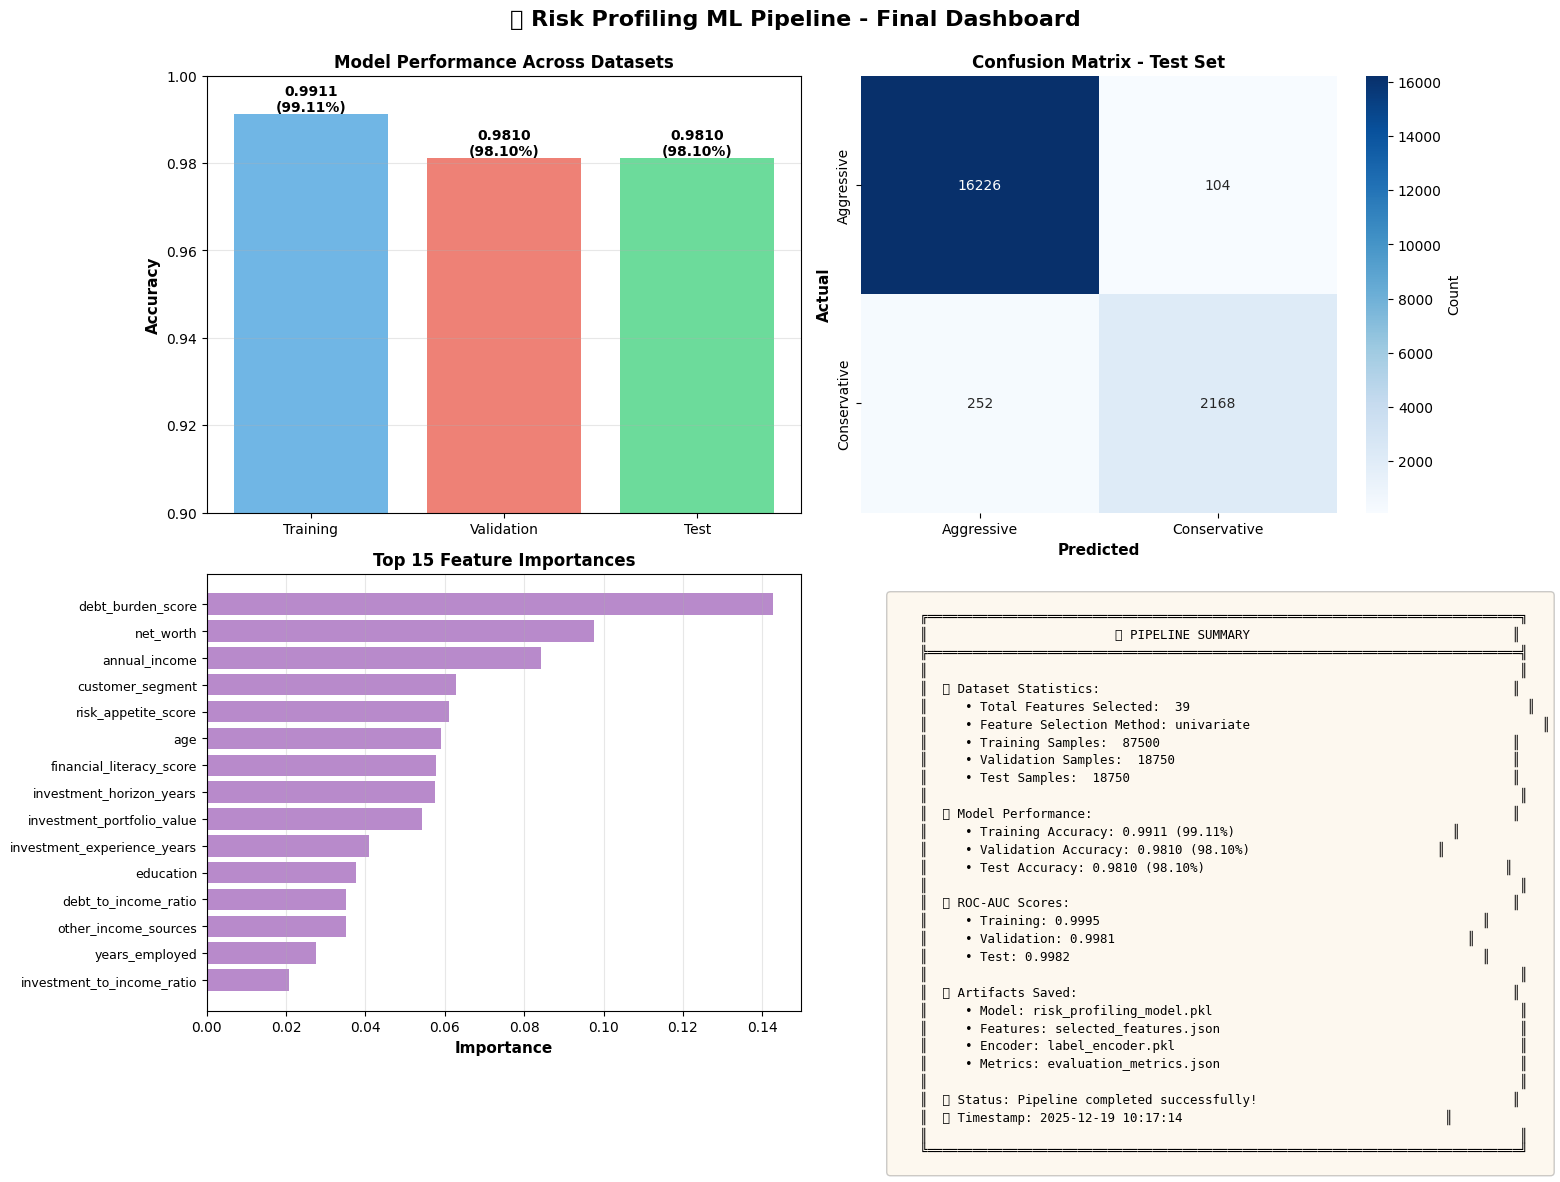


✓ Pipeline Summary Dashboard Created Successfully!


In [300]:
# Final Pipeline Summary Dashboard
def create_pipeline_summary_dashboard(evaluation_results, feature_importance_df, 
                                       best_fs_method, selected_features, le_target):
    """
    Create a comprehensive dashboard summarizing the entire pipeline.
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('🚀 Risk Profiling ML Pipeline - Final Dashboard', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    # 1. Model Performance Comparison (Bar Chart)
    ax1 = axes[0, 0]
    datasets = ['Training', 'Validation', 'Test']
    accuracies = [
        evaluation_results['training']['accuracy'],
        evaluation_results['validation']['accuracy'],
        evaluation_results['test']['accuracy']
    ]
    
    bars = ax1.bar(datasets, accuracies, color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.7)
    ax1.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
    ax1.set_title('Model Performance Across Datasets', fontsize=12, fontweight='bold')
    ax1.set_ylim([0.9, 1.0])
    ax1.grid(True, alpha=0.3, axis='y')
    
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{acc:.4f}\n({acc*100:.2f}%)',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # 2. Confusion Matrix (Test Set)
    ax2 = axes[0, 1]
    cm = evaluation_results['test']['confusion_matrix']
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=le_target.classes_, 
                yticklabels=le_target.classes_,
                cbar_kws={'label': 'Count'},
                ax=ax2)
    ax2.set_title('Confusion Matrix - Test Set', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Actual', fontsize=11, fontweight='bold')
    ax2.set_xlabel('Predicted', fontsize=11, fontweight='bold')
    
    # 3. Top 15 Feature Importances
    ax3 = axes[1, 0]
    top_features = feature_importance_df.head(15)
    
    ax3.barh(range(len(top_features)), top_features['importance'], color='#9b59b6', alpha=0.7)
    ax3.set_yticks(range(len(top_features)))
    ax3.set_yticklabels(top_features['feature'], fontsize=9)
    ax3.set_xlabel('Importance', fontsize=11, fontweight='bold')
    ax3.set_title('Top 15 Feature Importances', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='x')
    ax3.invert_yaxis()
    
    # 4. Summary Statistics Box
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    summary_text = f"""
    ╔═══════════════════════════════════════════════════════════════════════════════╗
    ║                         🎯 PIPELINE SUMMARY                                   ║
    ╠═══════════════════════════════════════════════════════════════════════════════╣
    ║                                                                               ║
    ║  📊 Dataset Statistics:                                                       ║
    ║     • Total Features Selected: {len(selected_features):>3}                                             ║
    ║     • Feature Selection Method: {best_fs_method:<30}                   ║
    ║     • Training Samples: {len(y_train):>6}                                               ║
    ║     • Validation Samples: {len(y_val):>6}                                             ║
    ║     • Test Samples: {len(y_test):>6}                                                   ║
    ║                                                                               ║
    ║  🎯 Model Performance:                                                        ║
    ║     • Training Accuracy: {evaluation_results['training']['accuracy']:.4f} ({evaluation_results['training']['accuracy']*100:.2f}%)                             ║
    ║     • Validation Accuracy: {evaluation_results['validation']['accuracy']:.4f} ({evaluation_results['validation']['accuracy']*100:.2f}%)                         ║
    ║     • Test Accuracy: {evaluation_results['test']['accuracy']:.4f} ({evaluation_results['test']['accuracy']*100:.2f}%)                                        ║
    ║                                                                               ║
    ║  📈 ROC-AUC Scores:                                                           ║
    ║     • Training: {evaluation_results['training']['auc_roc']:.4f}                                                   ║
    ║     • Validation: {evaluation_results['validation']['auc_roc']:.4f}                                               ║
    ║     • Test: {evaluation_results['test']['auc_roc']:.4f}                                                       ║
    ║                                                                               ║
    ║  💾 Artifacts Saved:                                                          ║
    ║     • Model: risk_profiling_model.pkl                                         ║
    ║     • Features: selected_features.json                                        ║
    ║     • Encoder: label_encoder.pkl                                              ║
    ║     • Metrics: evaluation_metrics.json                                        ║
    ║                                                                               ║
    ║  ✅ Status: Pipeline completed successfully!                                  ║
    ║  📅 Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S'):<40}              ║
    ║                                                                               ║
    ╚═══════════════════════════════════════════════════════════════════════════════╝
    """
    
    ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes,
             fontsize=9, verticalalignment='top',
             fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2))
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*100)
    print("✓ Pipeline Summary Dashboard Created Successfully!")
    print("="*100)

# Create the dashboard
create_pipeline_summary_dashboard(evaluation_results, feature_importance_df, 
                                   best_fs_method, selected_features, le_target)
